# Connect Forest Management Model with Forest Carbon Budget Model

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [4]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons',  'bau_redchrs', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'bau_gldbr', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'bau_eqtslvr', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='redchris',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_ha',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', options=('redchris', 'goldenbear', 'equitysilver', 'test'), value='redchri…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'bau_redchrs', 'redchrs_AAC_90…

Dropdown(description='Objective:', index=1, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_ha')

In [5]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [6]:
#Start Calculating the Running Time
Start = time.time()

In [7]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [8]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [9]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [10]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [11]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/goldenbear_c_curves_p.pkl
Loaded data from ./inputs/curves/goldenbear_c_curves_f.pkl


In [13]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for goldenbear_min_ha_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3905 rows, 36130 columns and 36130 nonzeros
Model fingerprint: 0x801989dc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3905 rows and 36130 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.01 work units)
Optimal objective  0.000000000e+00


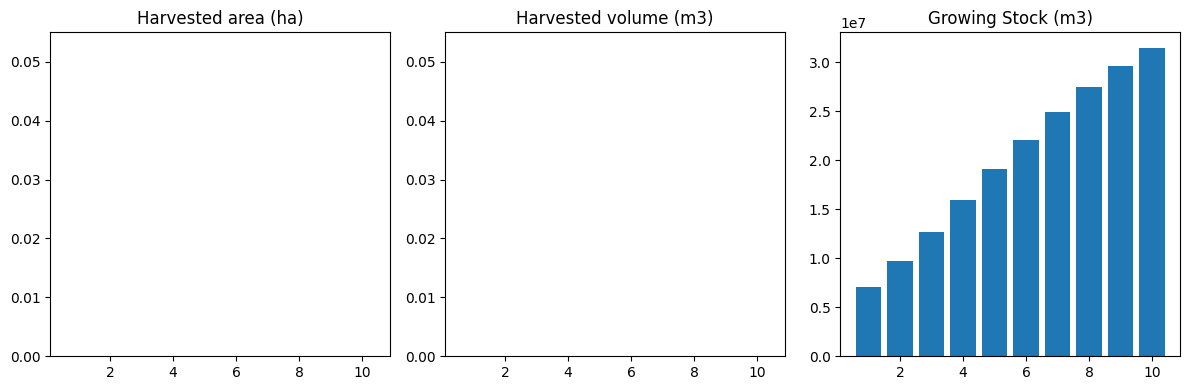

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_no_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


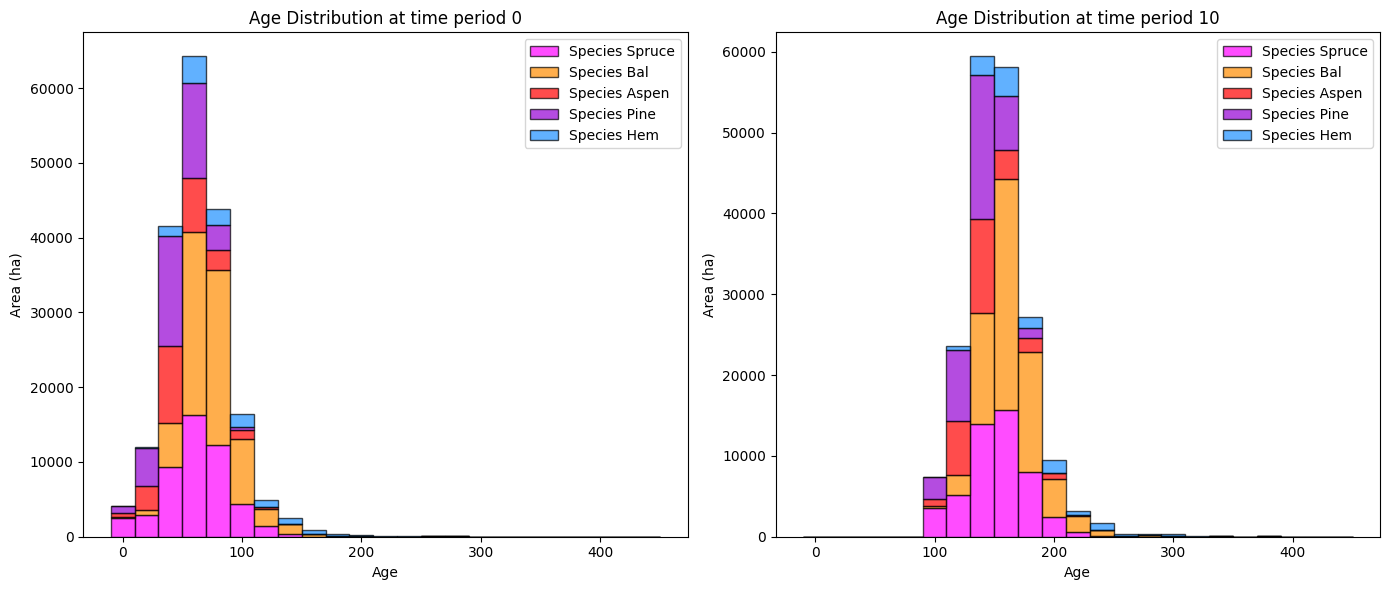

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  13191.618272  12918.127794
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3929.593538   3509.894208

Overall diversity has **increased** by 47781.91 hectares from time period 0 to time period 10.


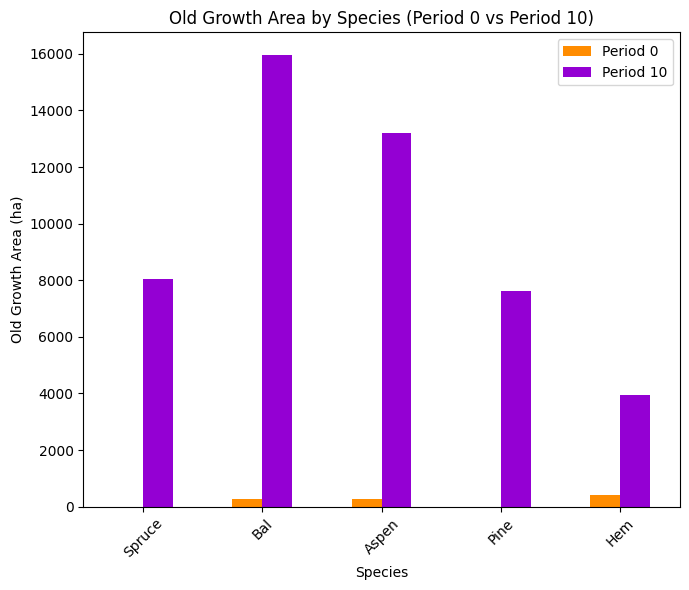

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_no_cons_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2589
Bal: 0.3607
Aspen: 0.1227
Pine: 0.1624
Hem: 0.0953

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9285

Diversity has **decreased** by 1.71% from time 0 to time 10.


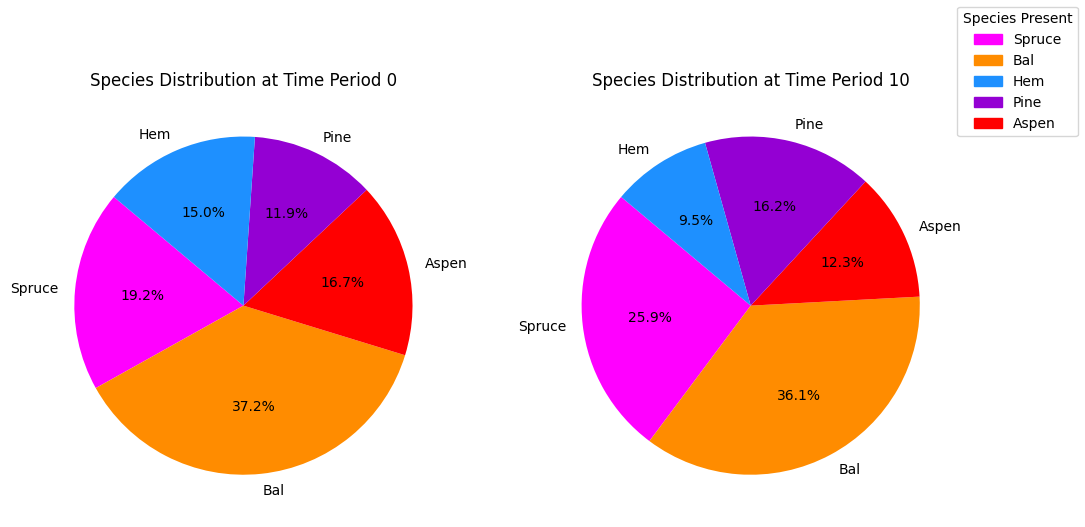

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_no_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.19s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Factor Ops

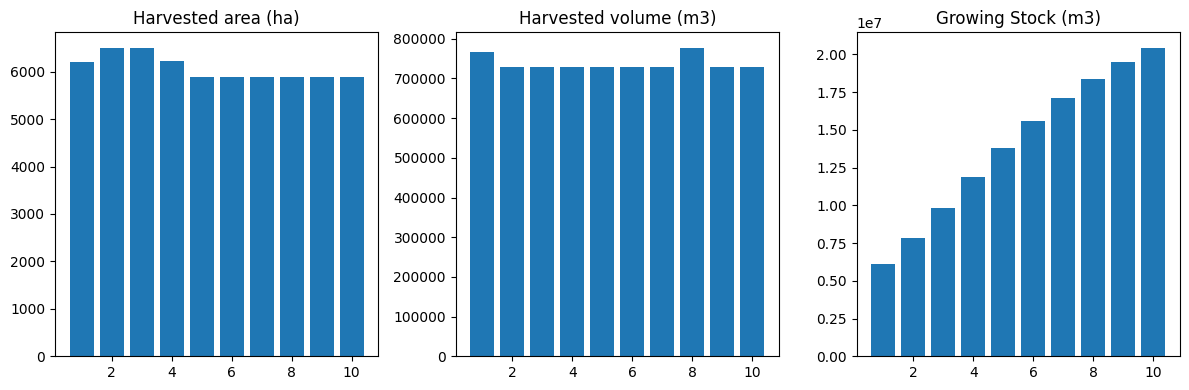

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


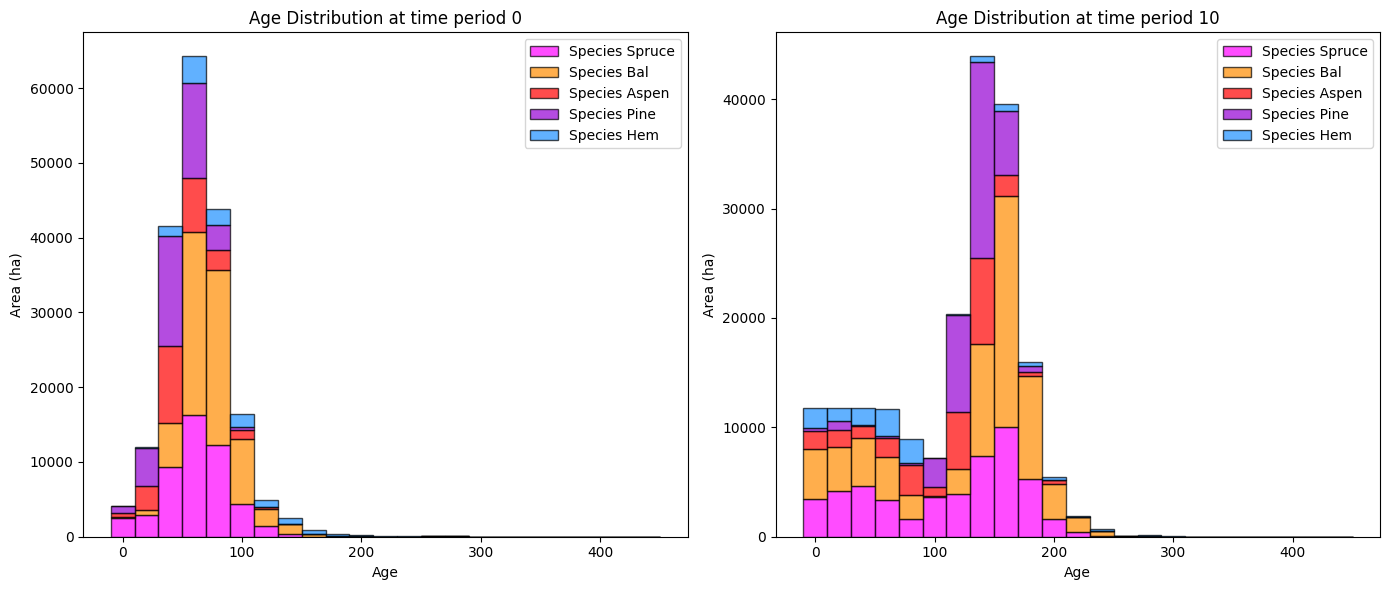

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


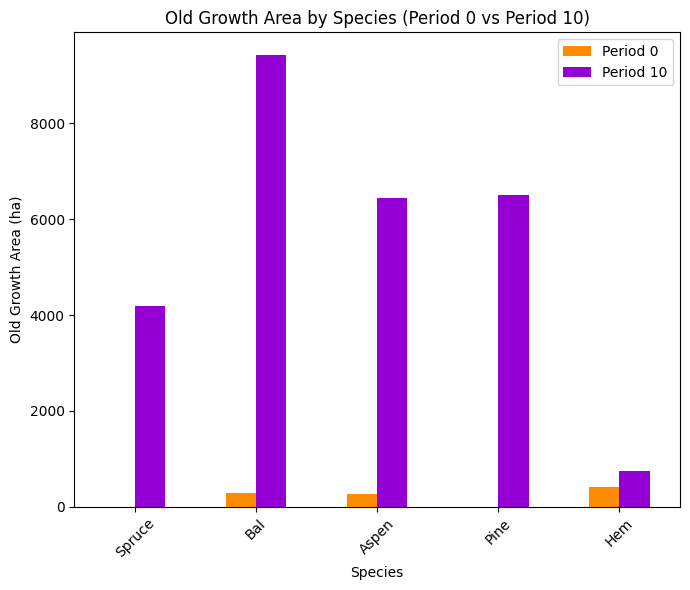

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


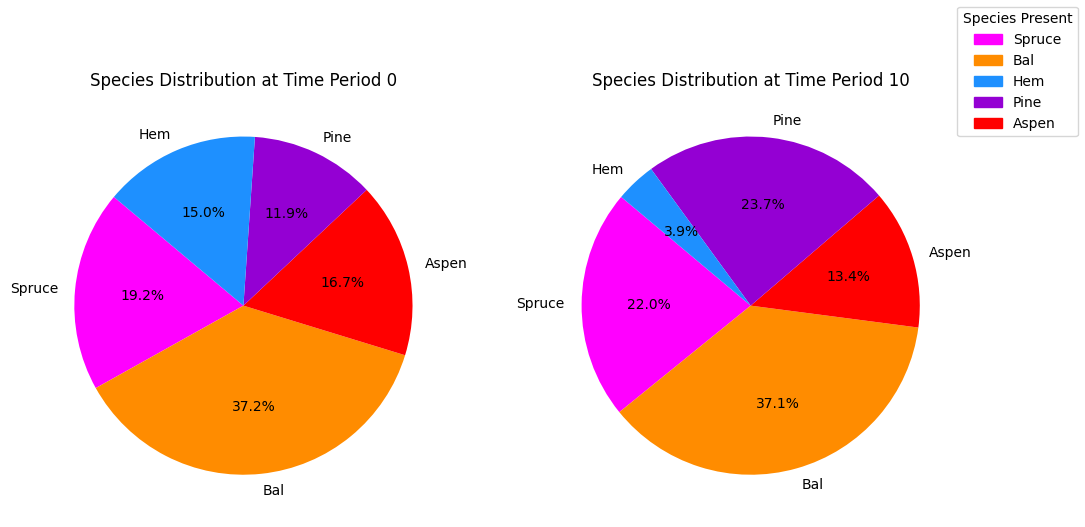

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


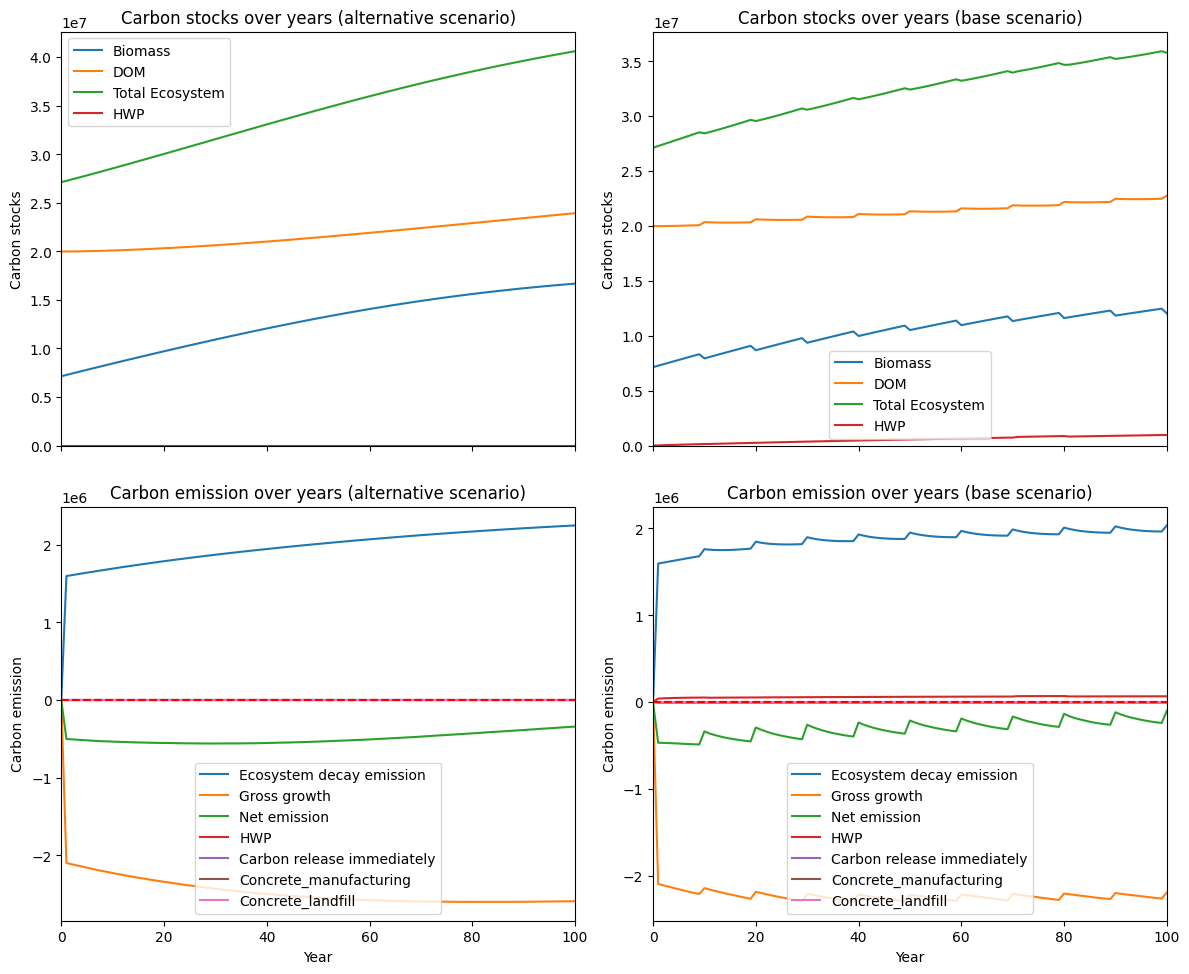

---------------------------------------------------------------------------------------
Net emission difference -2801817.297988709
Net emission base scenario -12873402.697854219
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  3.569112092775829
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3856.317883  3856.317883
Bal     0.0  6535.869074  6535.869074
Aspen   0.0  6742.094877  6742.094877
Pine    0.0  1120.061136  1120.061136
Hem     0.0  3178.062344  3178.062344

Overall, the old growth area has **increased** by 21432.41 hectares in the alternative scenario compared to the base scenario.


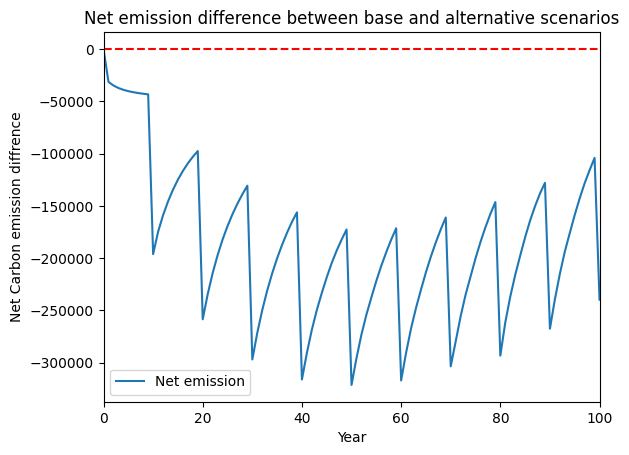

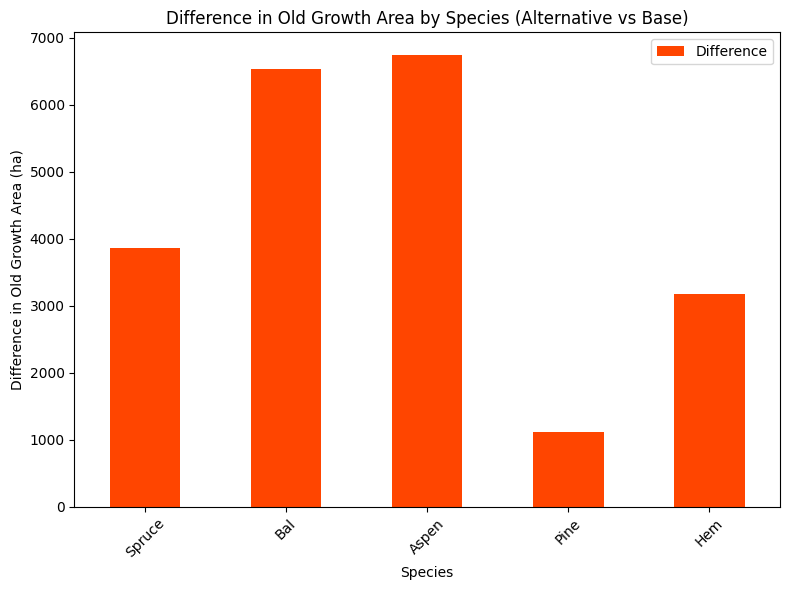

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


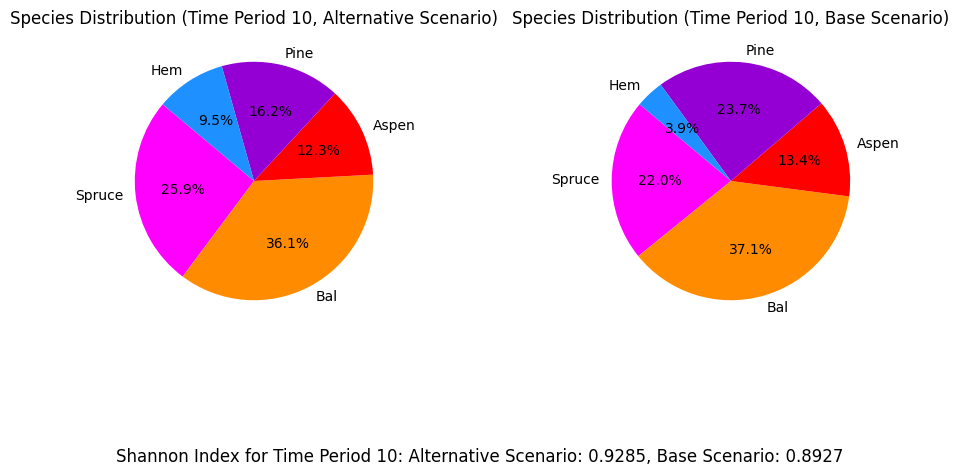

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3945 rows, 36130 columns and 430076 nonzeros
Model fingerprint: 0xa2964300
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3945 rows and 36130 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00  

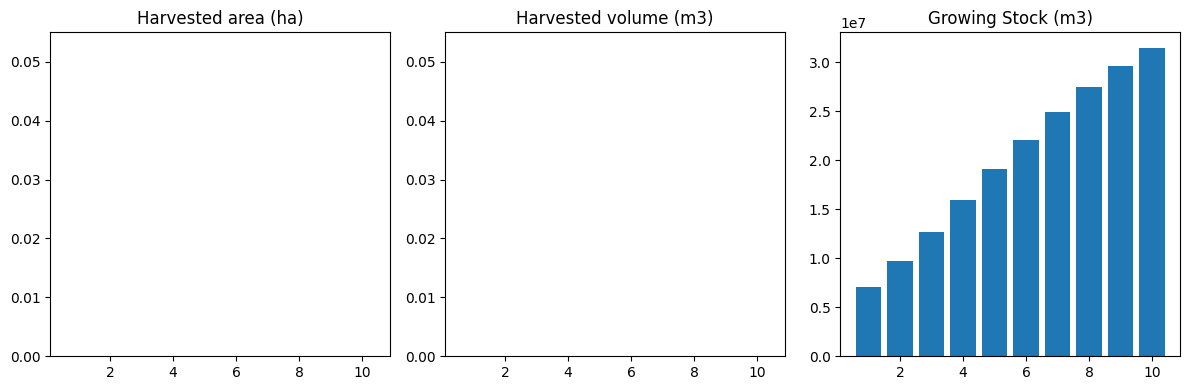

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_evenflow_cons_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


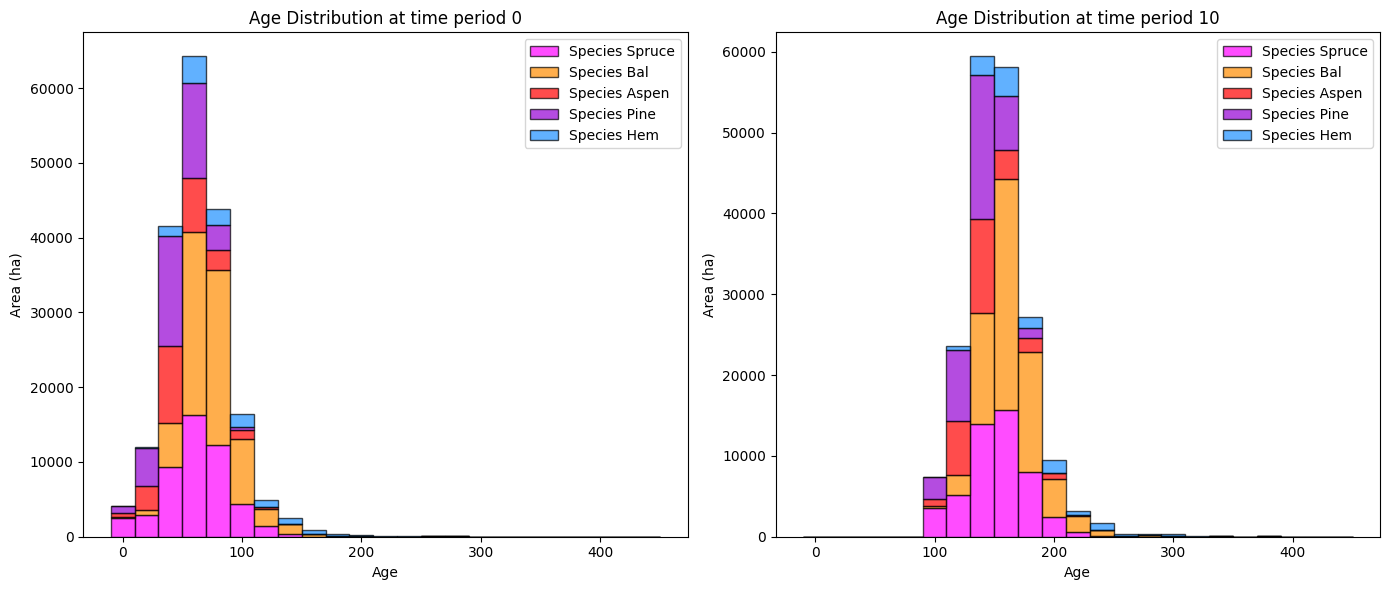

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   8040.264040   8037.555506
Bal     278.565372  15963.007735  15684.442363
Aspen   273.490478  13191.618272  12918.127794
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   3929.593538   3509.894208

Overall diversity has **increased** by 47781.91 hectares from time period 0 to time period 10.


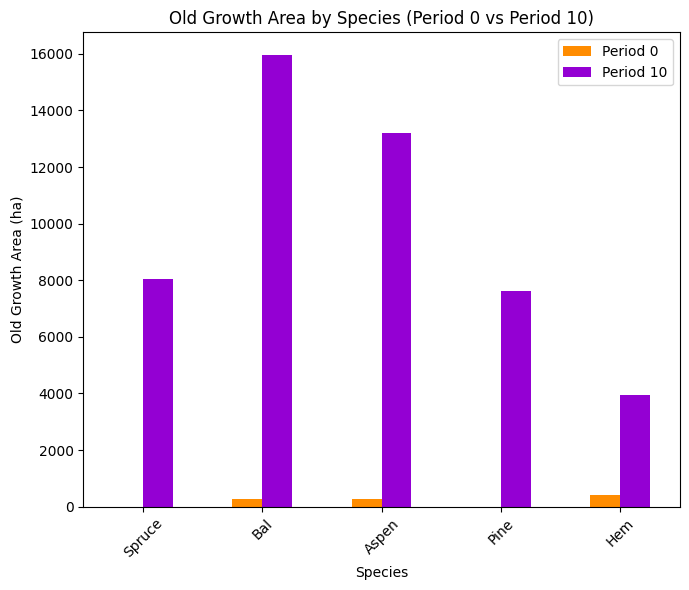

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_evenflow_cons_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2589
Bal: 0.3607
Aspen: 0.1227
Pine: 0.1624
Hem: 0.0953

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9285

Diversity has **decreased** by 1.71% from time 0 to time 10.


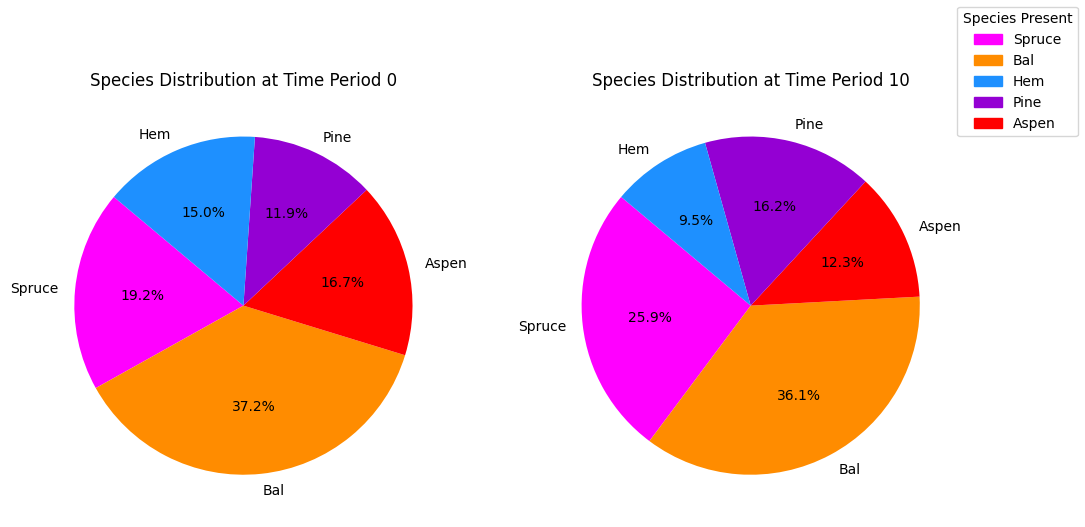

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_evenflow_cons_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.20s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

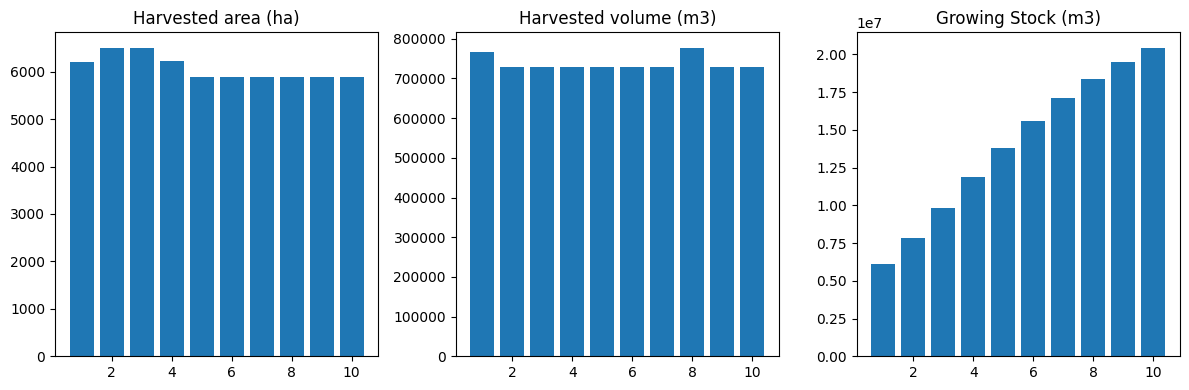

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


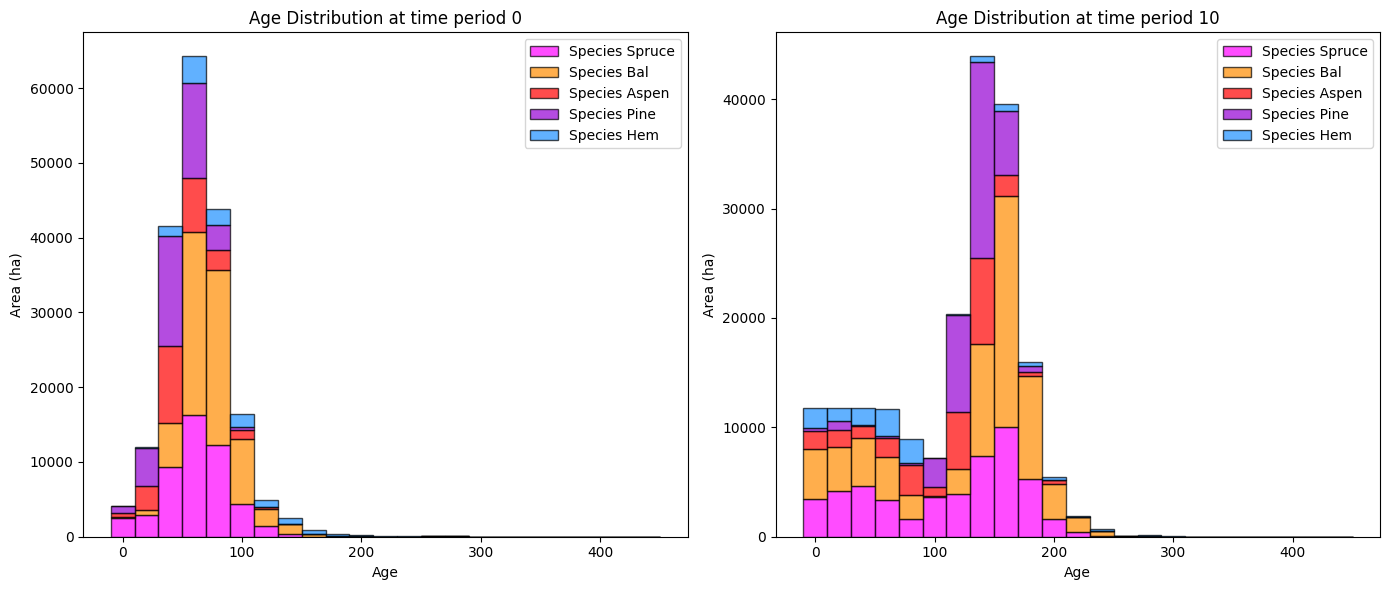

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


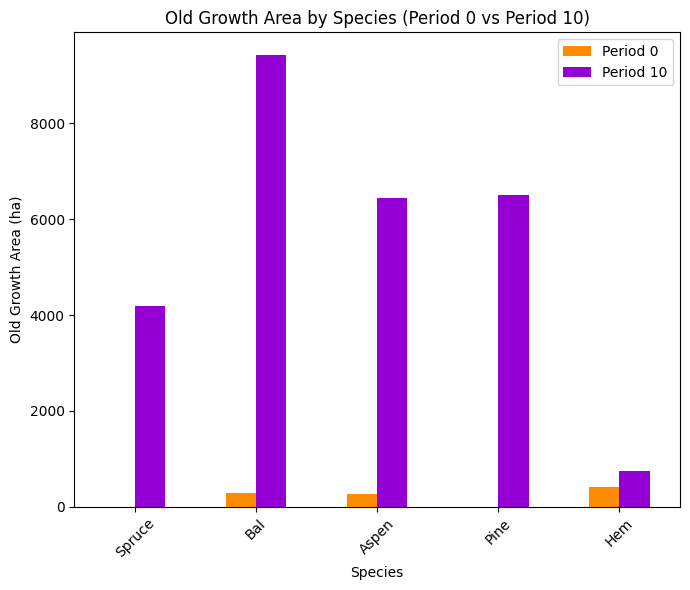

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


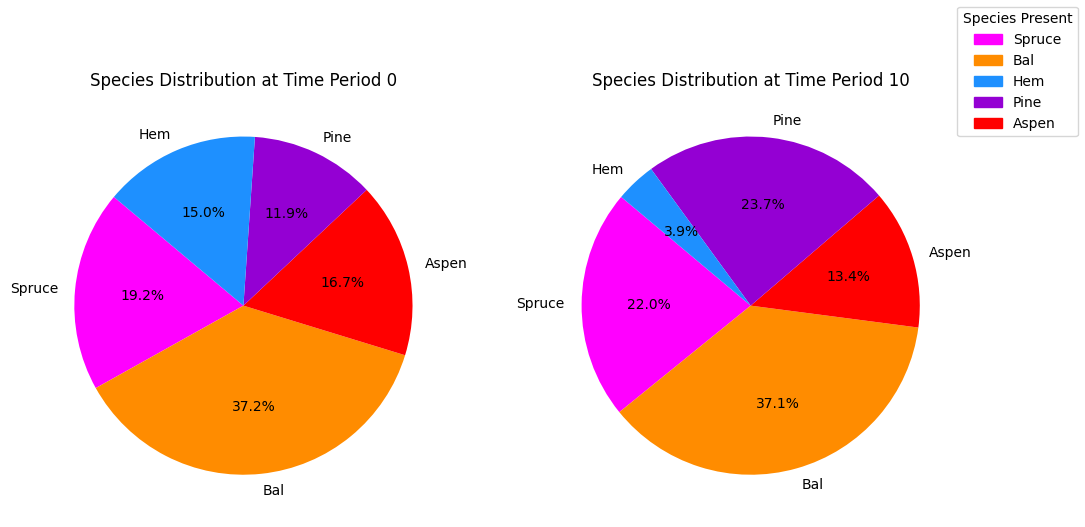

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


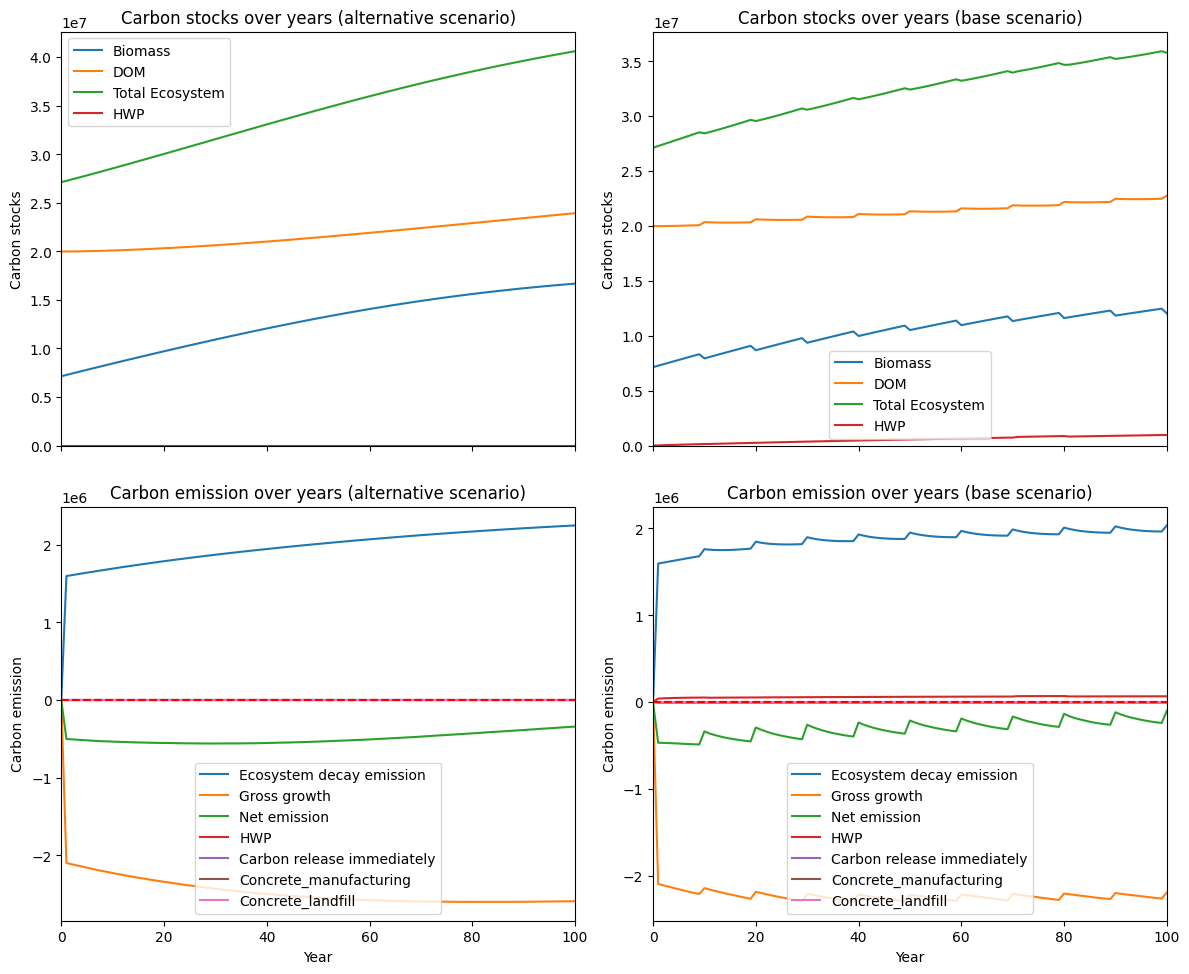

---------------------------------------------------------------------------------------
Net emission difference -2801817.297988709
Net emission base scenario -12873402.697854219
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  3.569112092775829
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3856.317883  3856.317883
Bal     0.0  6535.869074  6535.869074
Aspen   0.0  6742.094877  6742.094877
Pine    0.0  1120.061136  1120.061136
Hem     0.0  3178.062344  3178.062344

Overall, the old growth area has **increased** by 21432.41 hectares in the alternative scenario compared to the base scenario.


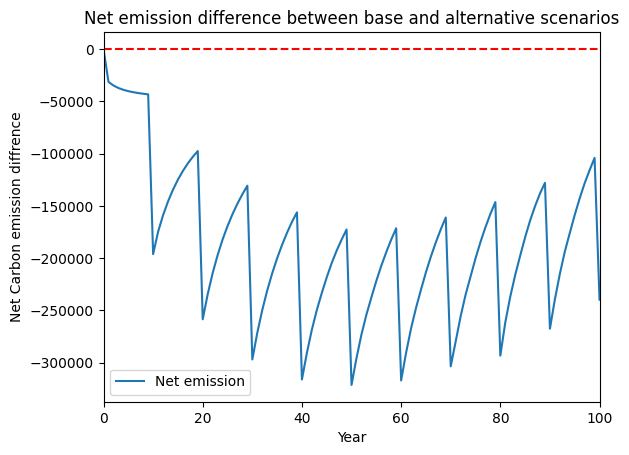

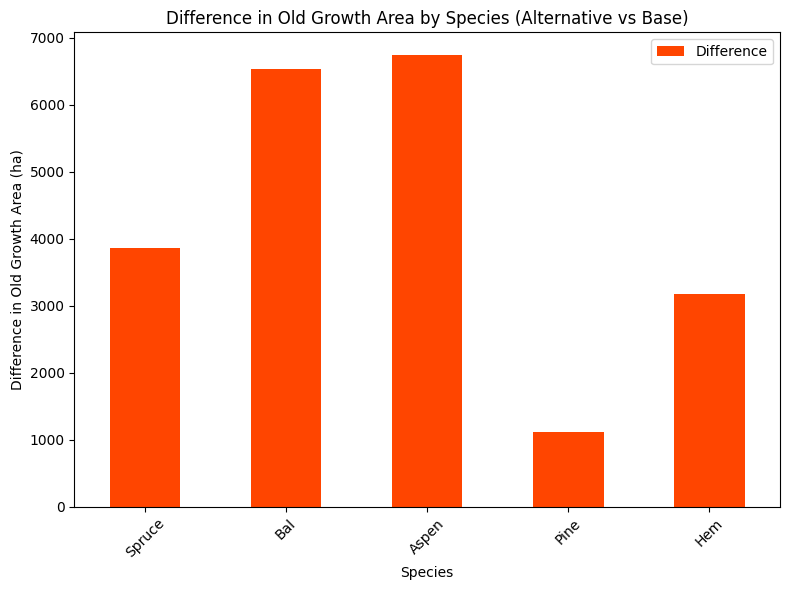

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


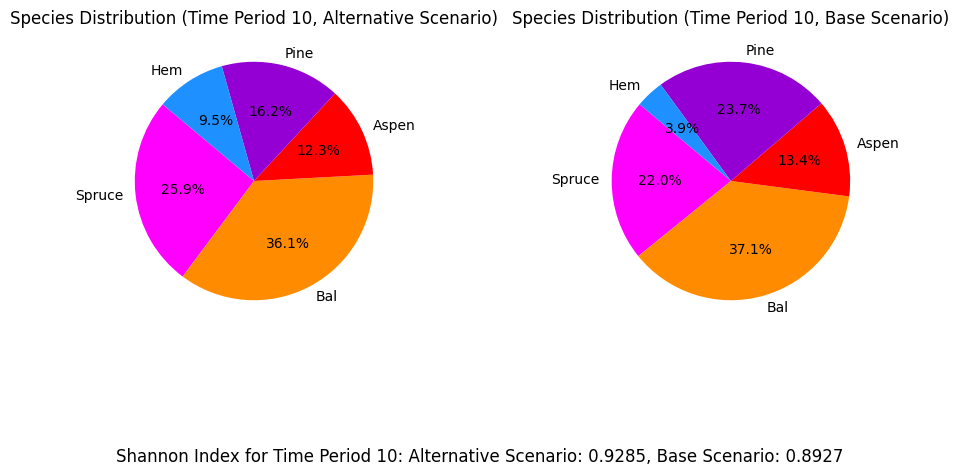

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_bau_gldbr...
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier lo

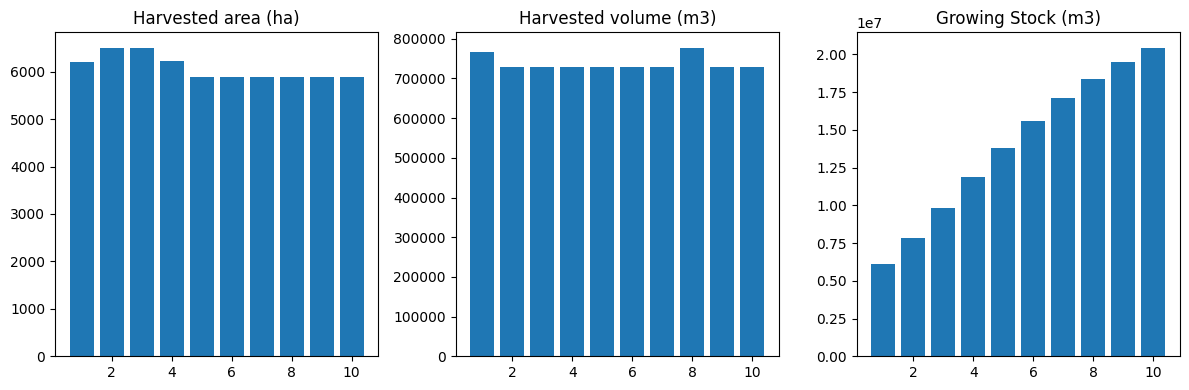

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


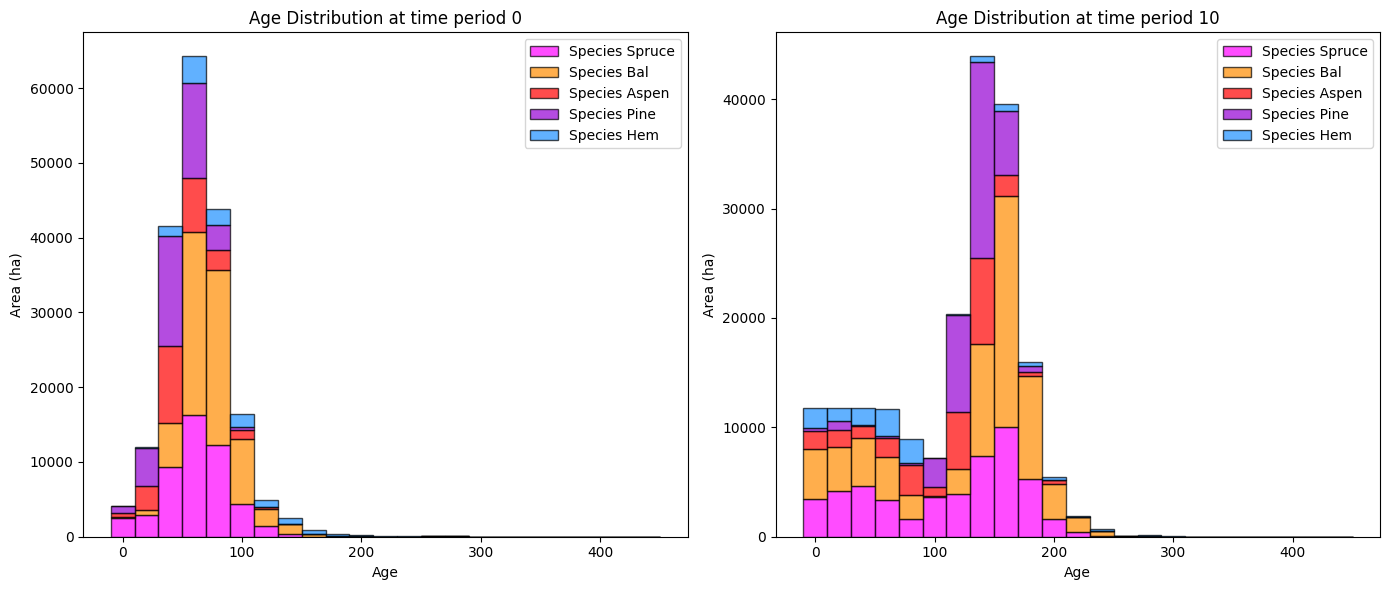

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


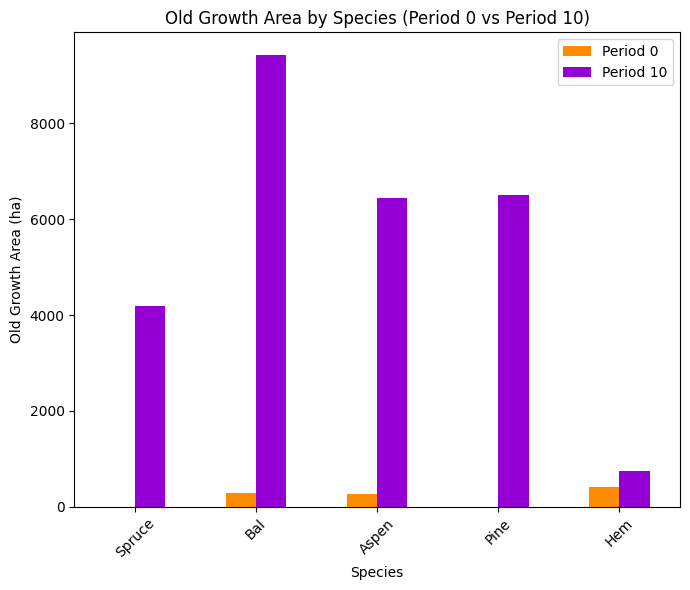

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


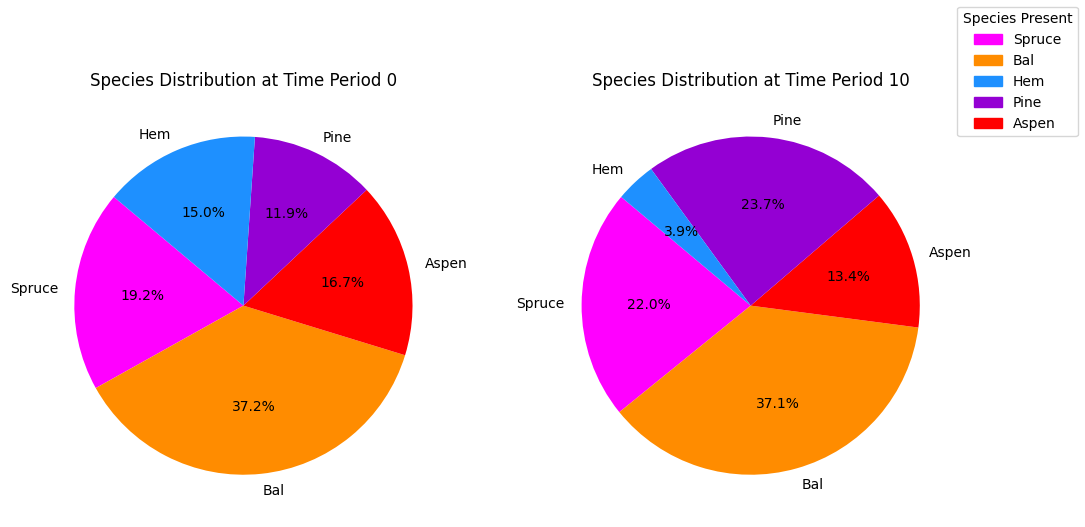

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.18s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Factor O

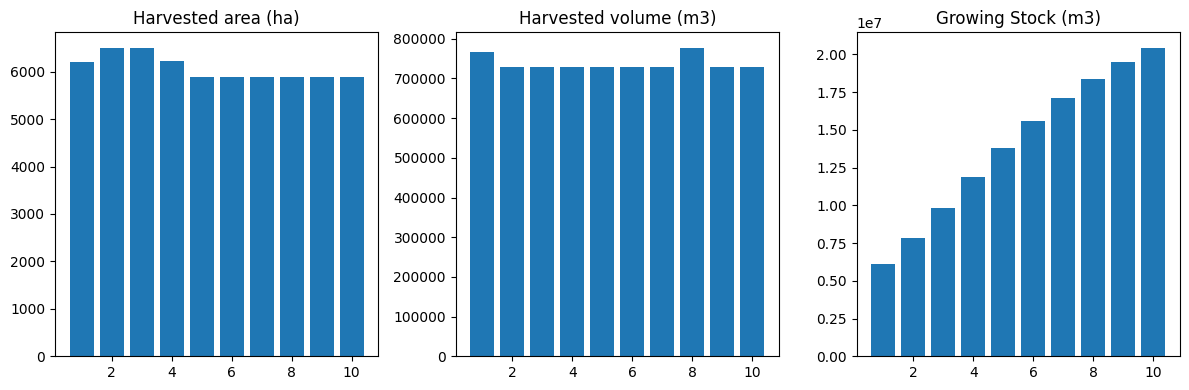

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


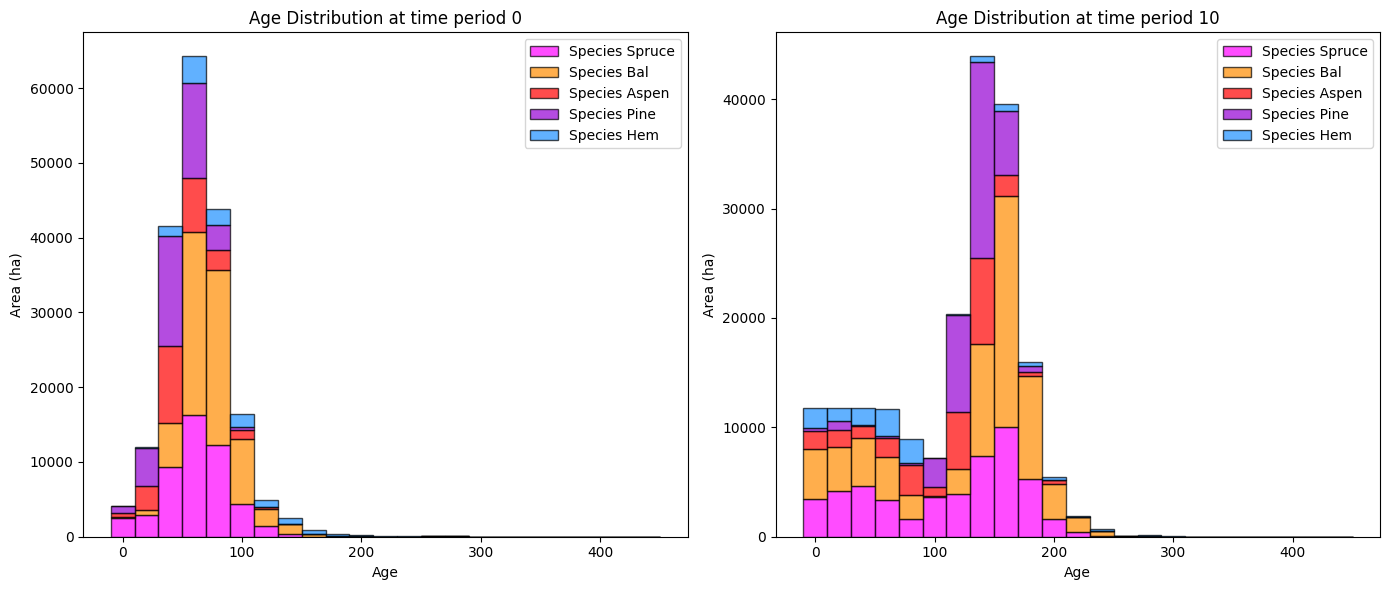

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


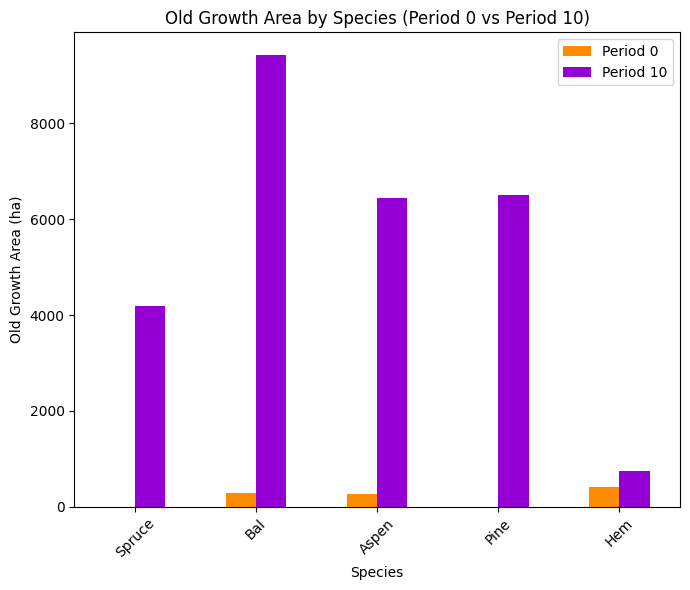

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


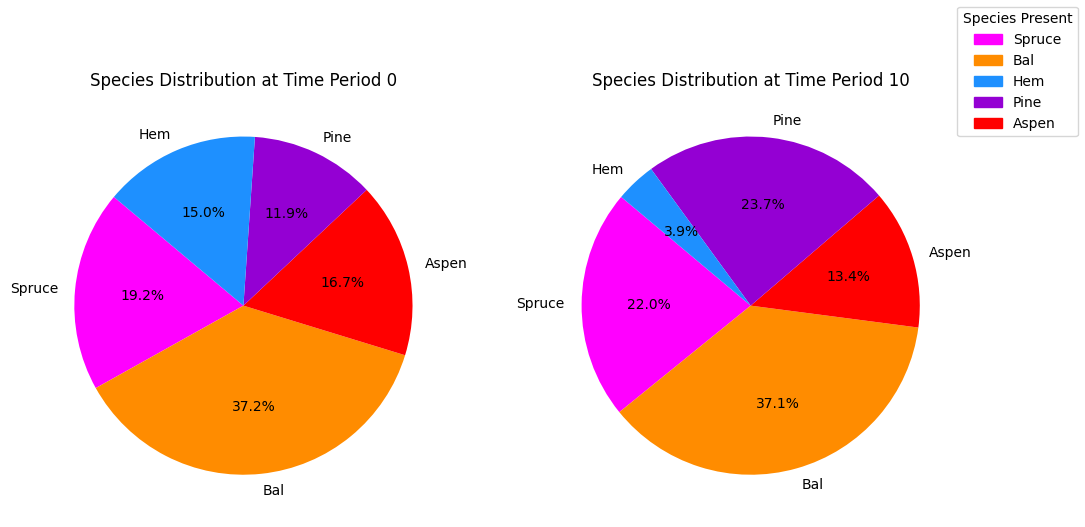

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


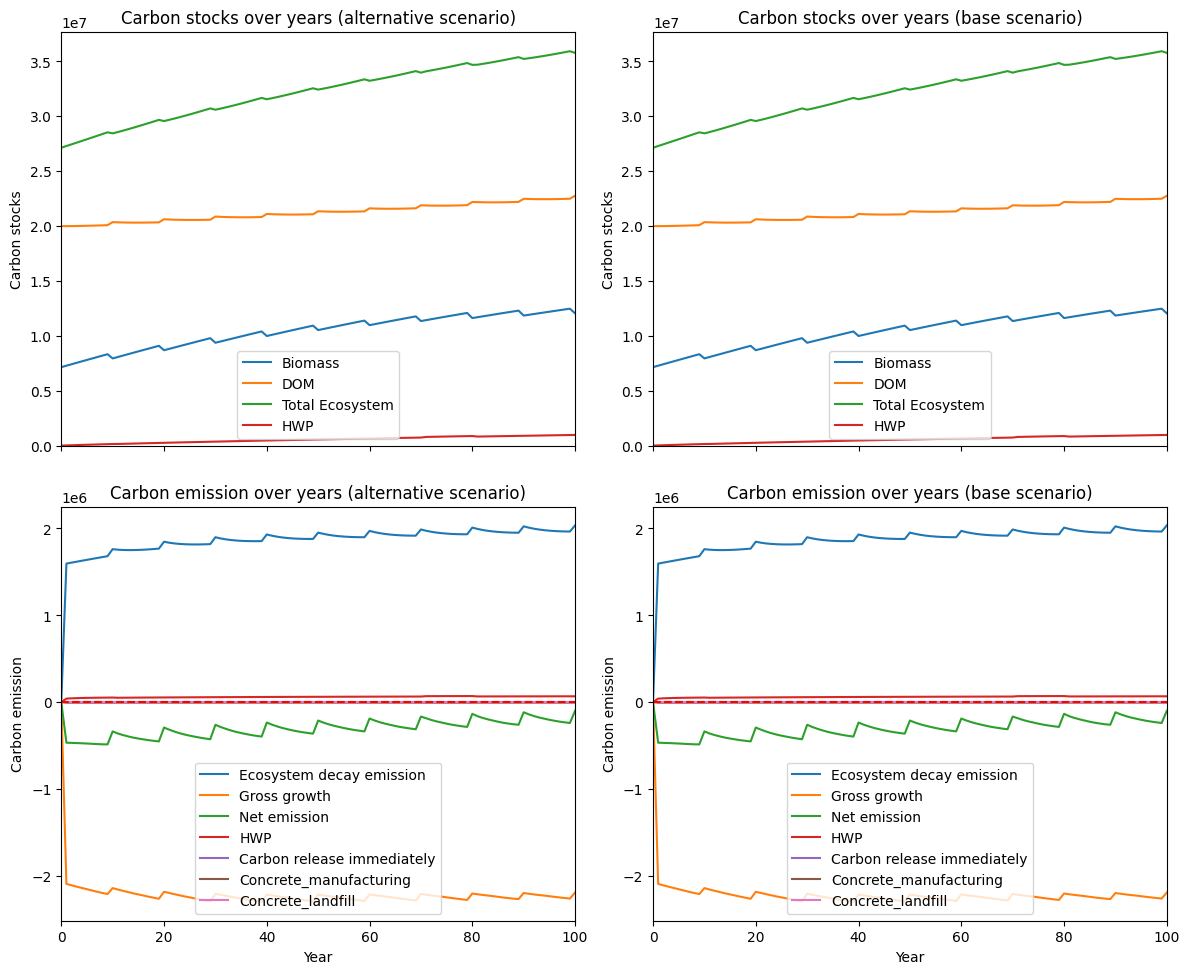

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -10071585.399865512
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
          0   10  Difference
Spruce  0.0  0.0         0.0
Bal     0.0  0.0         0.0
Aspen   0.0  0.0         0.0
Pine    0.0  0.0         0.0
Hem     0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/eghasemi/nbds_mining/util_opt.py:1211: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario.iloc[:25]['Net emission'].sum())


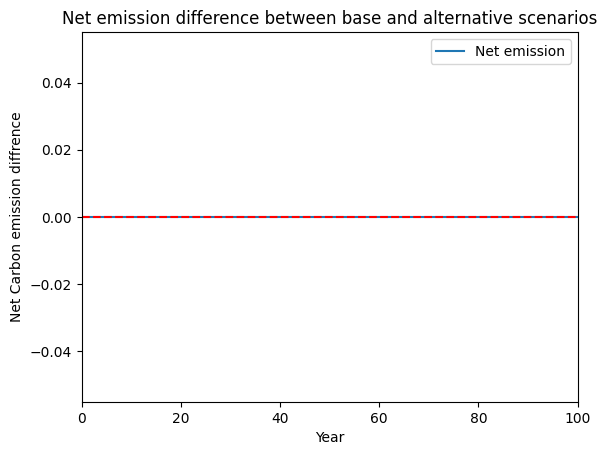

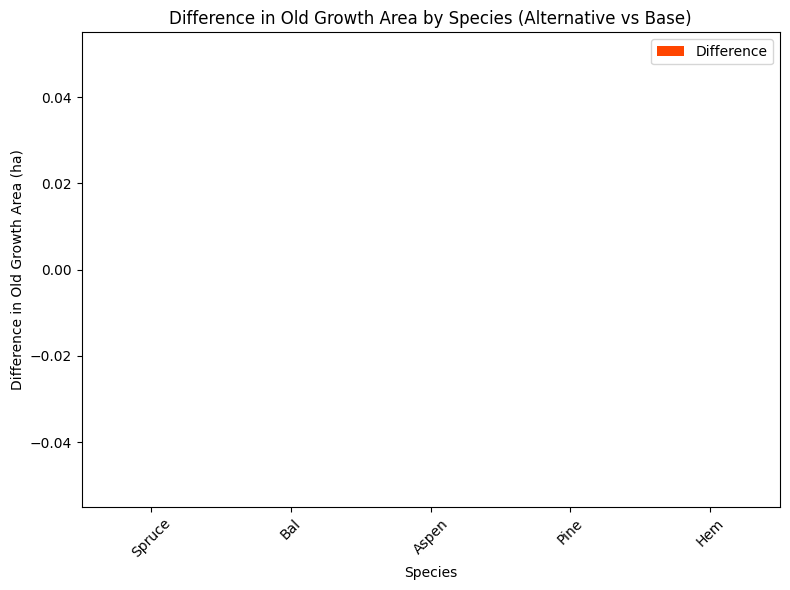

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


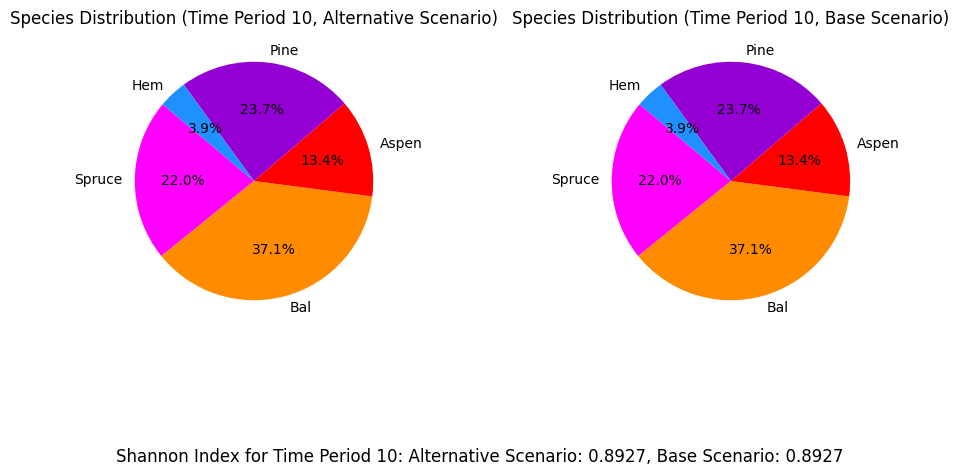

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_90%...
running the scenario for the Golden Bear mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x8f70c844
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.18s
Presolved: 1911 rows, 32226 

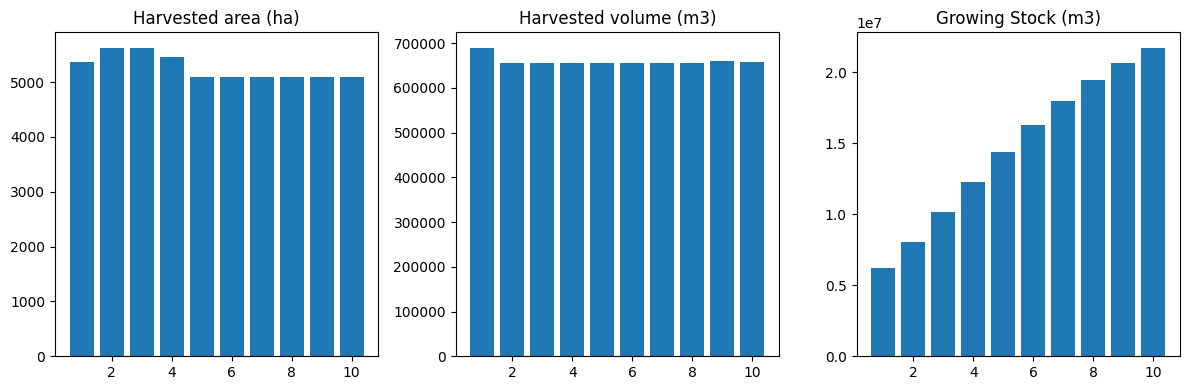

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_90%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6968
The economic indicator (the provincial government revenues) is:  237650
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


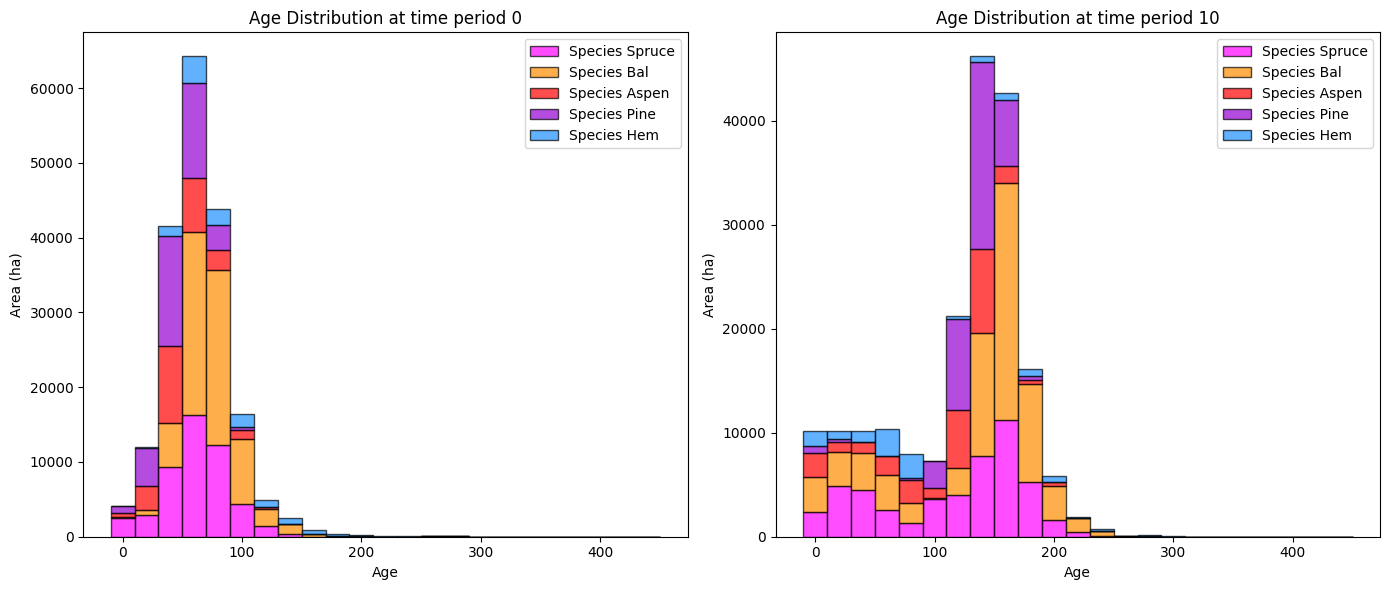

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4450.840228  4448.131695
Bal     278.565372  9918.328413  9639.763041
Aspen   273.490478  6631.044913  6357.554435
Pine      0.000000  6641.205351  6641.205351
Hem     419.699331  1026.165012   606.465681

Overall diversity has **increased** by 27693.12 hectares from time period 0 to time period 10.


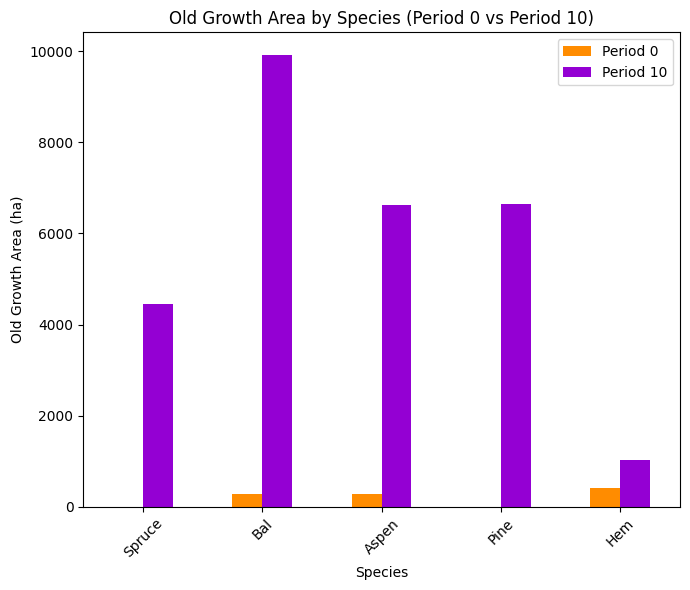

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_90%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2241
Bal: 0.3792
Aspen: 0.1263
Pine: 0.2260
Hem: 0.0445

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8939

Diversity has **decreased** by 5.16% from time 0 to time 10.


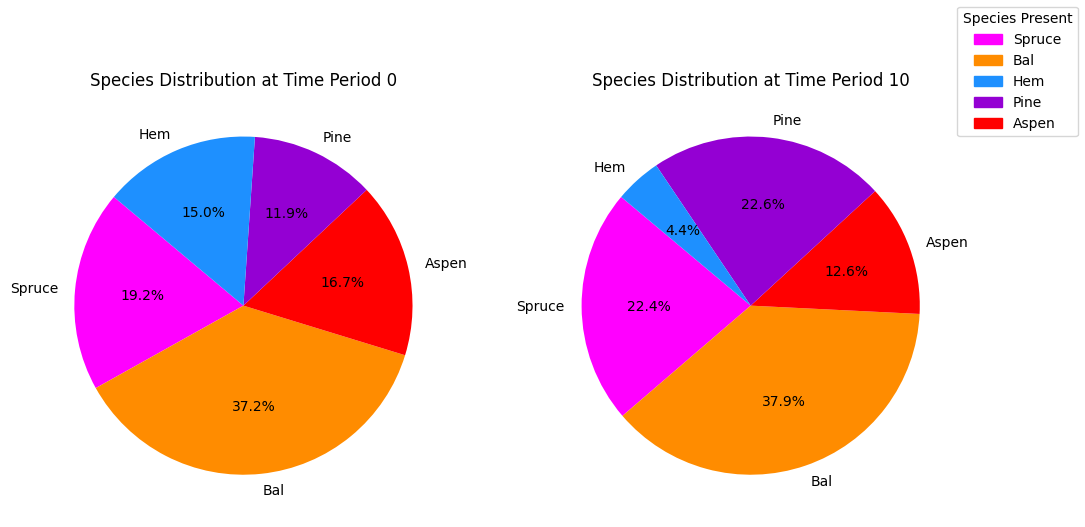

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_90%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

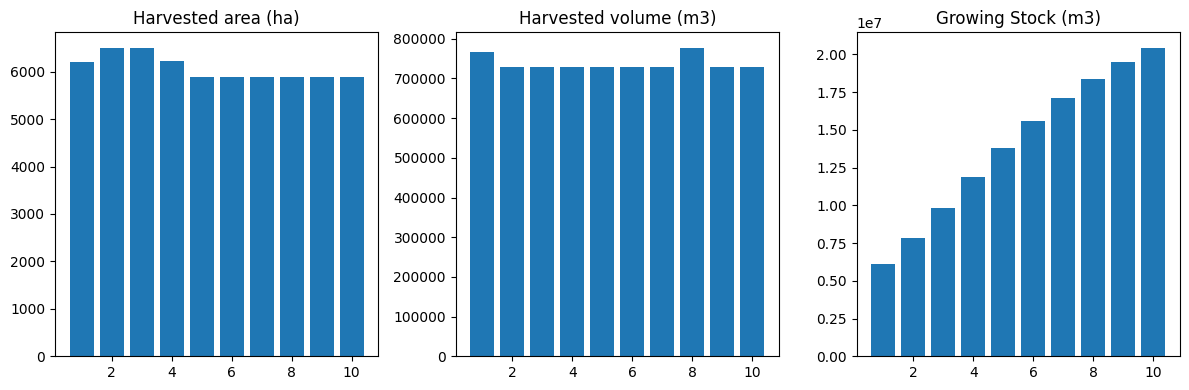

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


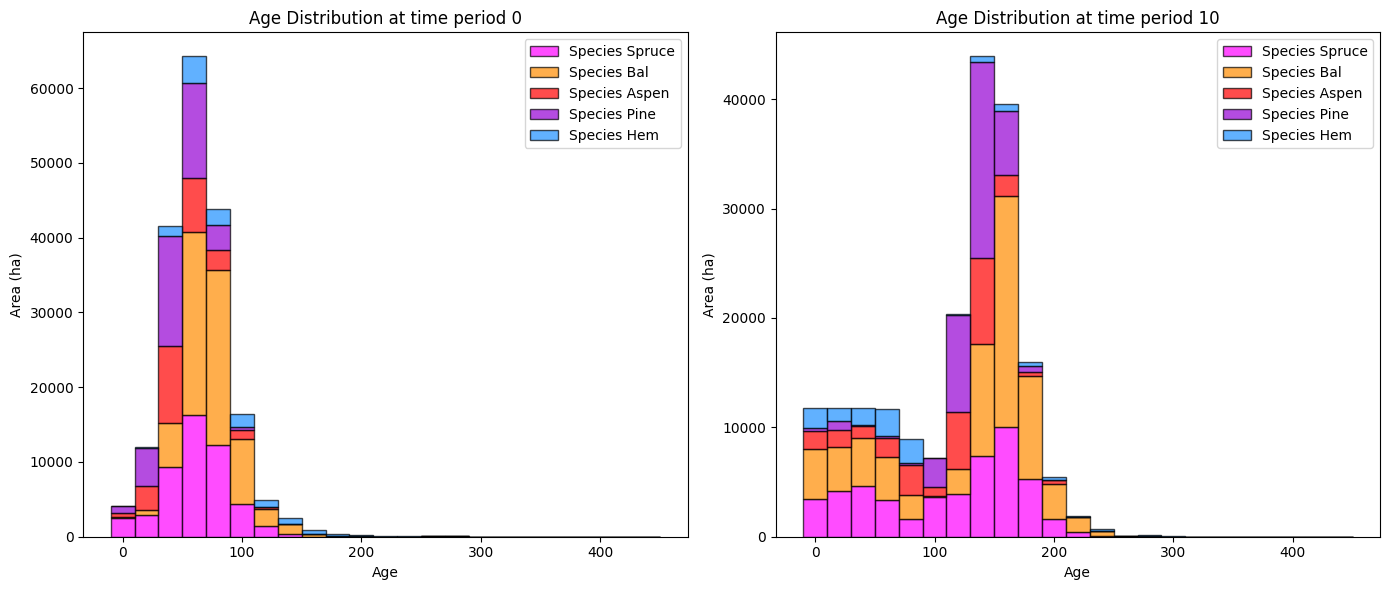

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


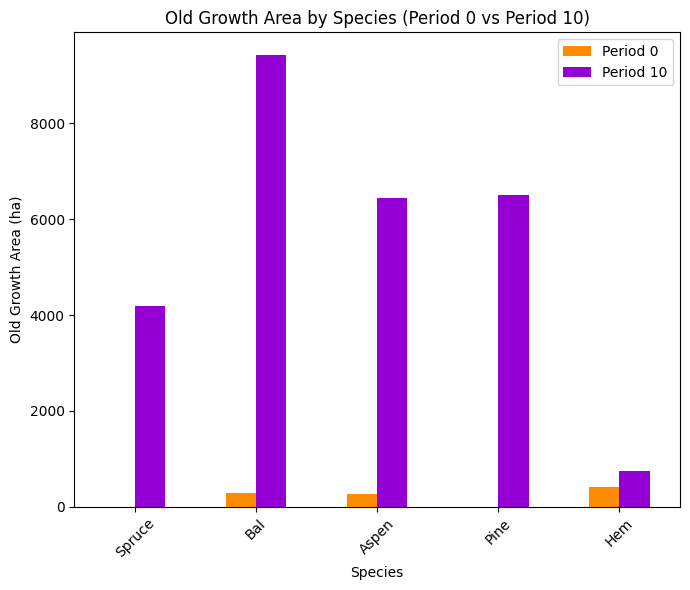

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


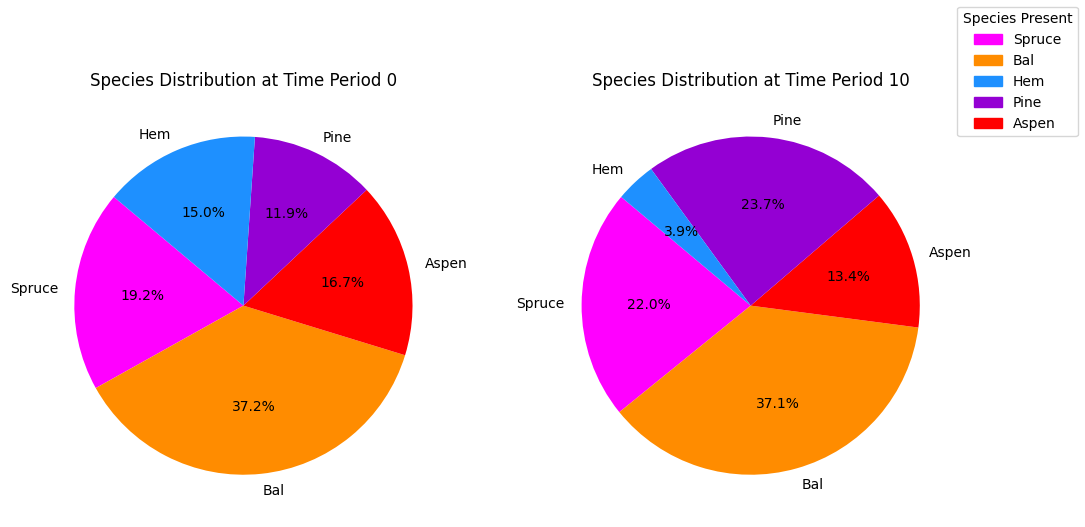

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


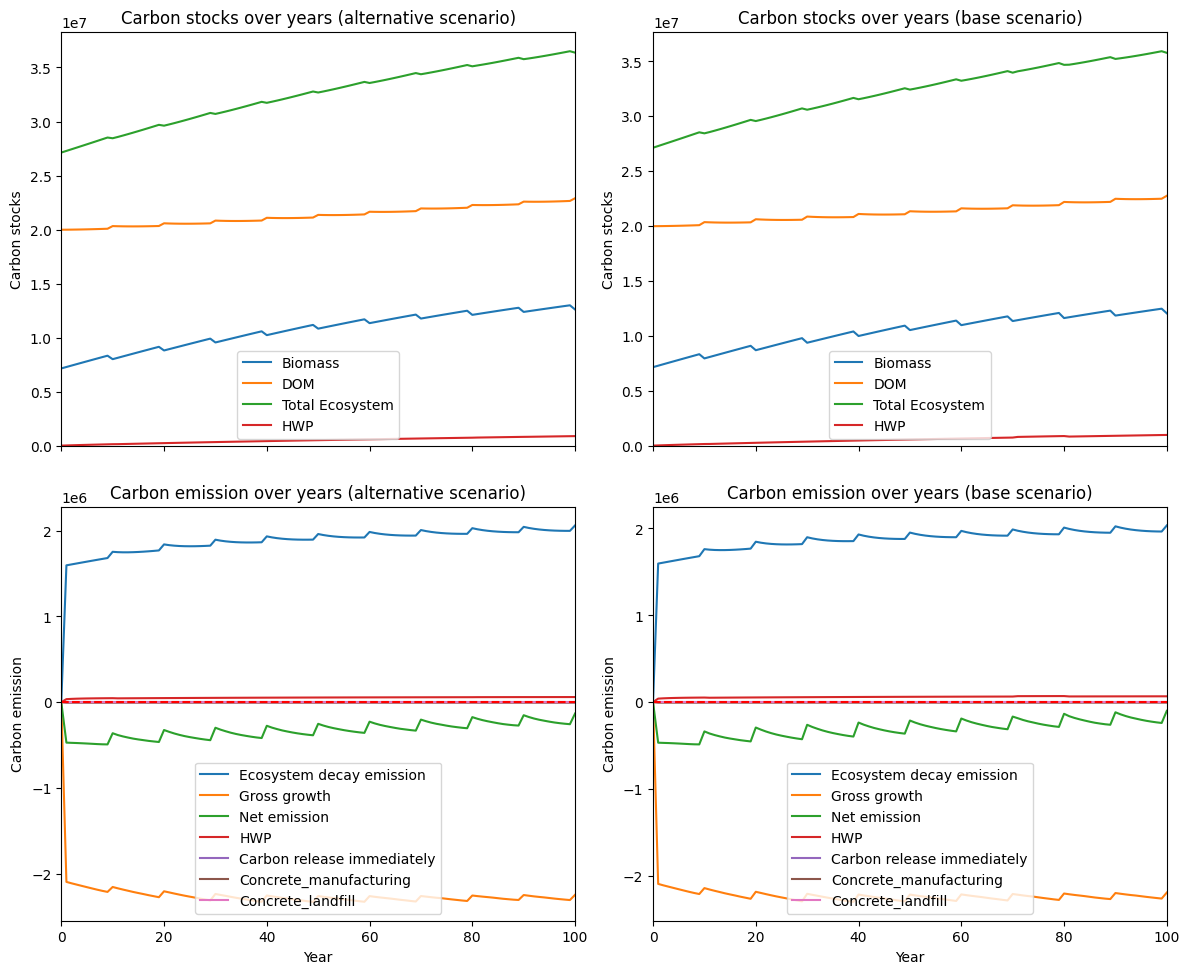

---------------------------------------------------------------------------------------
Net emission difference -319398.689731342
Net emission base scenario -10390984.089596853
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  31.308832257300015
Comparison of Old Growth Areas (Alternative - Base)
          0          10  Difference
Spruce  0.0  266.894072  266.894072
Bal     0.0  491.189752  491.189752
Aspen   0.0  181.521517  181.521517
Pine    0.0  129.379286  129.379286
Hem     0.0  274.633817  274.633817

Overall, the old growth area has **increased** by 1343.62 hectares in the alternative scenario compared to the base scenario.


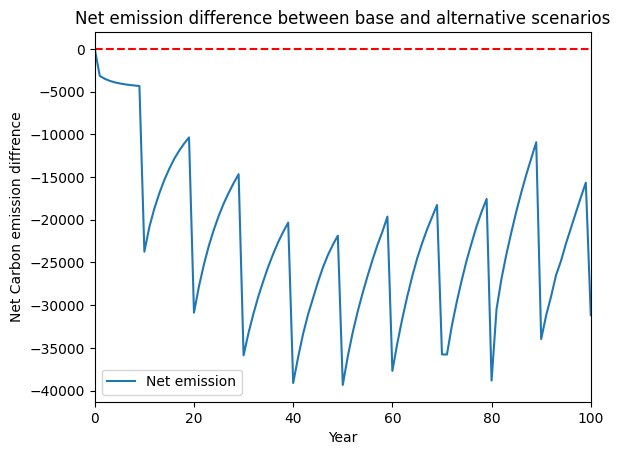

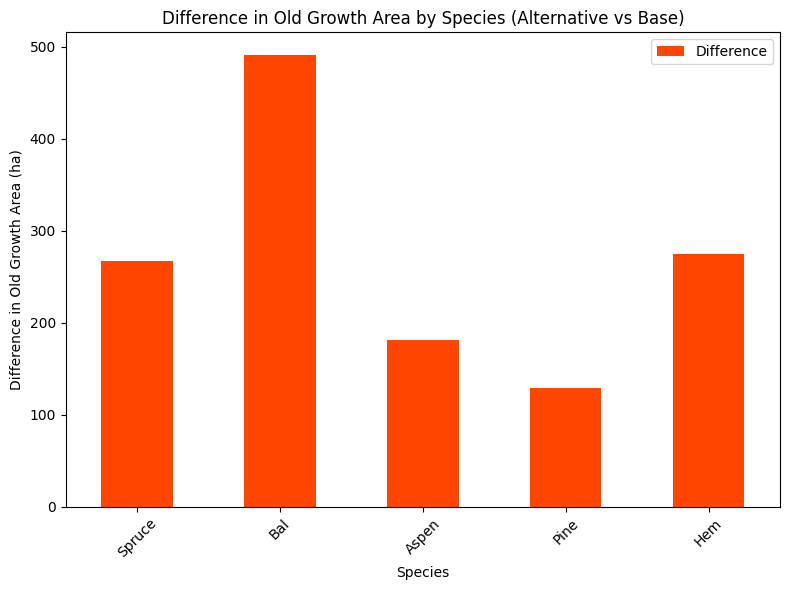

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


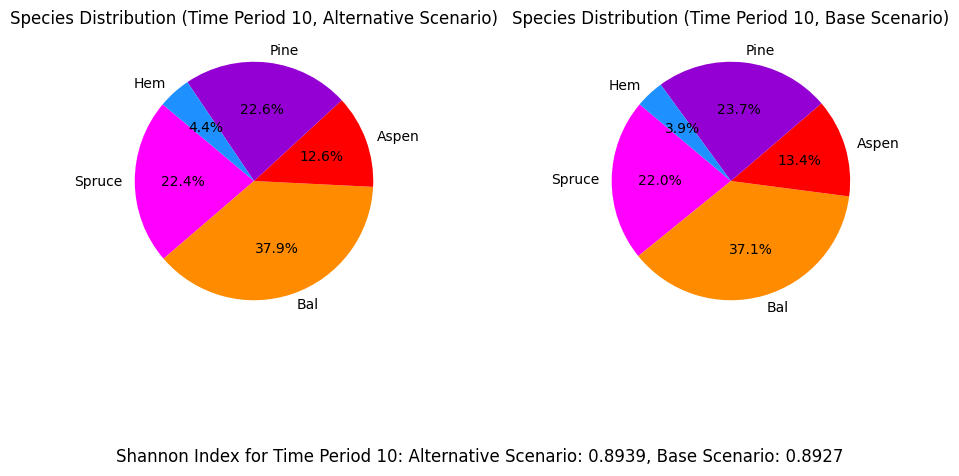

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_80%...
running the scenario for the Golden Bear mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x9ab17877
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.16s
Presolved: 1911 rows, 32226 

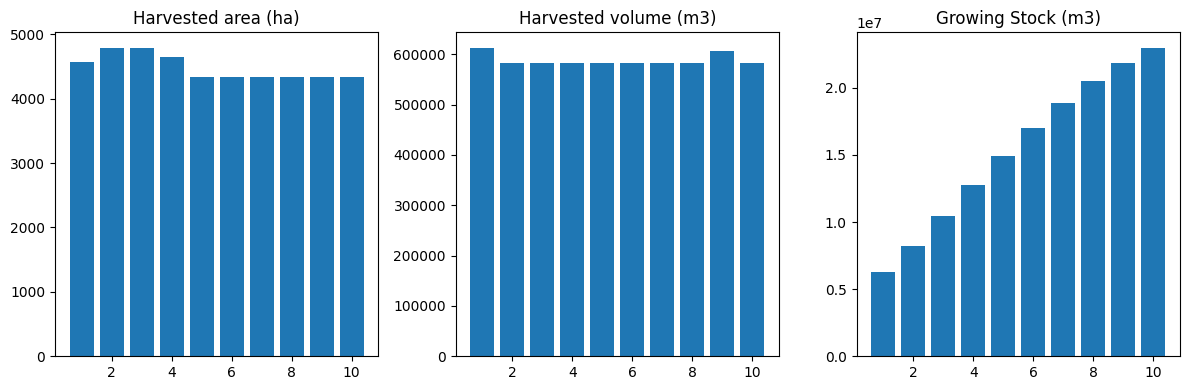

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_80%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  6213
The economic indicator (the provincial government revenues) is:  211883
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


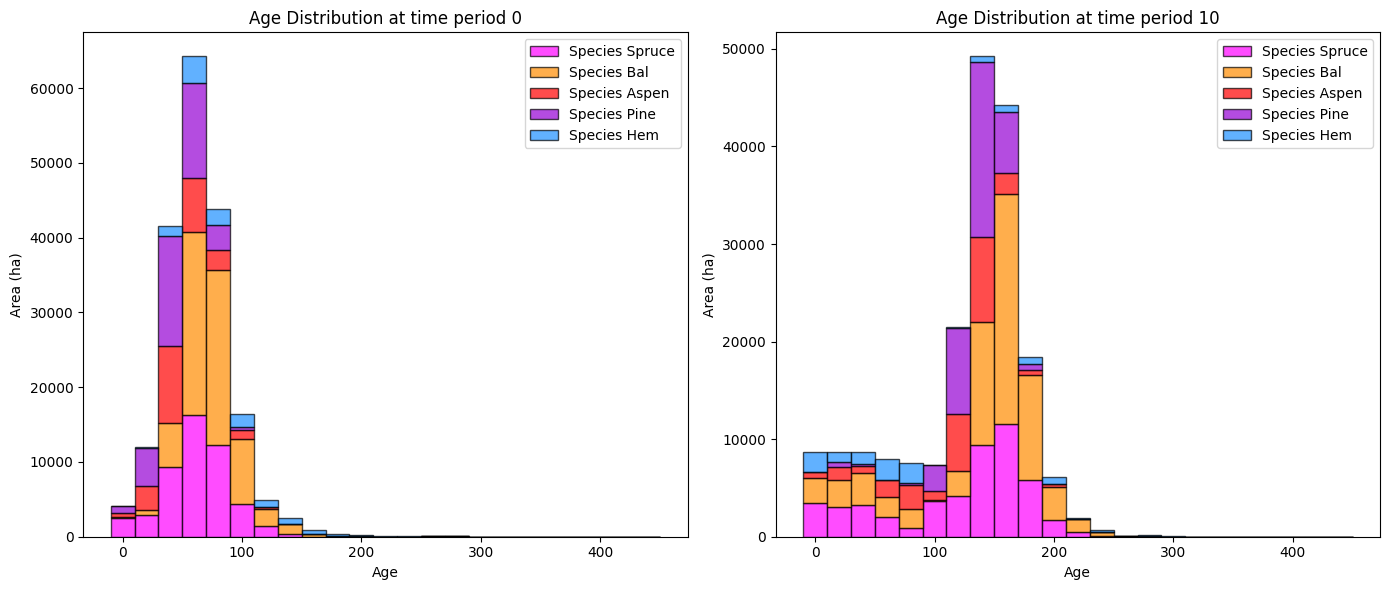

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   4915.394358   4912.685825
Bal     278.565372  10562.350438  10283.785066
Aspen   273.490478   7567.810555   7294.320077
Pine      0.000000   6842.645737   6842.645737
Hem     419.699331   1066.892542    647.193212

Overall diversity has **increased** by 29980.63 hectares from time period 0 to time period 10.


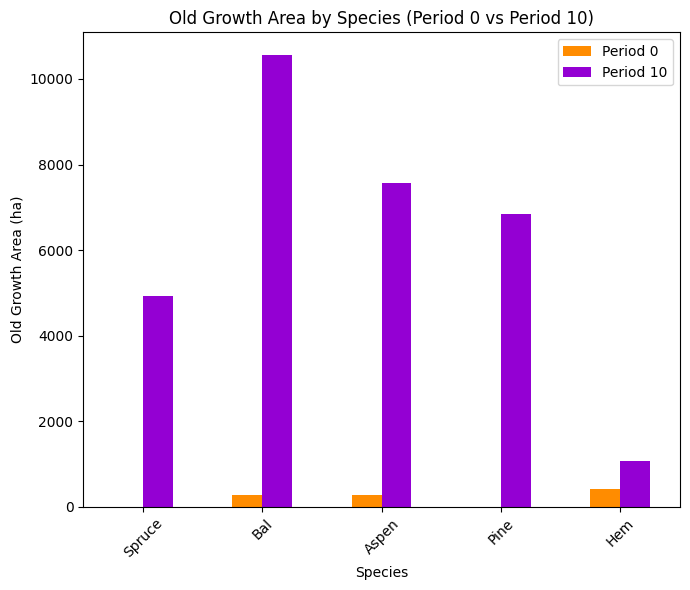

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_80%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2305
Bal: 0.3838
Aspen: 0.1308
Pine: 0.2155
Hem: 0.0395

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8886

Diversity has **decreased** by 5.70% from time 0 to time 10.


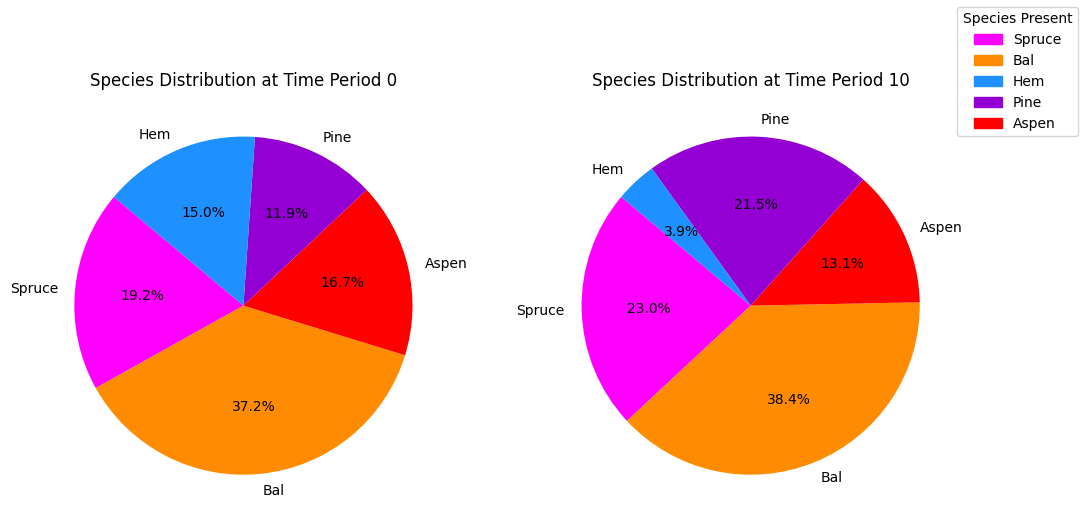

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_80%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.19s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

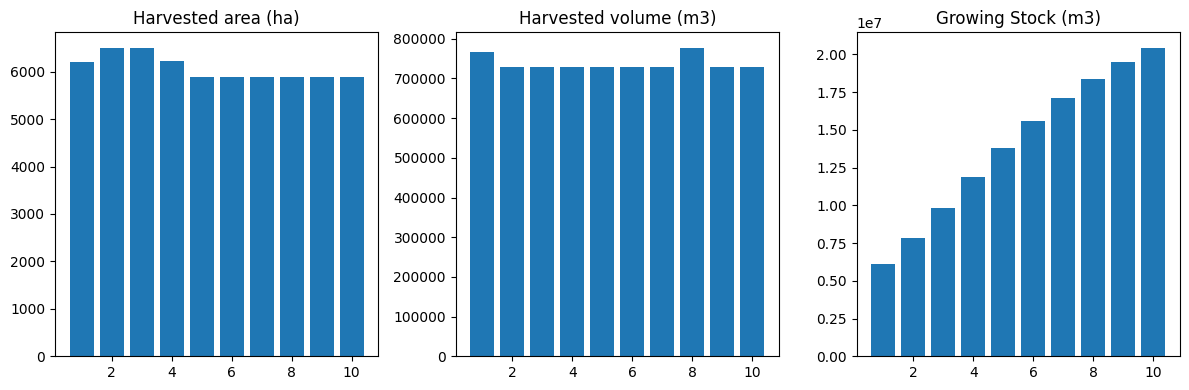

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


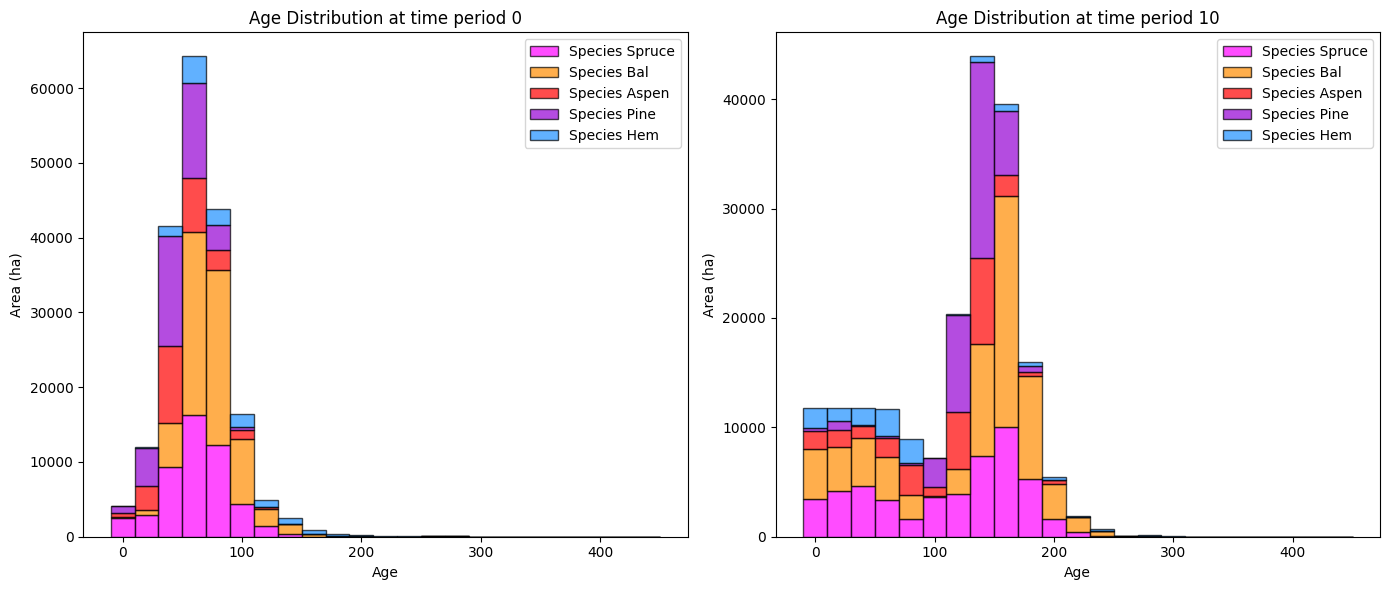

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


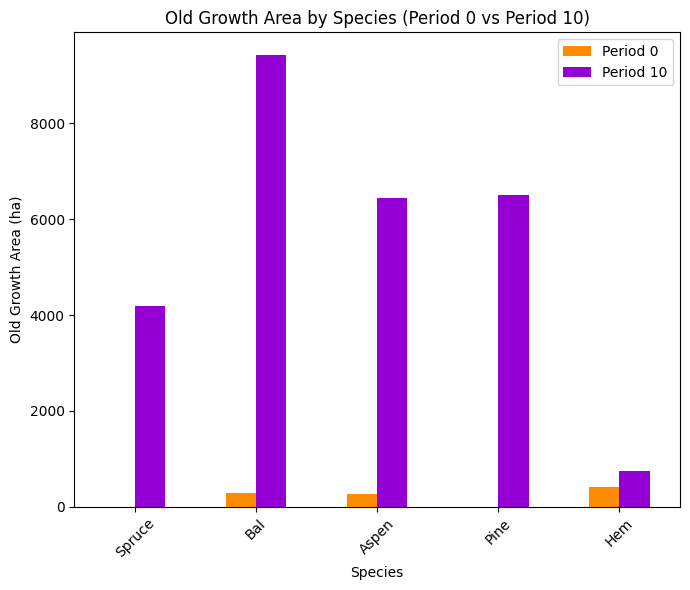

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


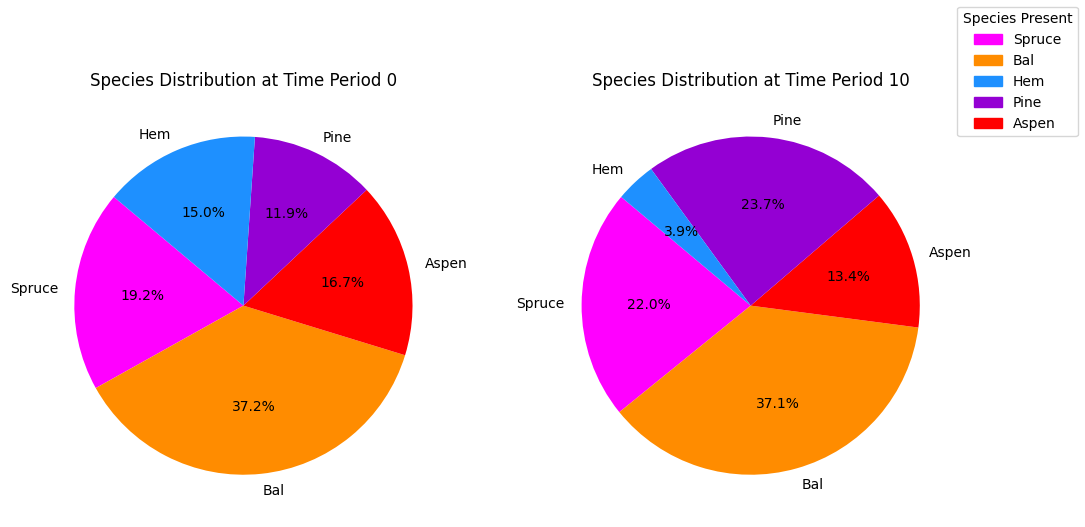

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


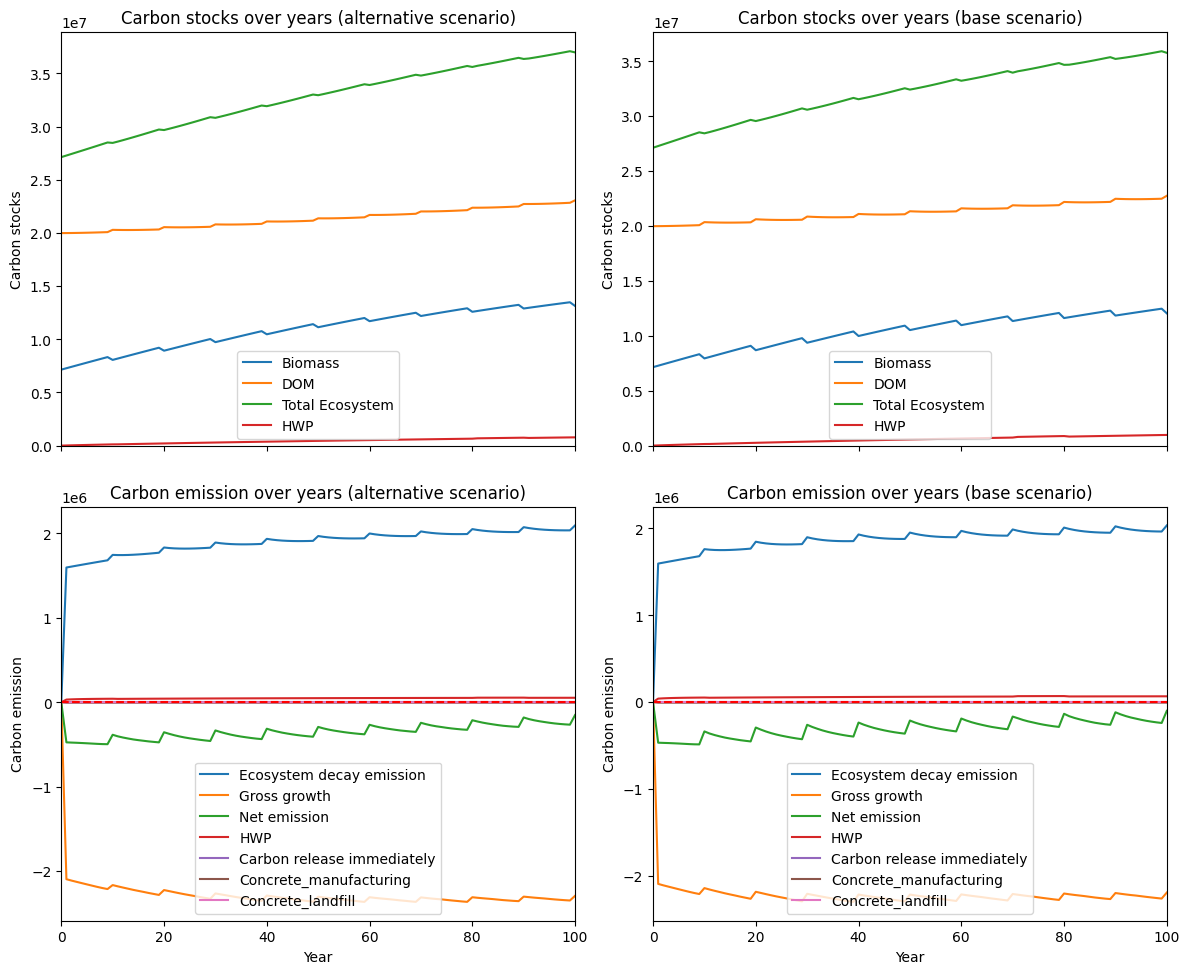

---------------------------------------------------------------------------------------
Net emission difference -640834.5845824921
Net emission base scenario -10712419.984448003
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  15.604650935802825
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0   731.448202   731.448202
Bal     0.0  1135.211777  1135.211777
Aspen   0.0  1118.287159  1118.287159
Pine    0.0   330.819672   330.819672
Hem     0.0   315.361348   315.361348

Overall, the old growth area has **increased** by 3631.13 hectares in the alternative scenario compared to the base scenario.


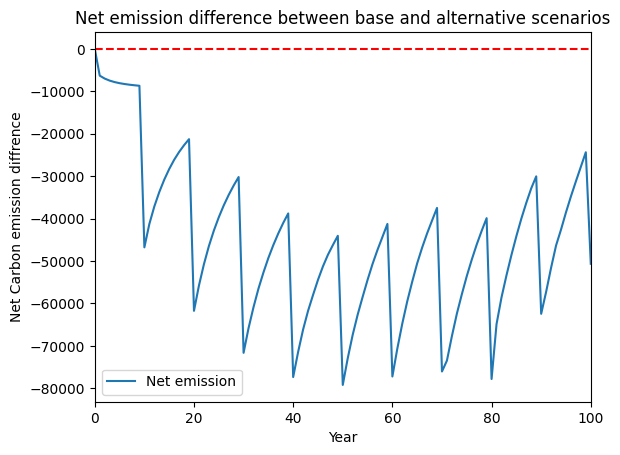

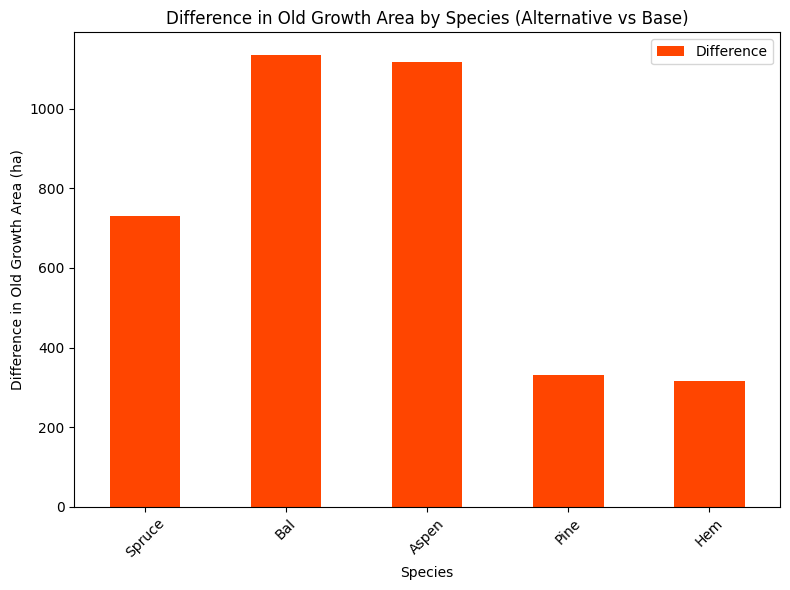

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


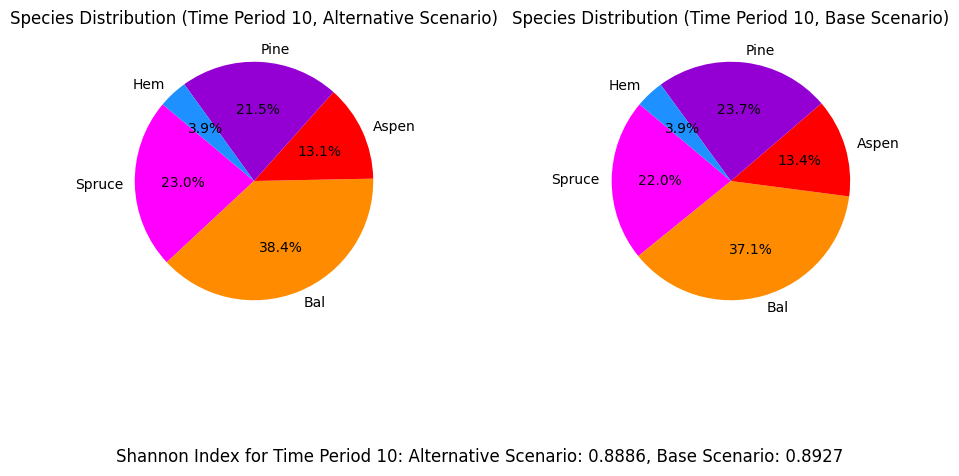

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_70%...
running the scenario for the Golden Bear mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xdc12fc48
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.16s
Presolved: 1911 rows, 32226 

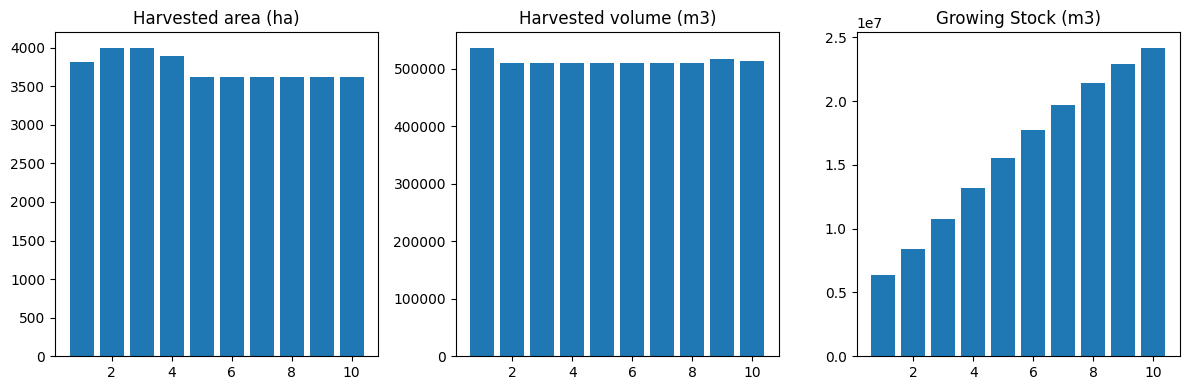

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_70%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  5426
The economic indicator (the provincial government revenues) is:  185047
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


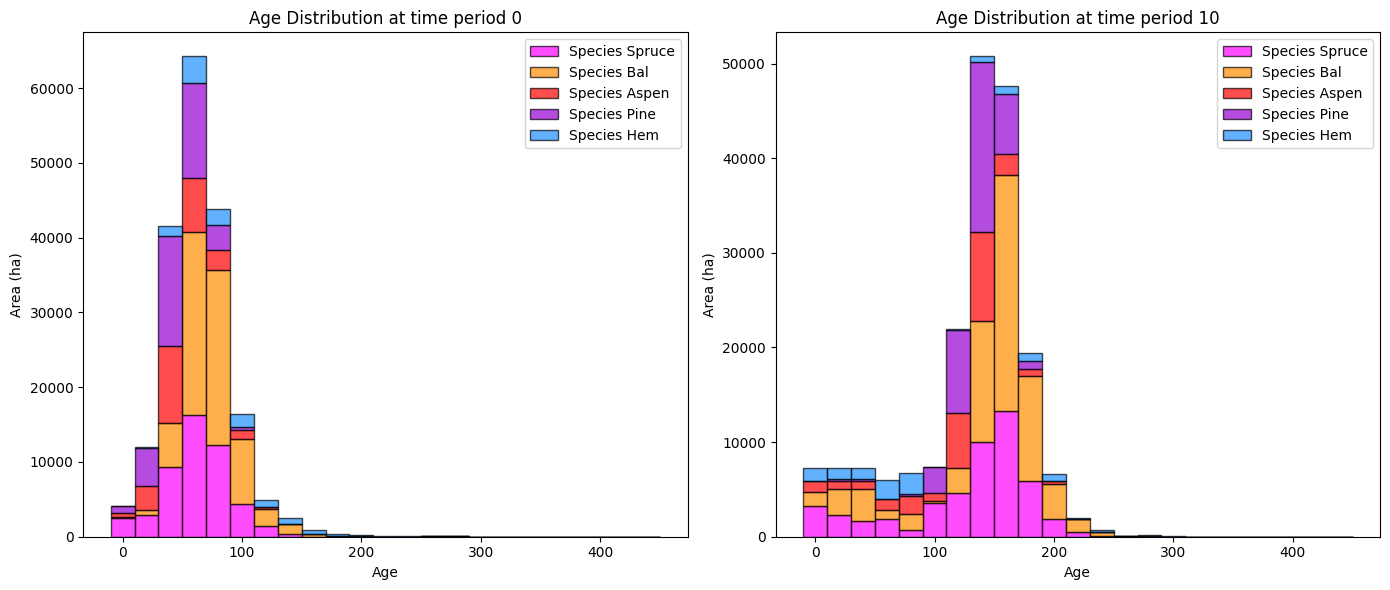

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5341.051597   5338.343063
Bal     278.565372  11508.976439  11230.411067
Aspen   273.490478   8331.468835   8057.978357
Pine      0.000000   7105.753142   7105.753142
Hem     419.699331   1143.808471    724.109140

Overall diversity has **increased** by 32456.59 hectares from time period 0 to time period 10.


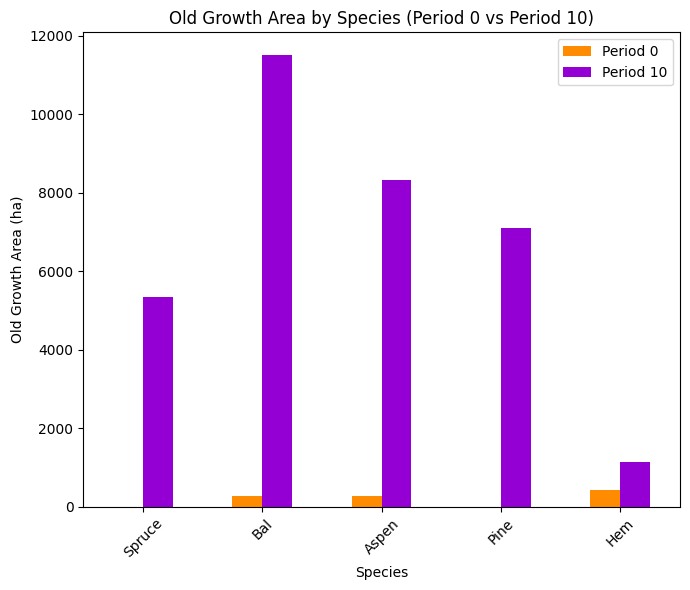

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_70%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2432
Bal: 0.3821
Aspen: 0.1271
Pine: 0.2070
Hem: 0.0406

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8883

Diversity has **decreased** by 5.72% from time 0 to time 10.


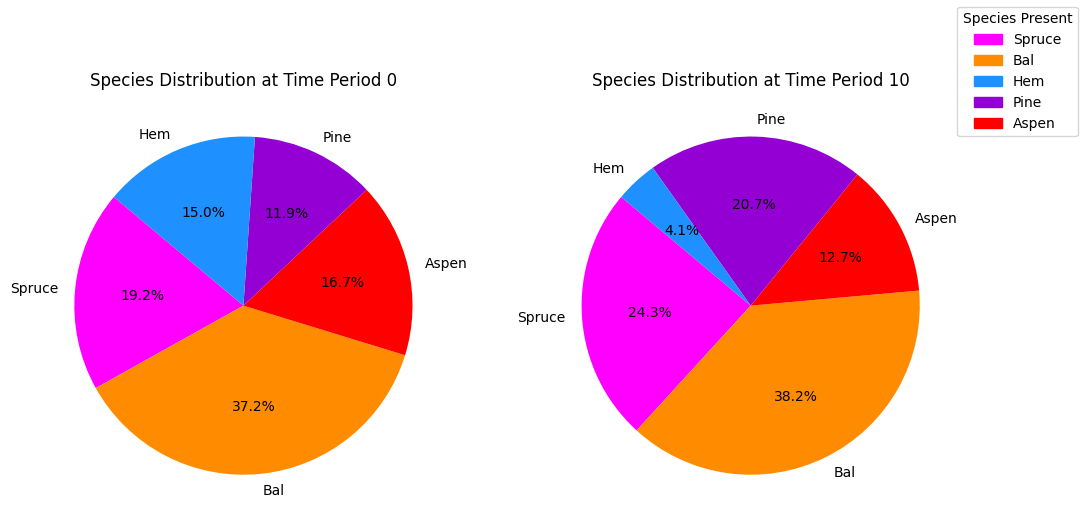

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_70%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.20s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

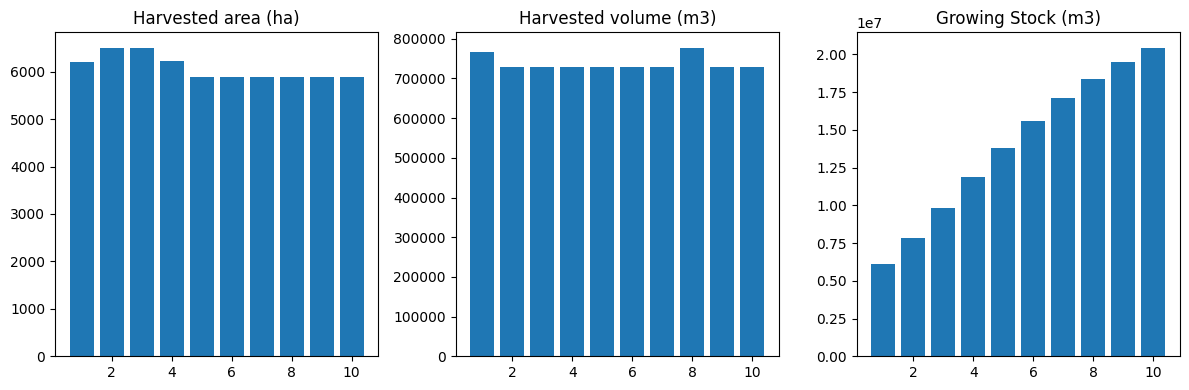

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


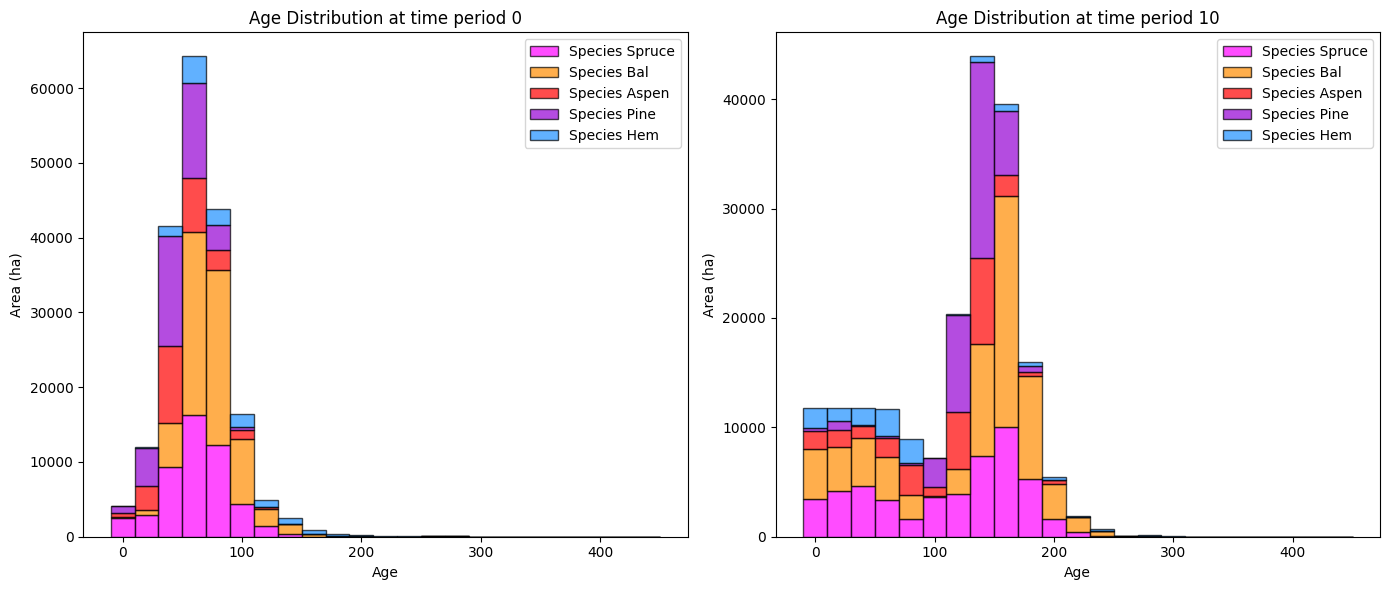

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


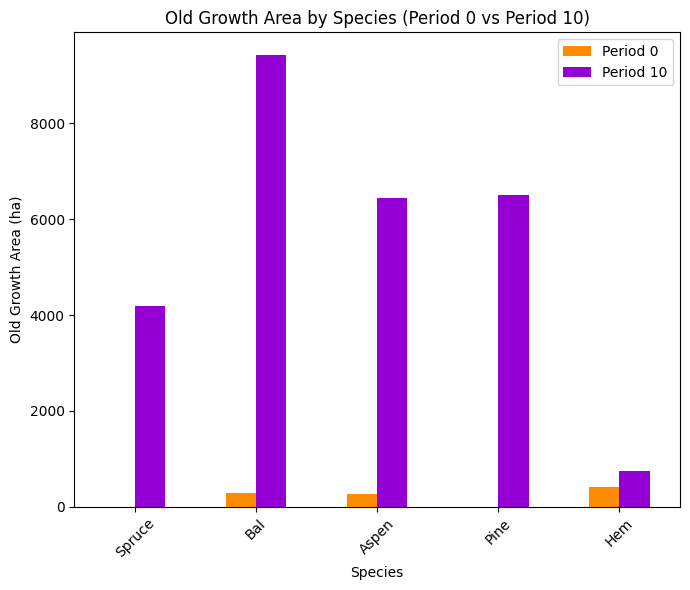

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


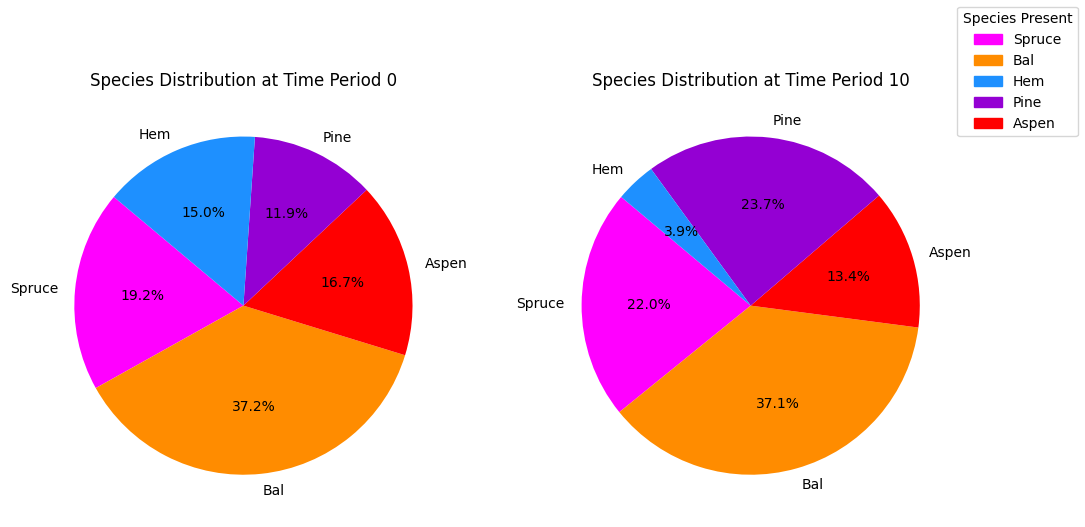

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


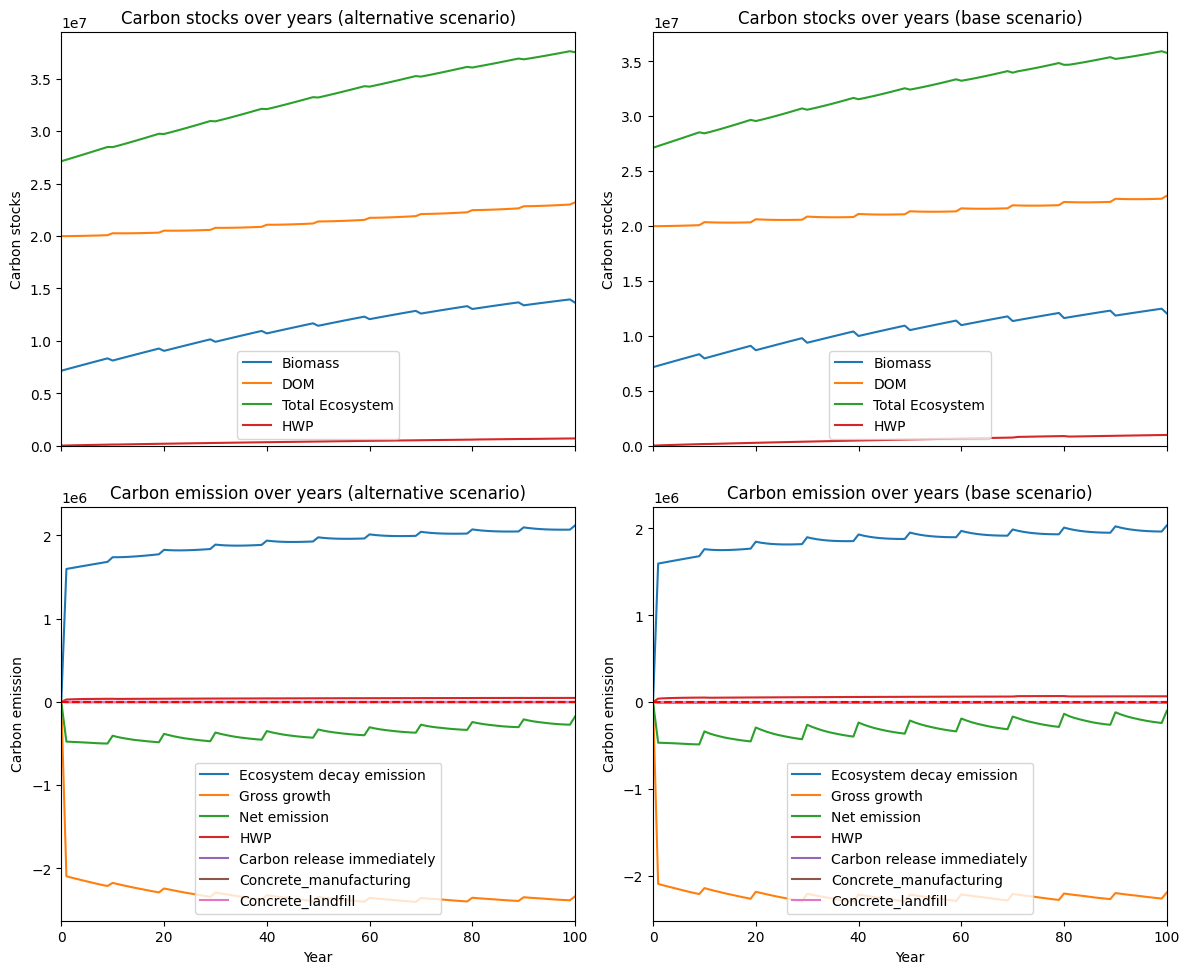

---------------------------------------------------------------------------------------
Net emission difference -953602.570743412
Net emission base scenario -11025187.970608922
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  10.486548911255738
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1157.105440  1157.105440
Bal     0.0  2081.837778  2081.837778
Aspen   0.0  1881.945440  1881.945440
Pine    0.0   593.927078   593.927078
Hem     0.0   392.277276   392.277276

Overall, the old growth area has **increased** by 6107.09 hectares in the alternative scenario compared to the base scenario.


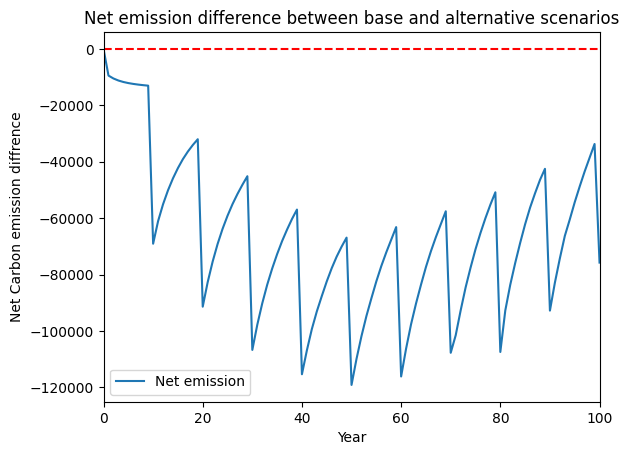

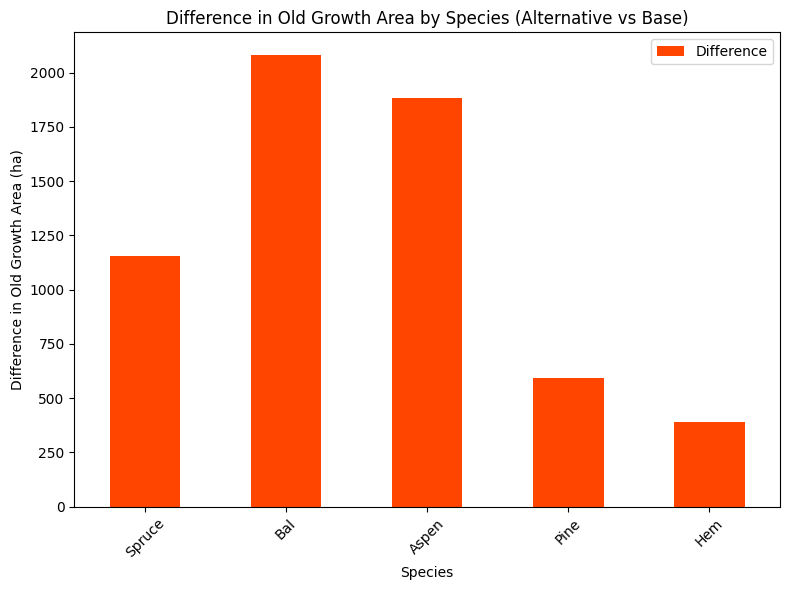

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


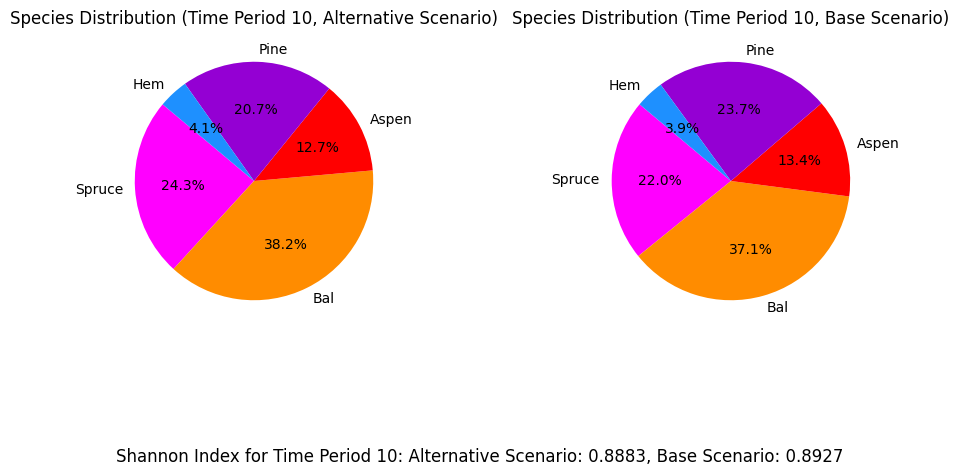

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_60%...
running the scenario for the Golden Bear mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x783b6ded
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.20s
Presolved: 1911 rows, 32226 

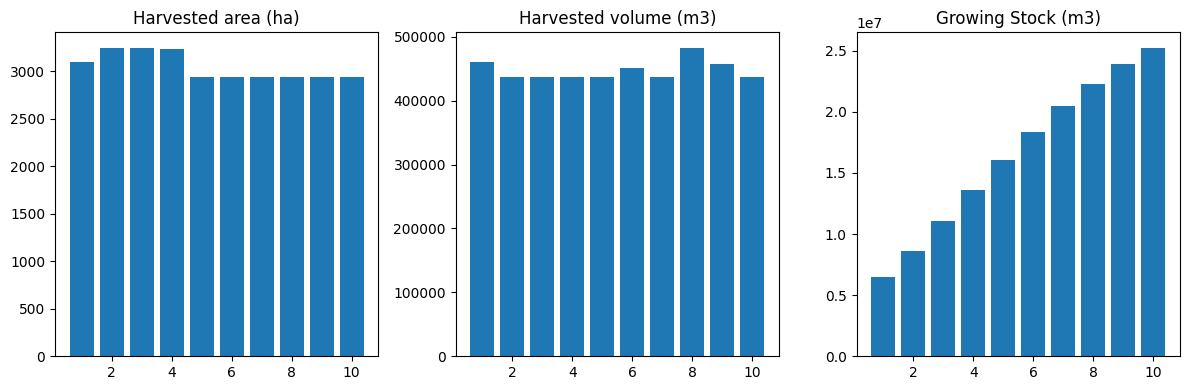

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_60%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  4726
The economic indicator (the provincial government revenues) is:  161180
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


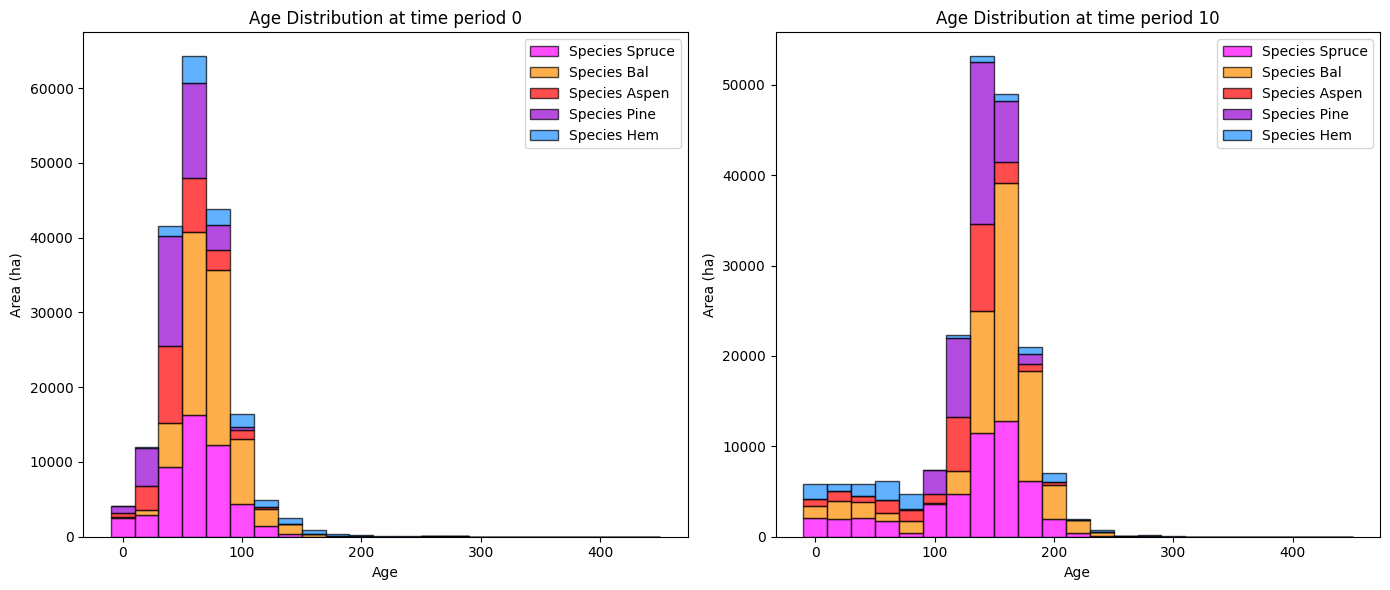

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5435.709671   5433.001137
Bal     278.565372  12108.102006  11829.536634
Aspen   273.490478   8780.570265   8507.079787
Pine      0.000000   7482.278925   7482.278925
Hem     419.699331   1257.348112    837.648782

Overall diversity has **increased** by 34089.55 hectares from time period 0 to time period 10.


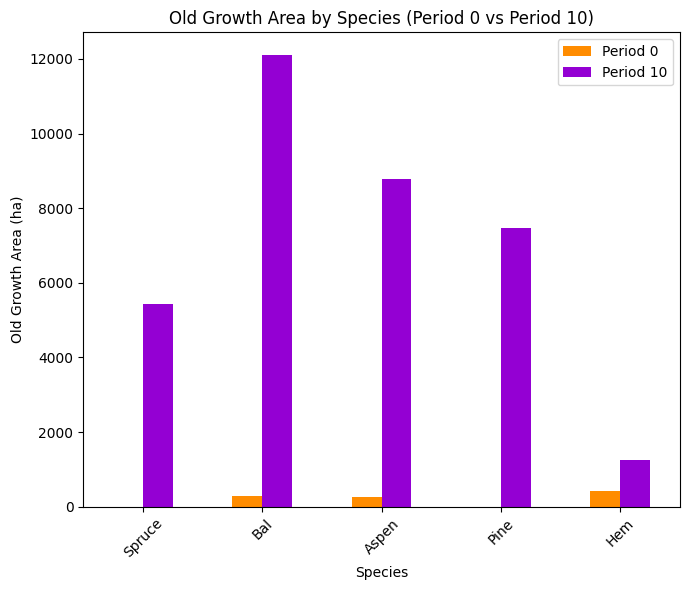

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_60%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2458
Bal: 0.3889
Aspen: 0.1224
Pine: 0.2015
Hem: 0.0415

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8848

Diversity has **decreased** by 6.07% from time 0 to time 10.


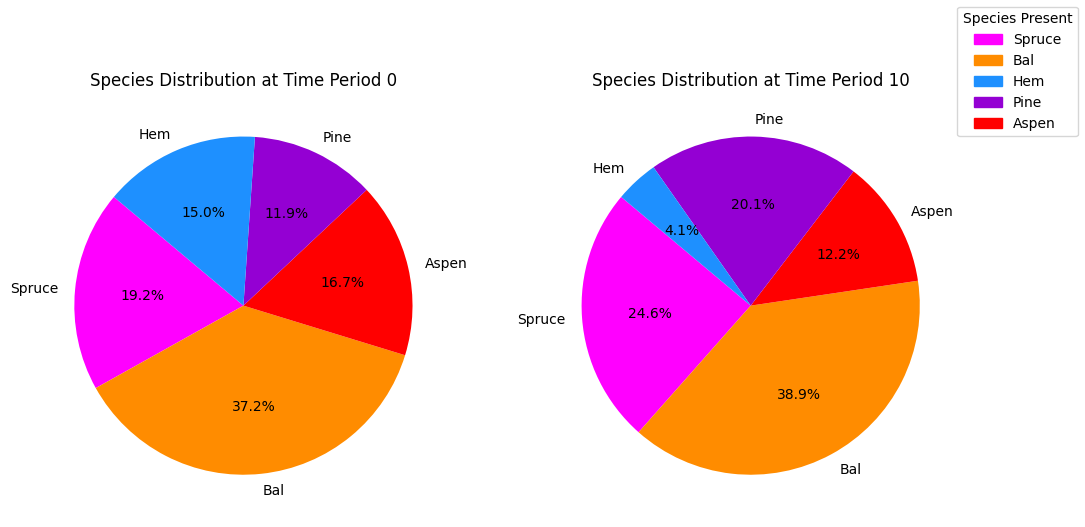

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_60%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.21s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

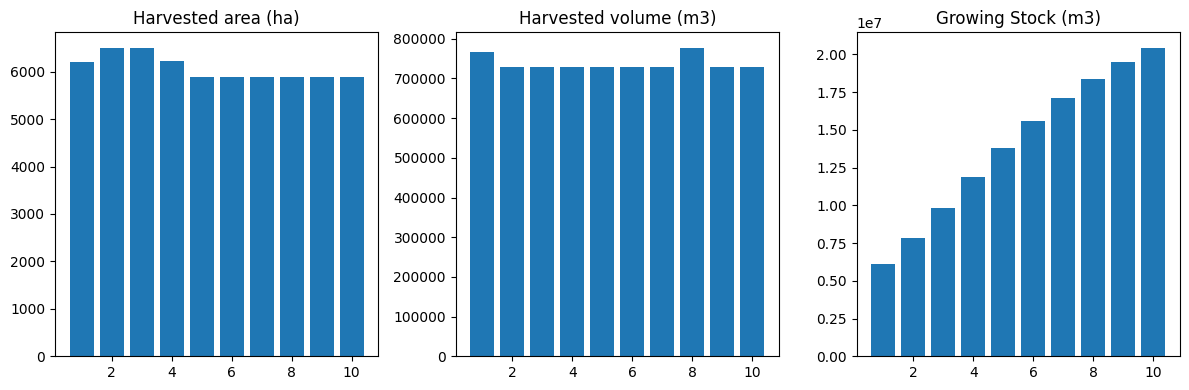

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


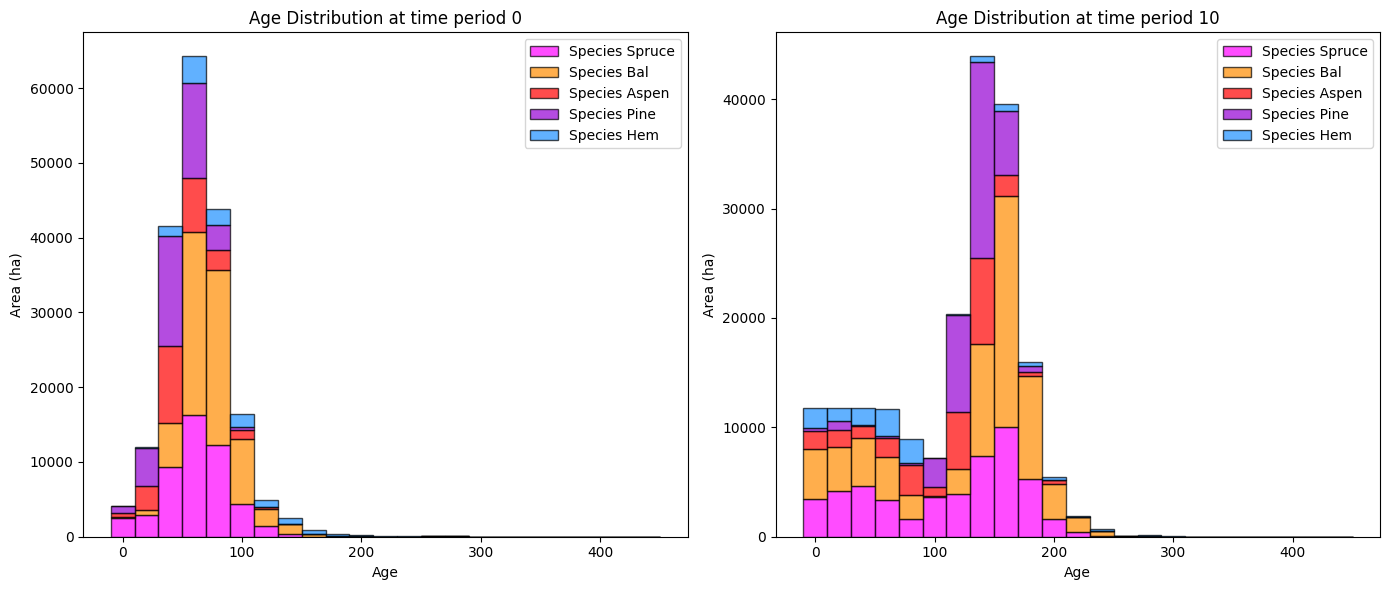

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


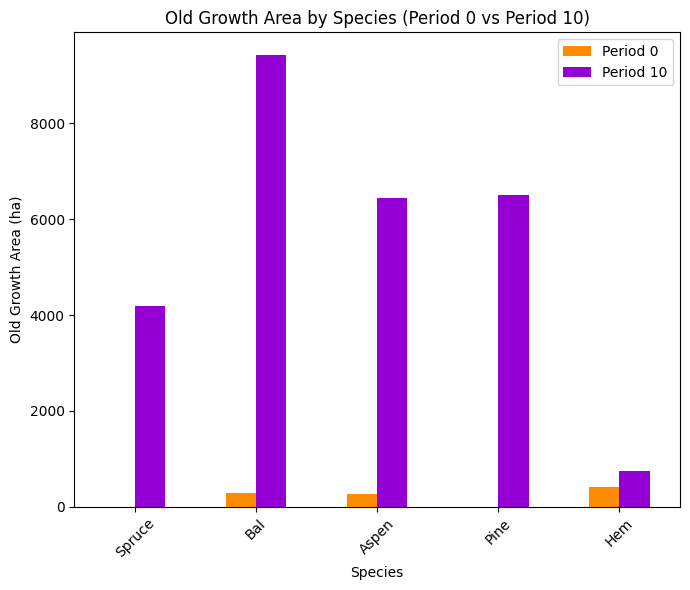

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


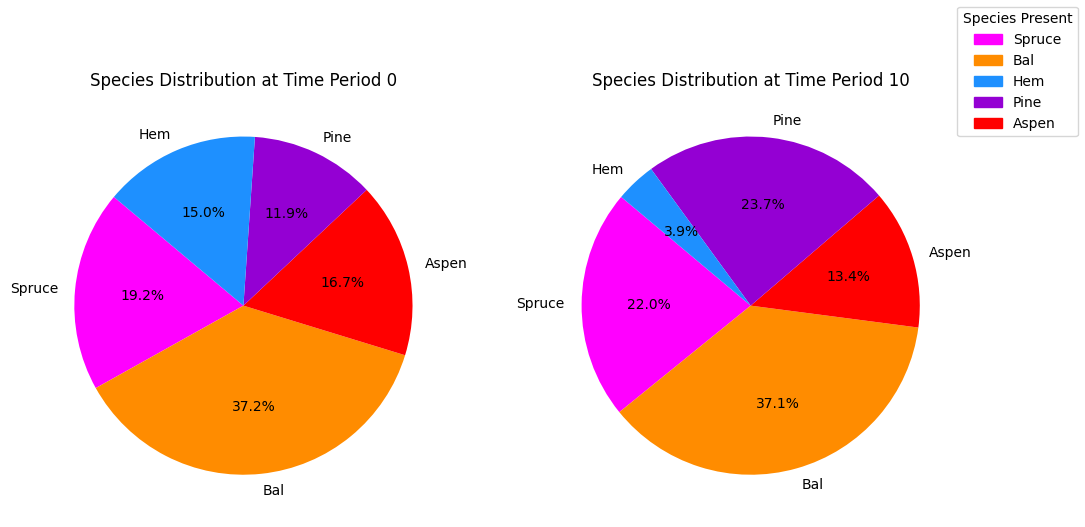

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


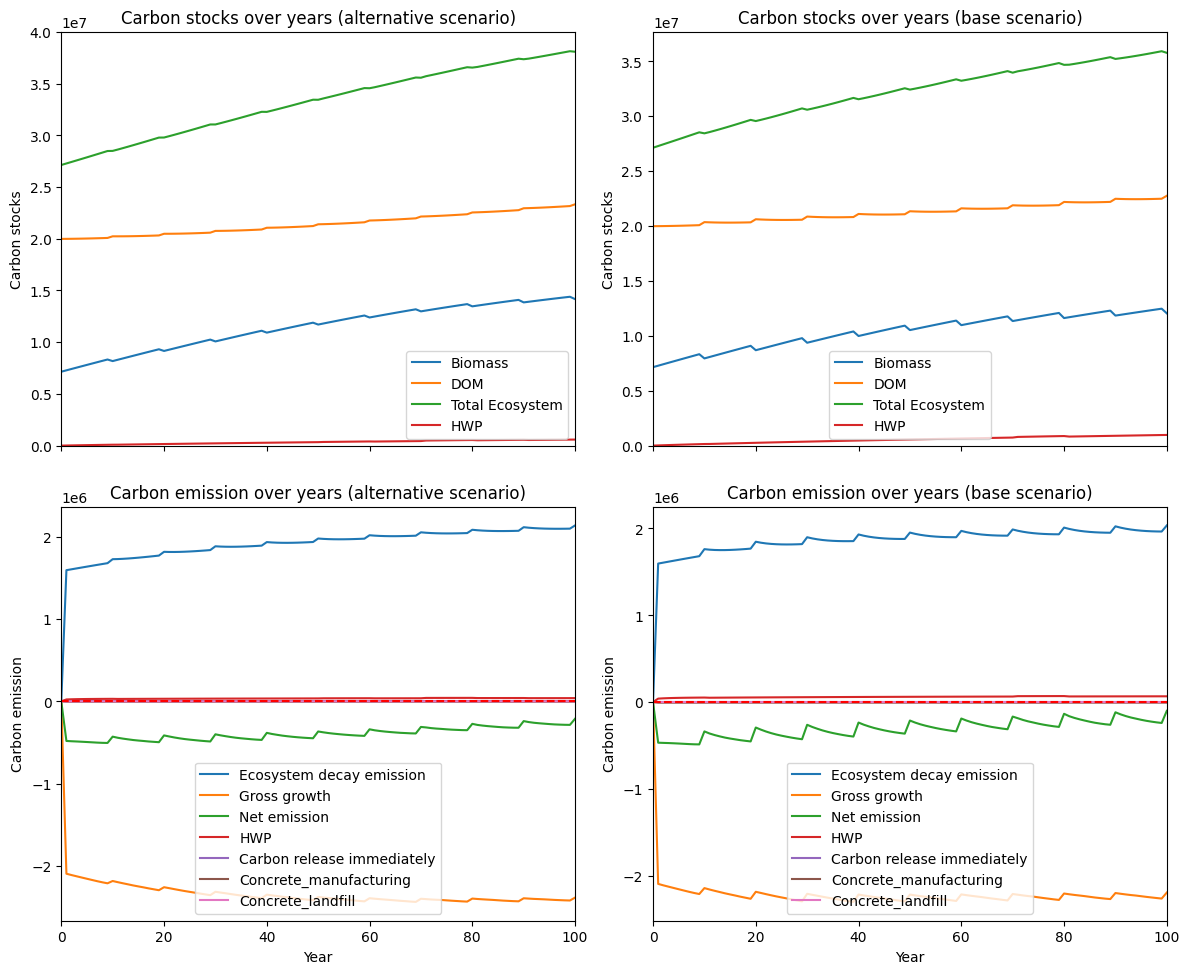

---------------------------------------------------------------------------------------
Net emission difference -1254232.3969588722
Net emission base scenario -11325817.796824384
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  7.973004065472176
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  1251.763514  1251.763514
Bal     0.0  2680.963345  2680.963345
Aspen   0.0  2331.046870  2331.046870
Pine    0.0   970.452861   970.452861
Hem     0.0   505.816918   505.816918

Overall, the old growth area has **increased** by 7740.04 hectares in the alternative scenario compared to the base scenario.


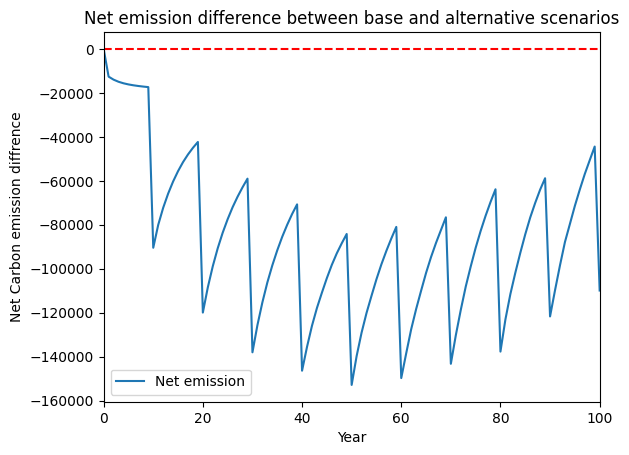

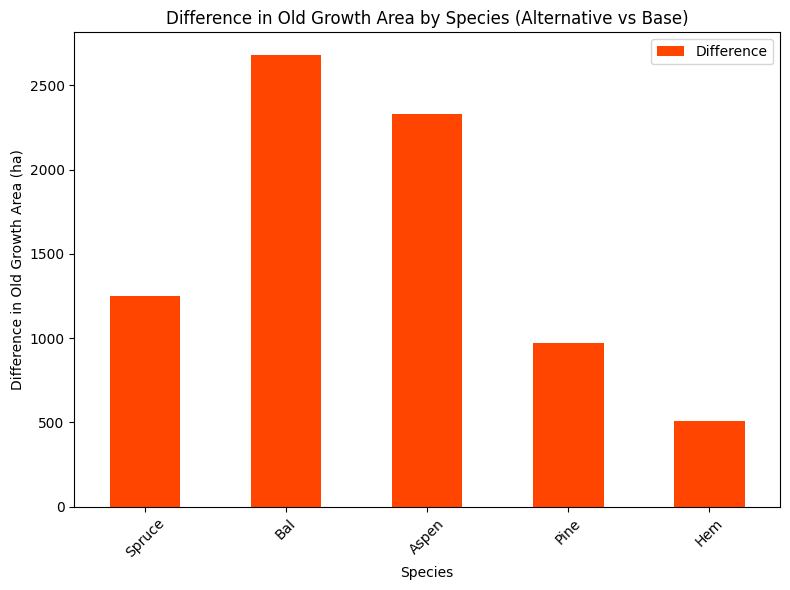

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


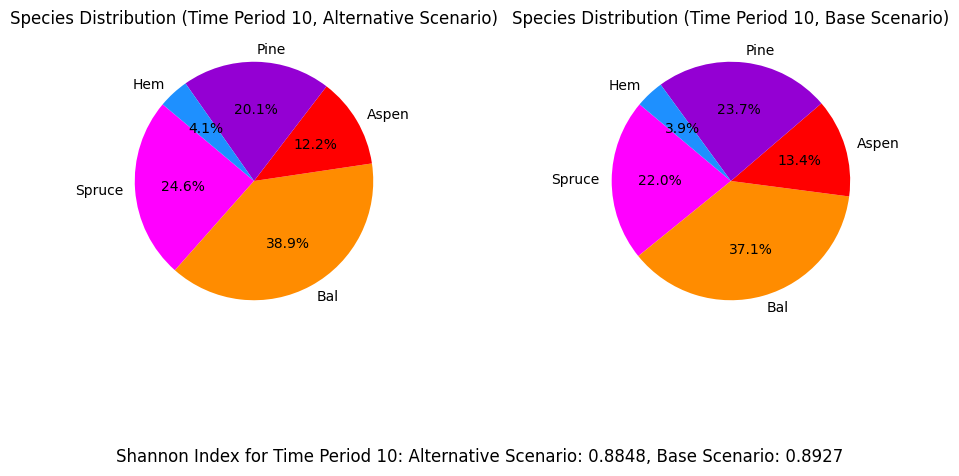

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_50%...
running the scenario for the Golden Bear mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xd0a9ea1e
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.24s
Presolved: 1911 rows, 32226 

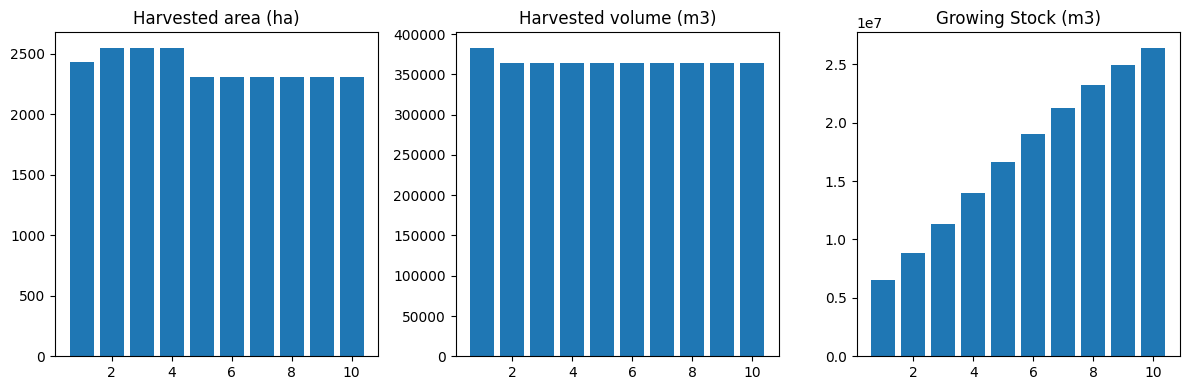

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_50%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3867
The economic indicator (the provincial government revenues) is:  131881
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


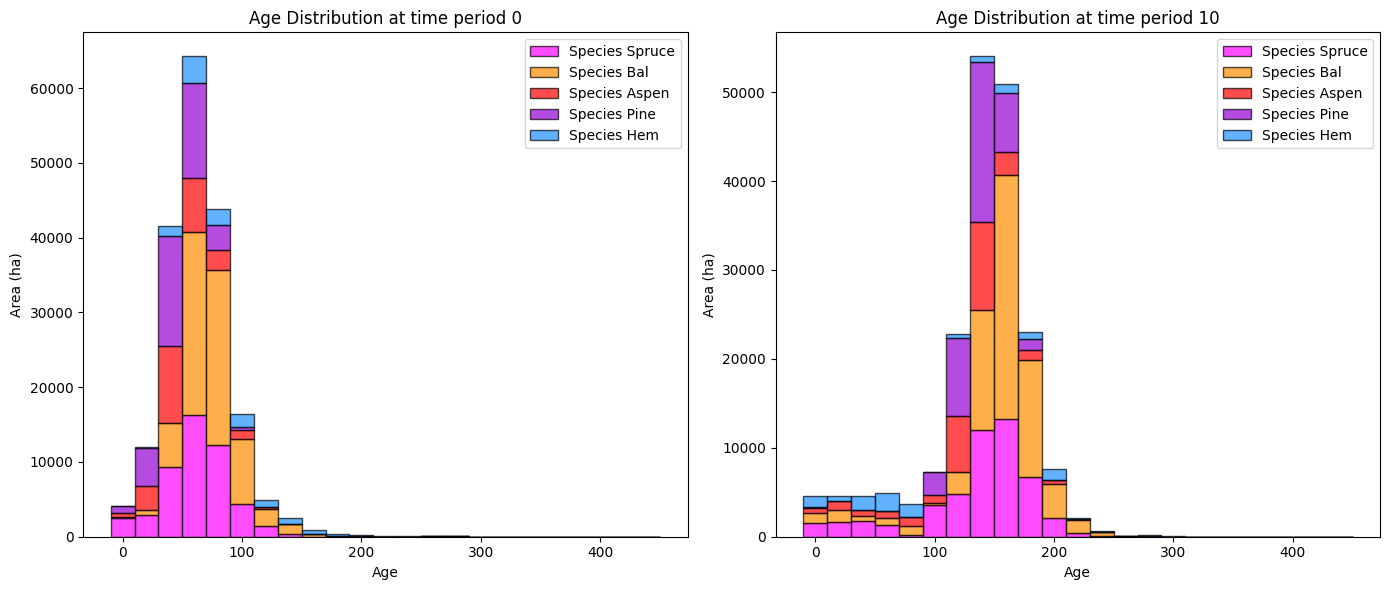

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   5878.167261   5875.458727
Bal     278.565372  13316.418240  13037.852868
Aspen   273.490478   9641.724255   9368.233777
Pine      0.000000   7577.677029   7577.677029
Hem     419.699331   1459.085409   1039.386079

Overall diversity has **increased** by 36898.61 hectares from time period 0 to time period 10.


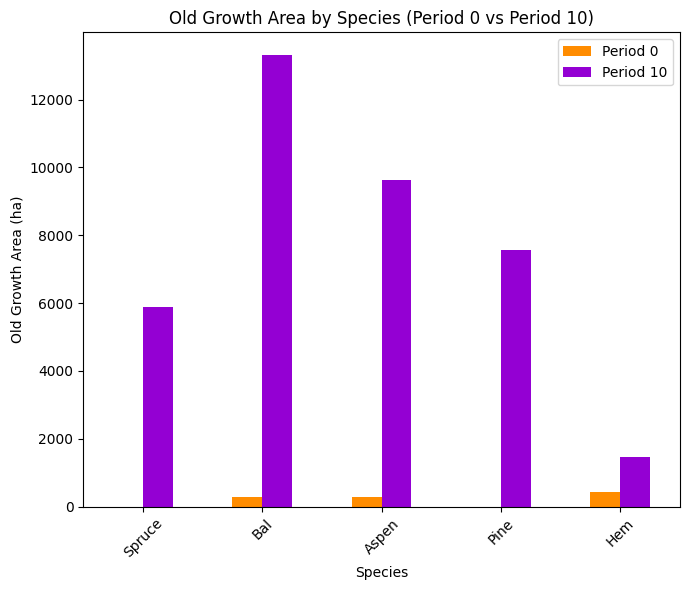

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_50%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2487
Bal: 0.3926
Aspen: 0.1225
Pine: 0.1931
Hem: 0.0430

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8843

Diversity has **decreased** by 6.12% from time 0 to time 10.


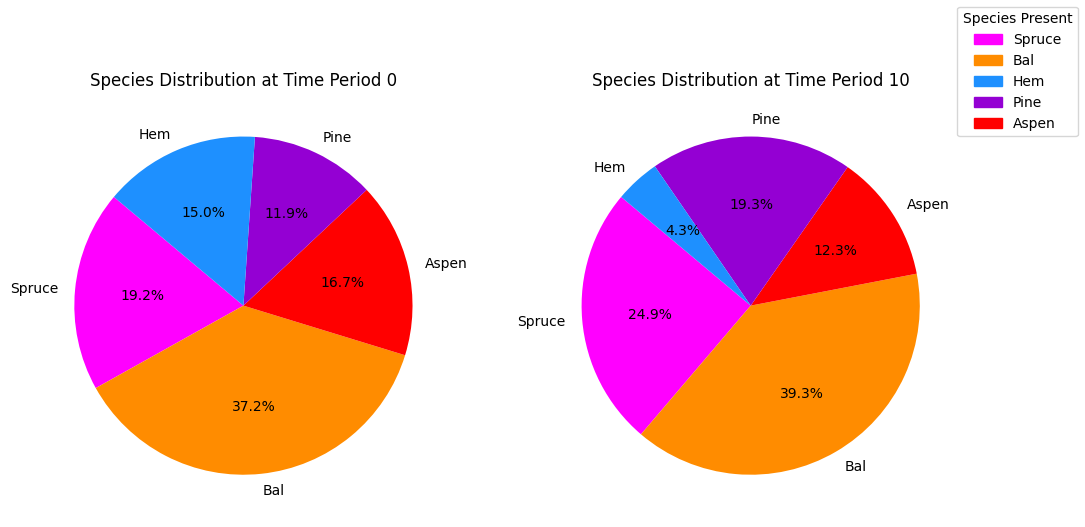

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_50%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.17s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

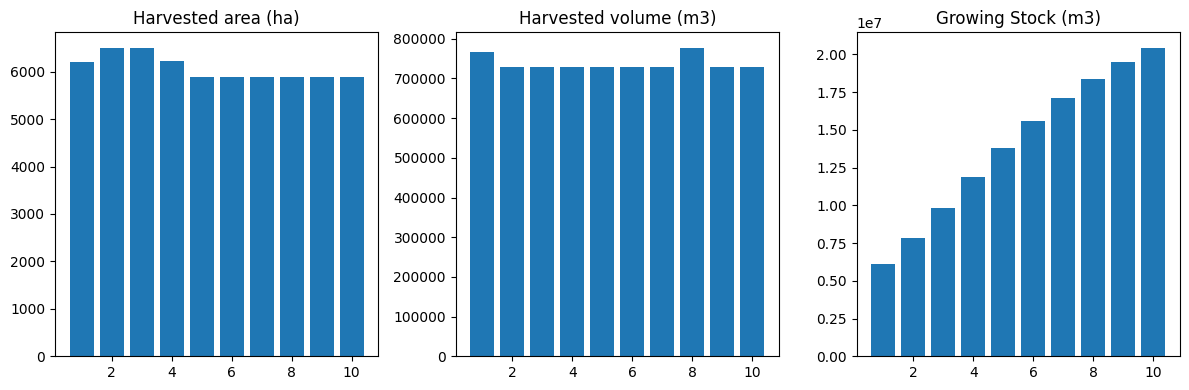

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


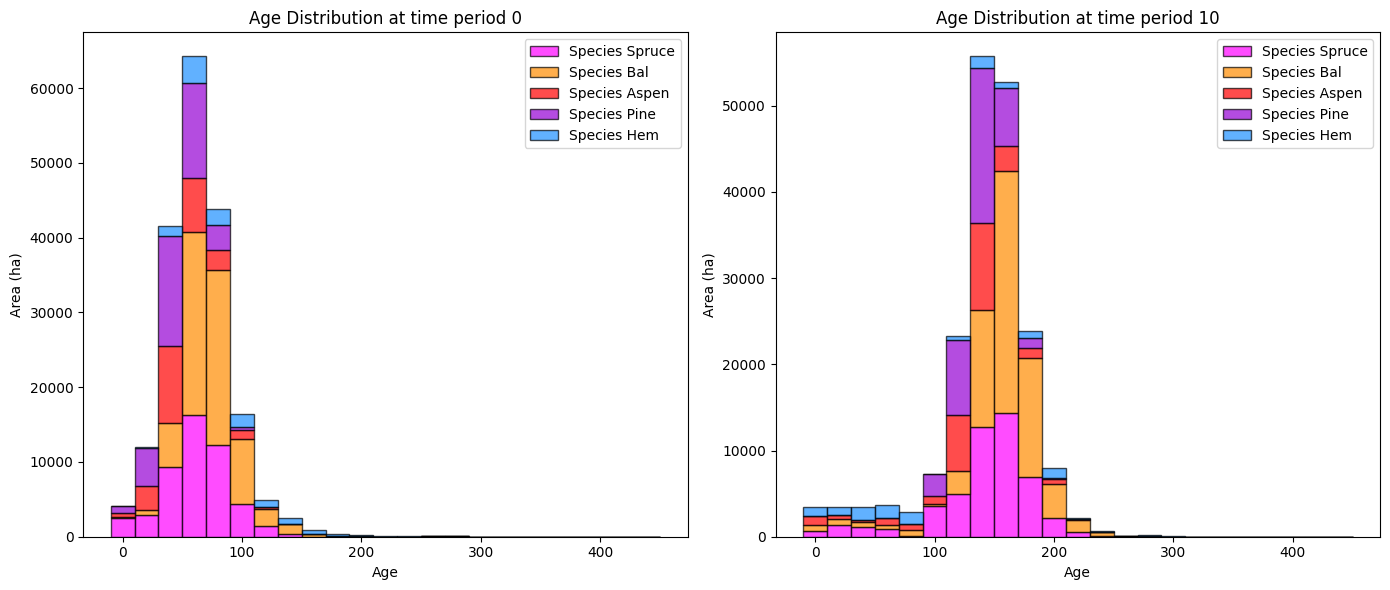

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6457.218580   6454.510047
Bal     278.565372  13811.648105  13533.082733
Aspen   273.490478  10611.398243  10337.907765
Pine      0.000000   7624.792624   7624.792624
Hem     419.699331   1499.652633   1079.953303

Overall diversity has **increased** by 39030.25 hectares from time period 0 to time period 10.


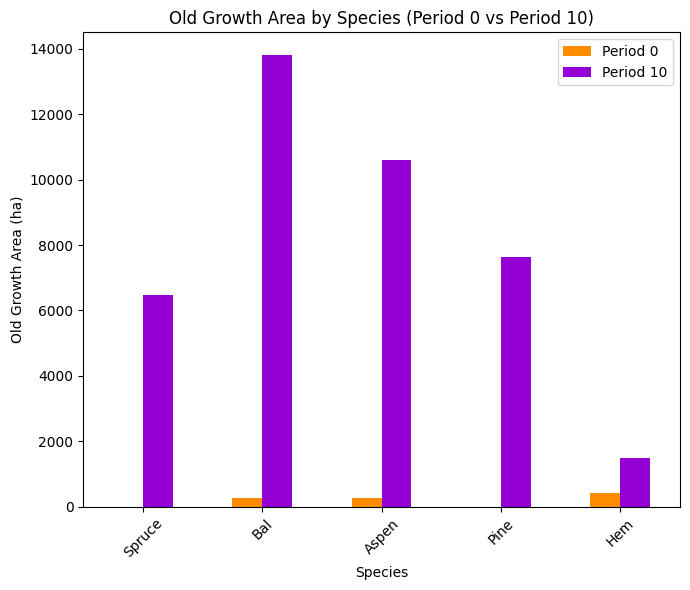

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2581
Bal: 0.3877
Aspen: 0.1224
Pine: 0.1858
Hem: 0.0460

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8875

Diversity has **decreased** by 5.80% from time 0 to time 10.


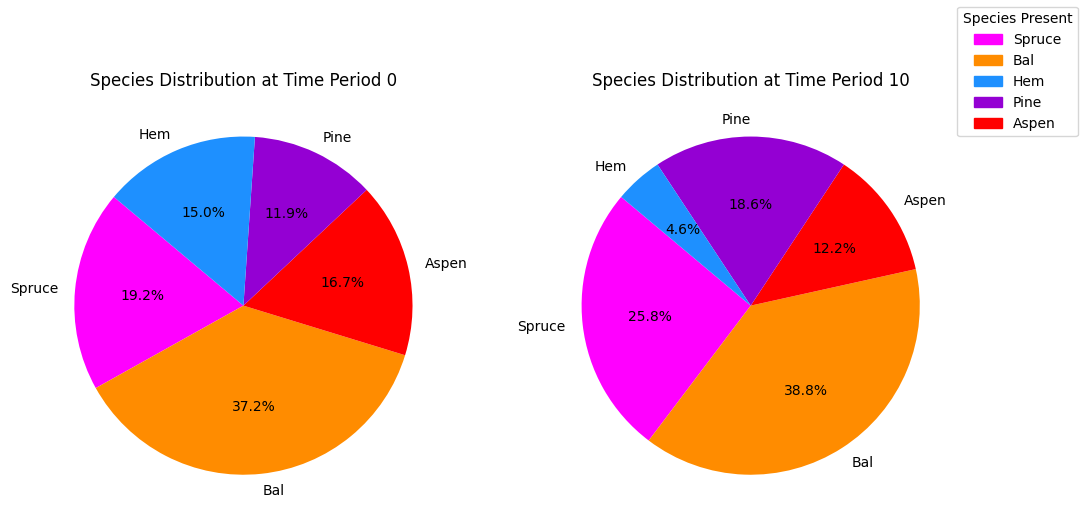

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

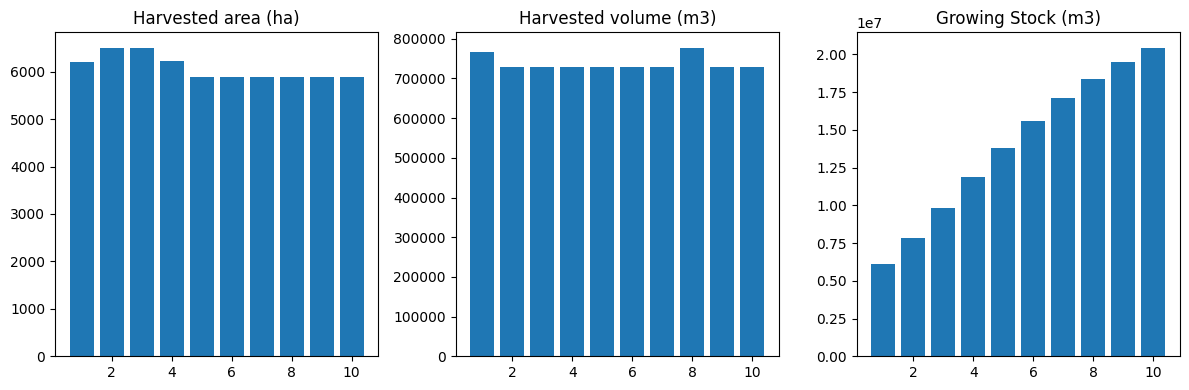

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


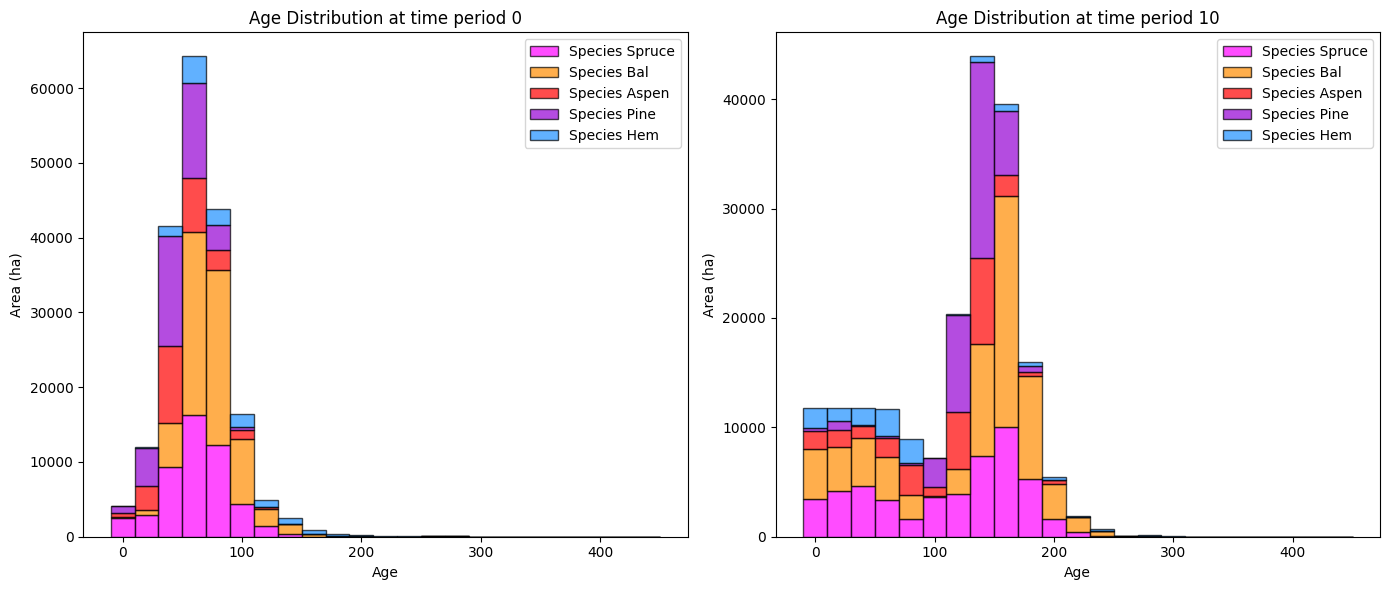

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


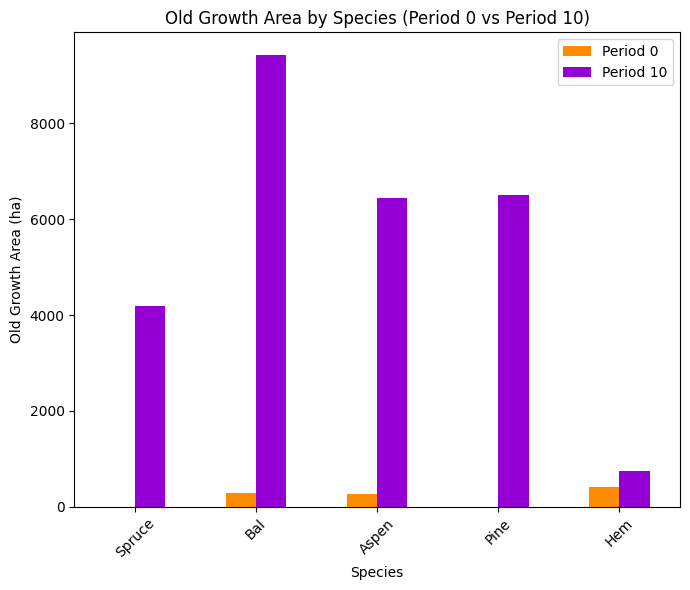

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


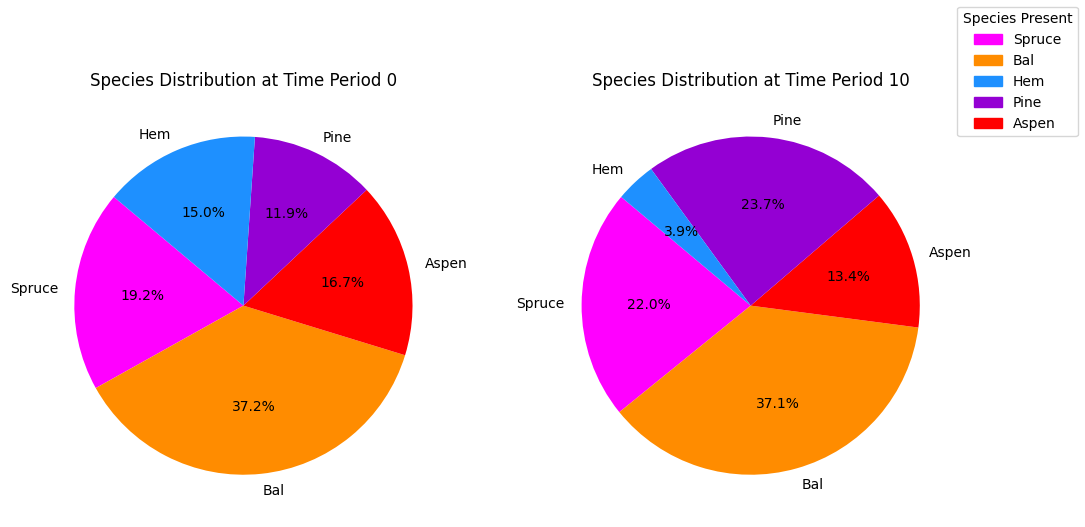

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


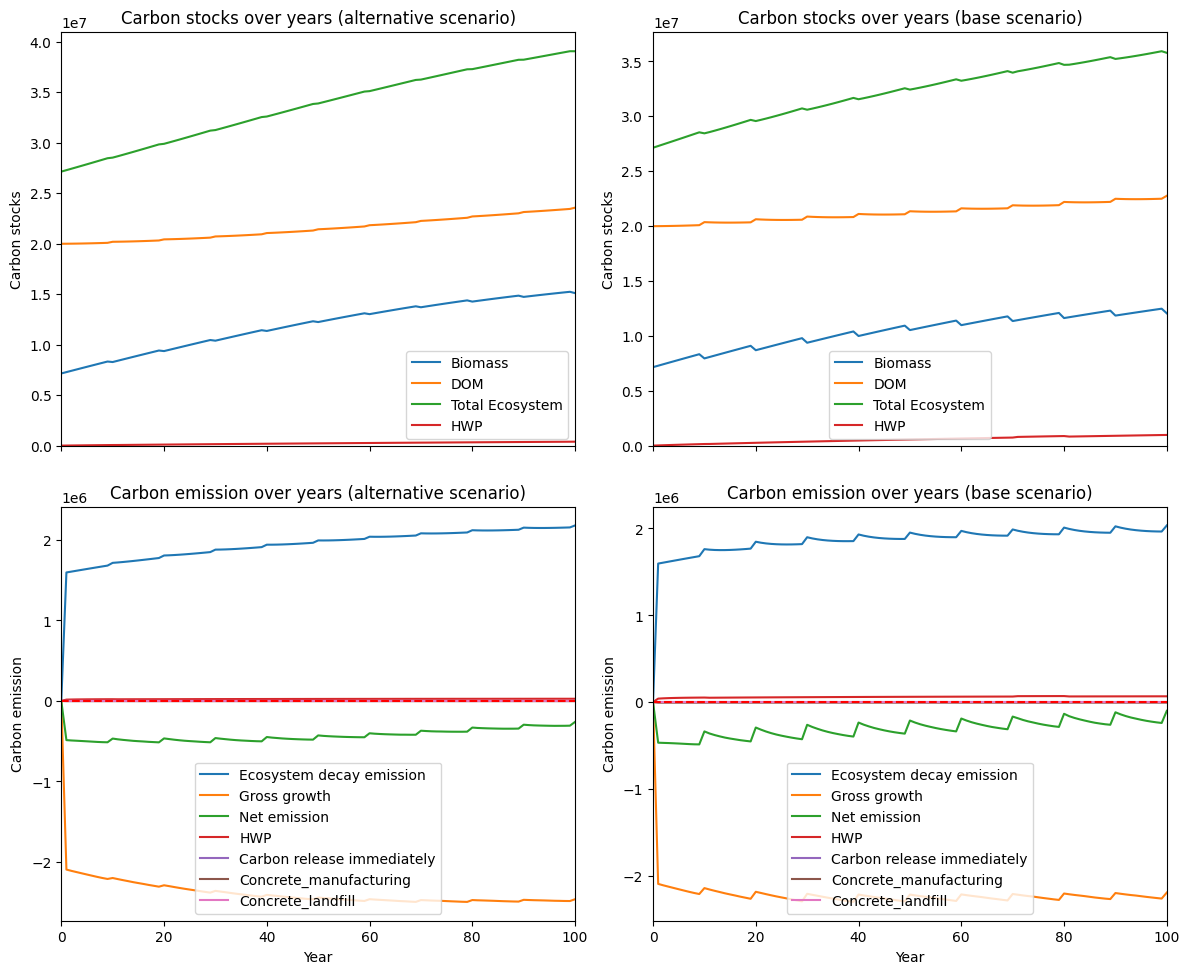

---------------------------------------------------------------------------------------
Net emission difference -1813938.2422376098
Net emission base scenario -11885523.64210312
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  5.512866848026951
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2273.272424  2273.272424
Bal     0.0  4384.509444  4384.509444
Aspen   0.0  4161.874847  4161.874847
Pine    0.0  1112.966559  1112.966559
Hem     0.0   748.121439   748.121439

Overall, the old growth area has **increased** by 12680.74 hectares in the alternative scenario compared to the base scenario.


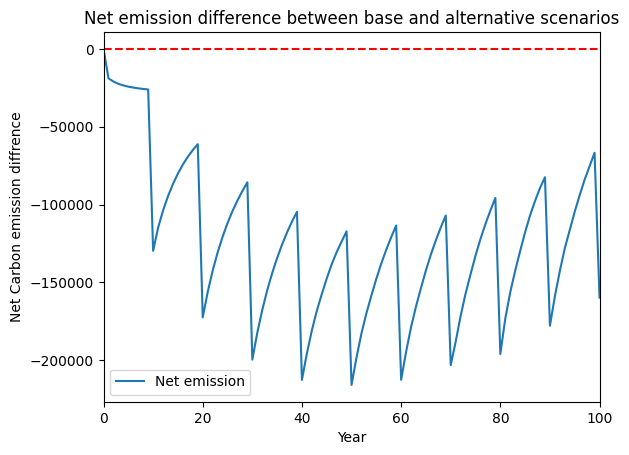

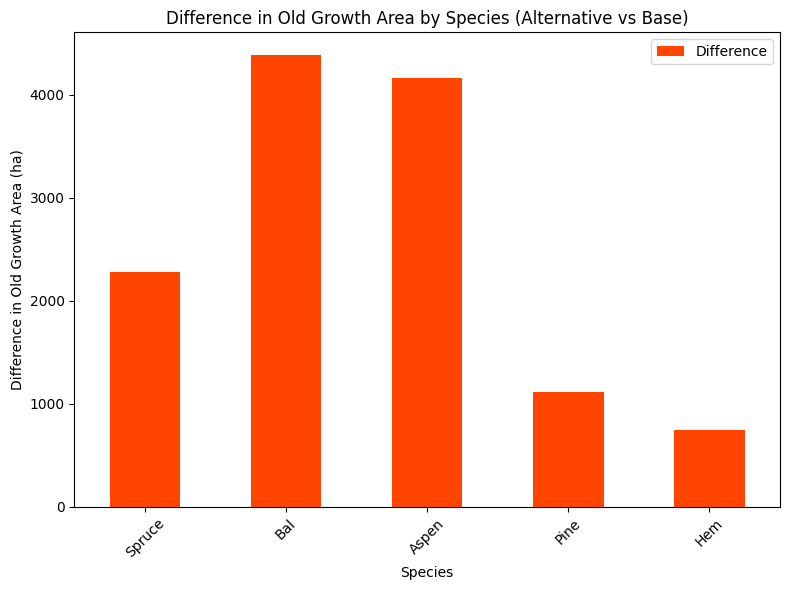

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


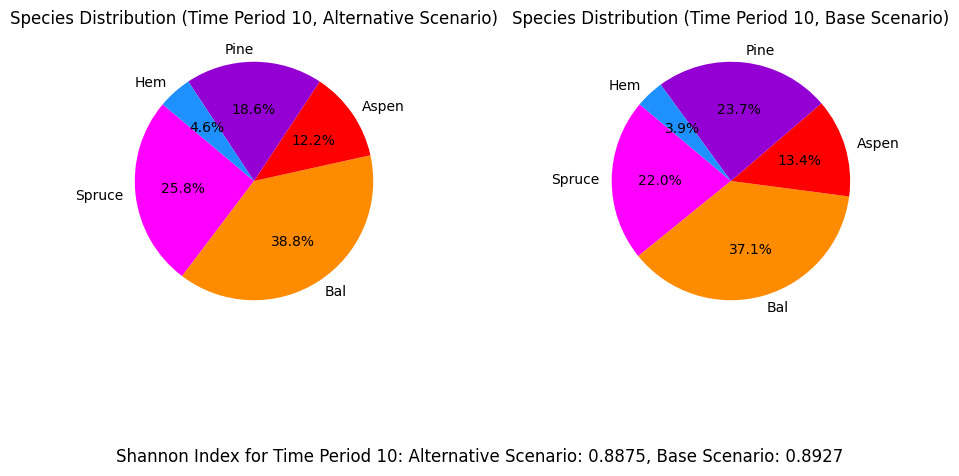

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_30%...
running the scenario for the Golden Bear mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x3a744025
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.17s
Presolved: 1911 rows, 32226 

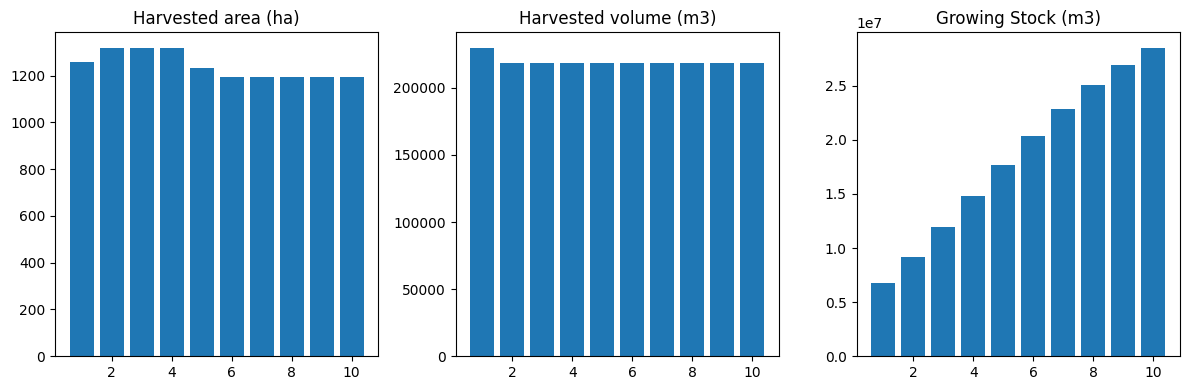

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_30%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  2320
The economic indicator (the provincial government revenues) is:  79128
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


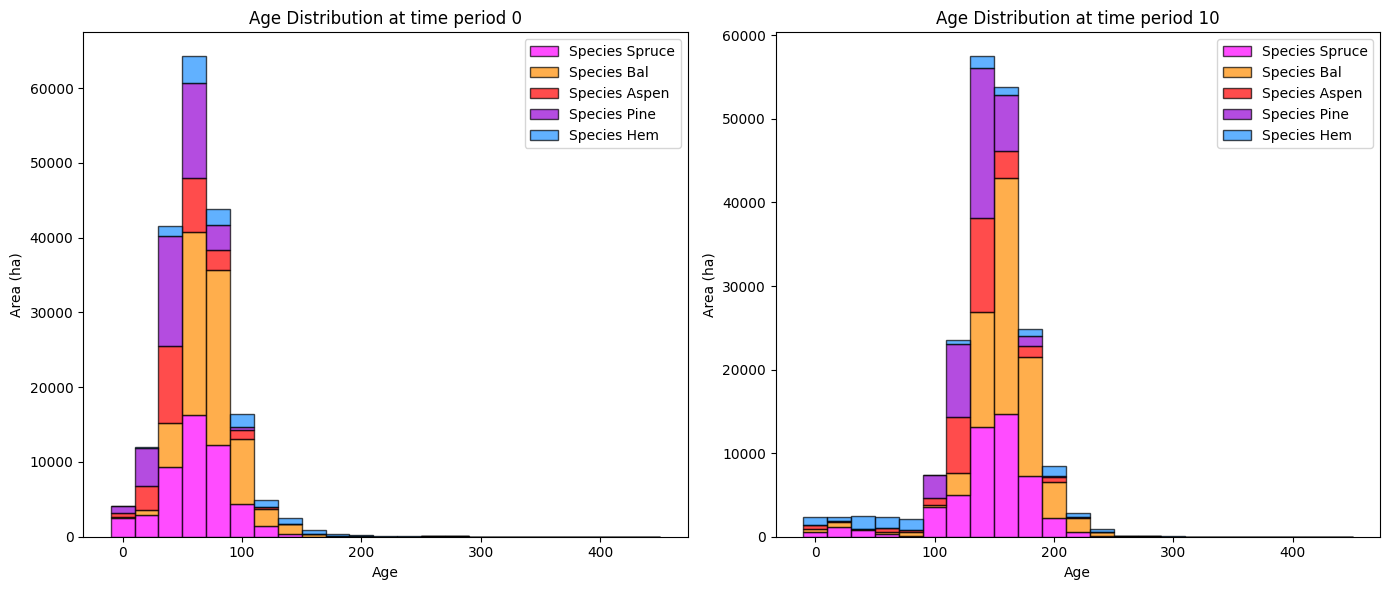

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6906.304600   6903.596066
Bal     278.565372  14649.119171  14370.553799
Aspen   273.490478  11948.339062  11674.848584
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   1957.558344   1537.859013

Overall diversity has **increased** by 42118.74 hectares from time period 0 to time period 10.


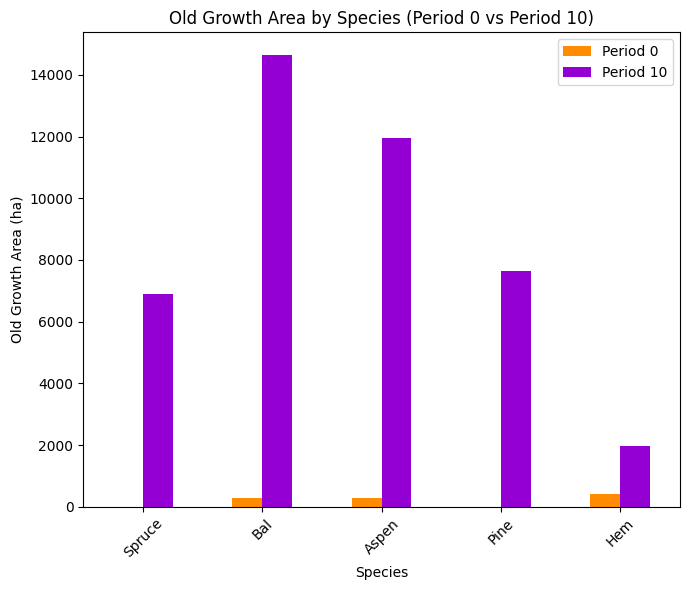

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_30%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2587
Bal: 0.3845
Aspen: 0.1284
Pine: 0.1792
Hem: 0.0492

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8930

Diversity has **decreased** by 5.26% from time 0 to time 10.


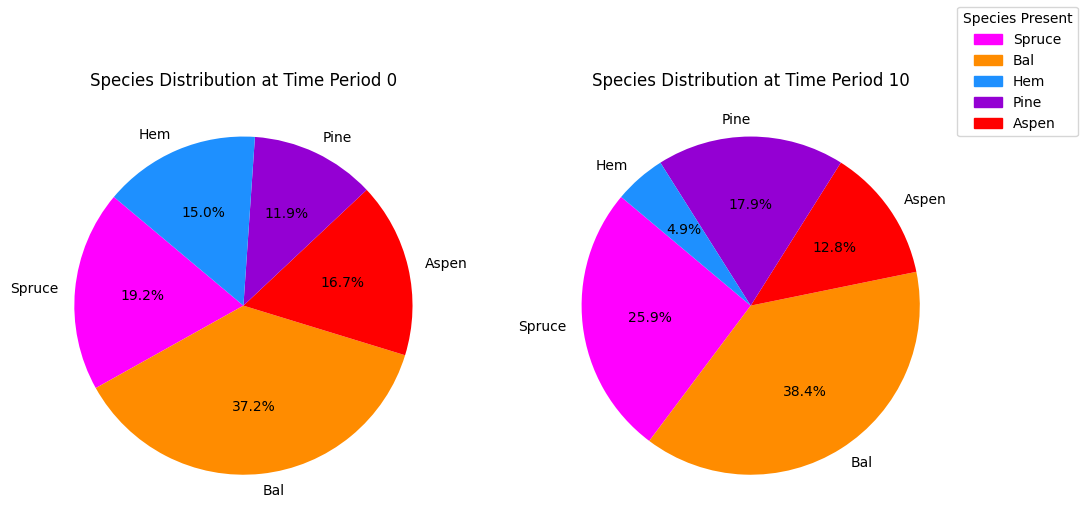

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_30%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

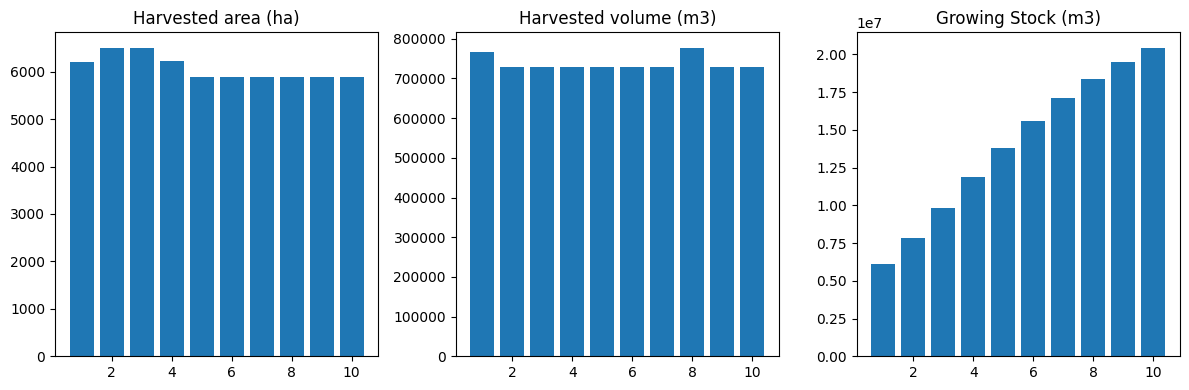

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


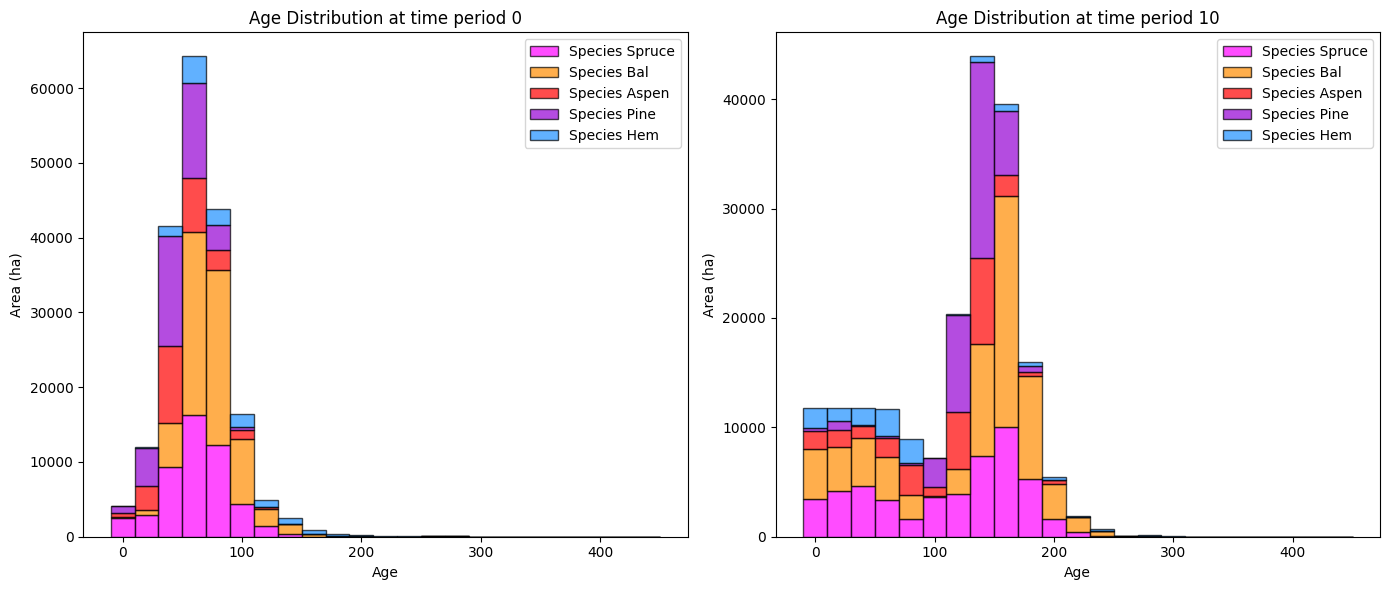

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


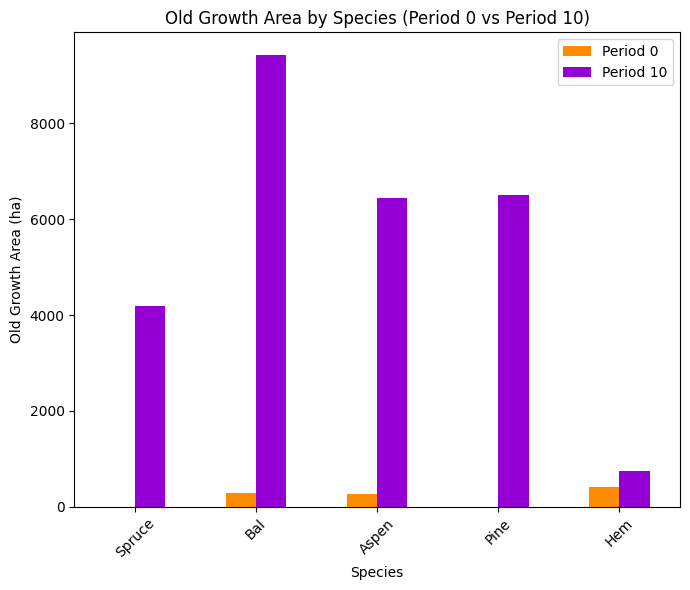

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


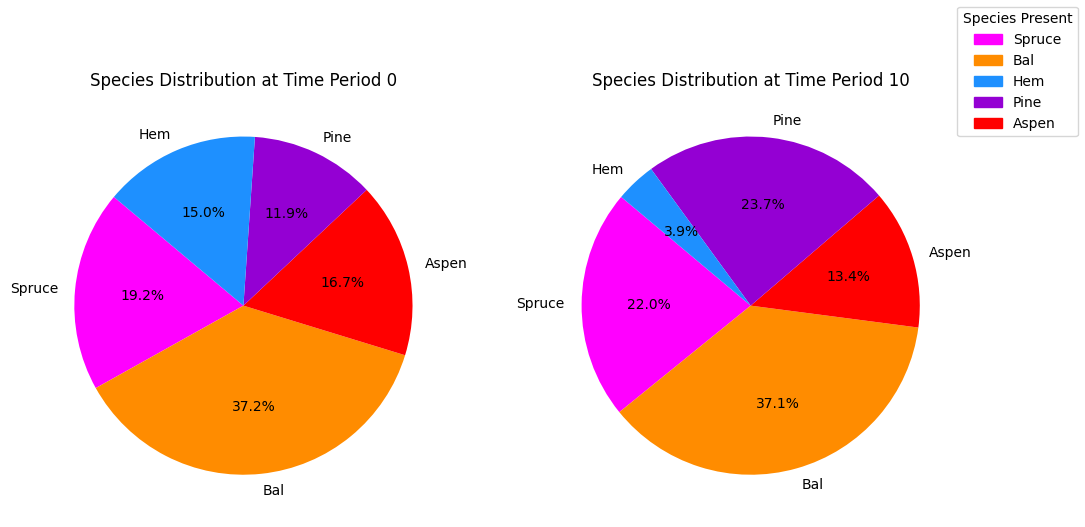

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


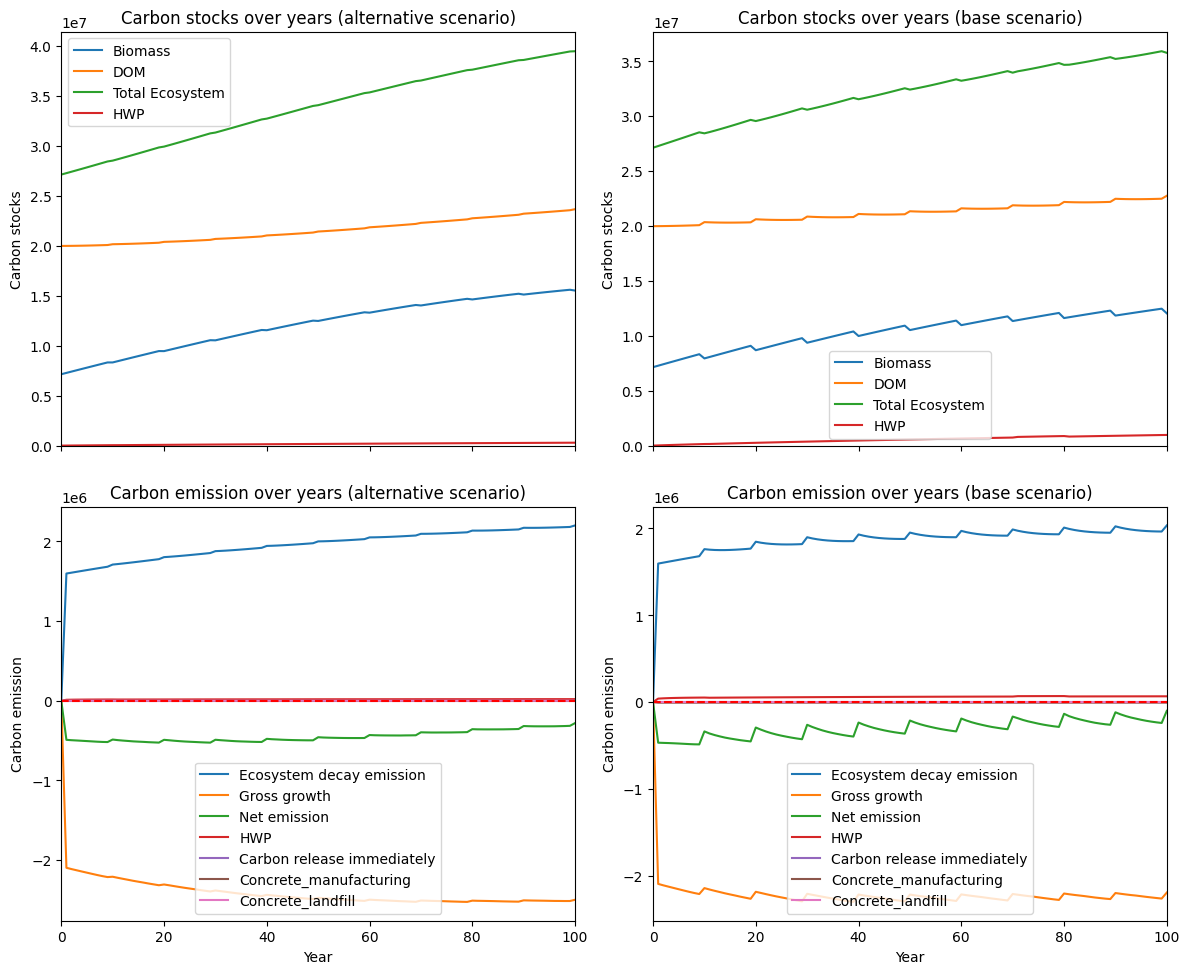

---------------------------------------------------------------------------------------
Net emission difference -2086454.087062215
Net emission base scenario -12158039.486927725
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  4.792820537968452
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2722.358443  2722.358443
Bal     0.0  5221.980510  5221.980510
Aspen   0.0  5498.815667  5498.815667
Pine    0.0  1120.061136  1120.061136
Hem     0.0  1206.027149  1206.027149

Overall, the old growth area has **increased** by 15769.24 hectares in the alternative scenario compared to the base scenario.


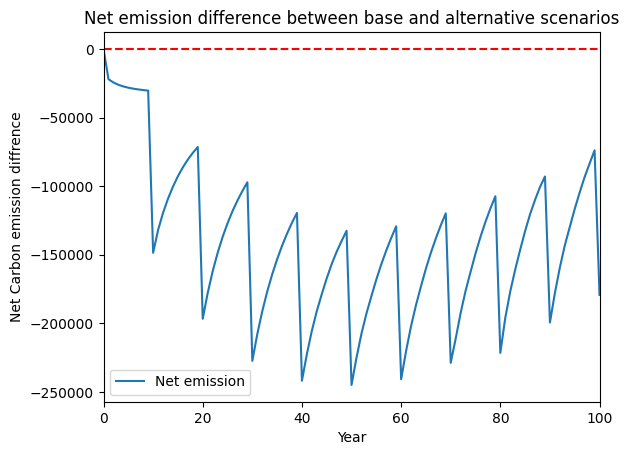

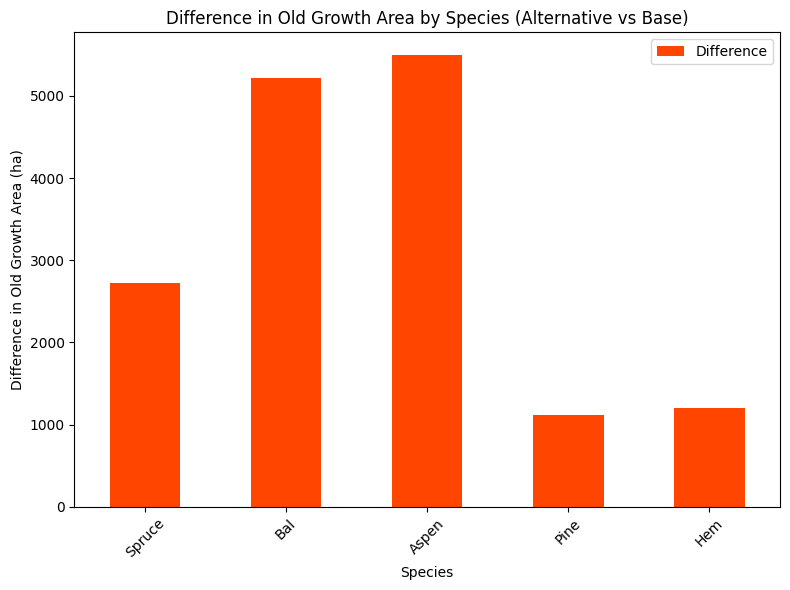

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


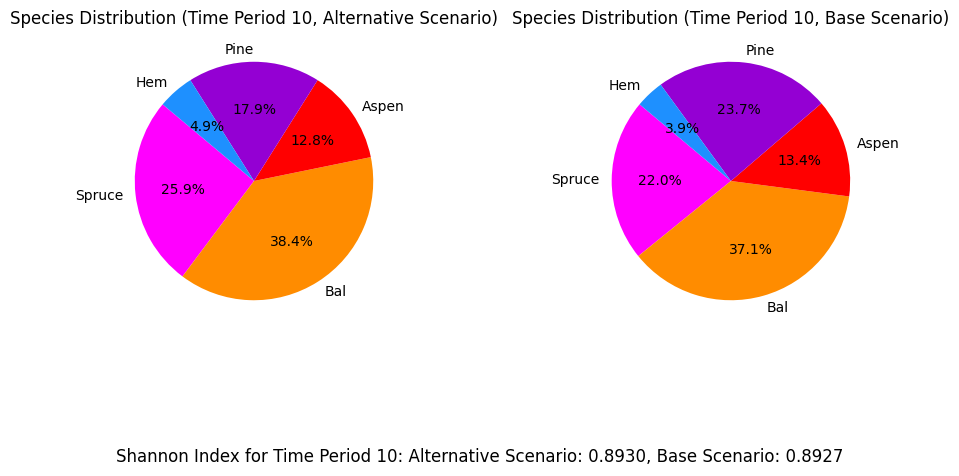

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_20%...
running the scenario for the Golden Bear mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x05723b1c
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.20s
Presolved: 1911 rows, 32226 

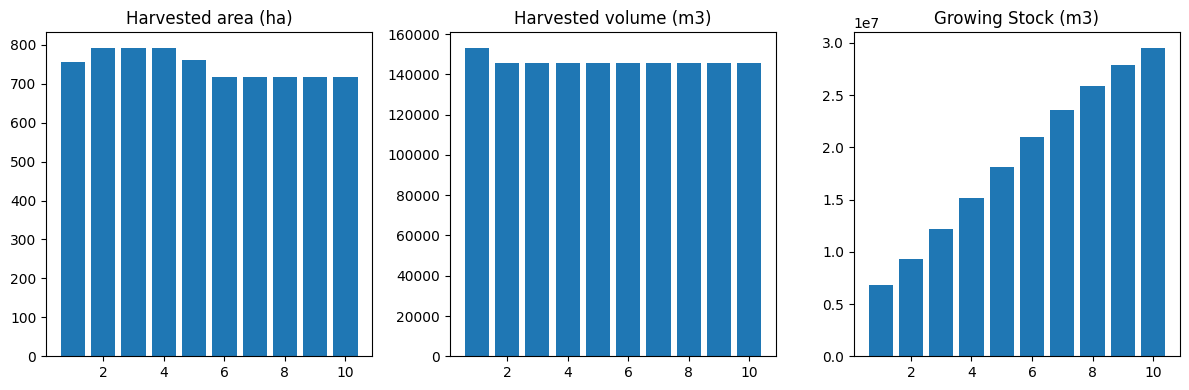

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_20%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  1546
The economic indicator (the provincial government revenues) is:  52752
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


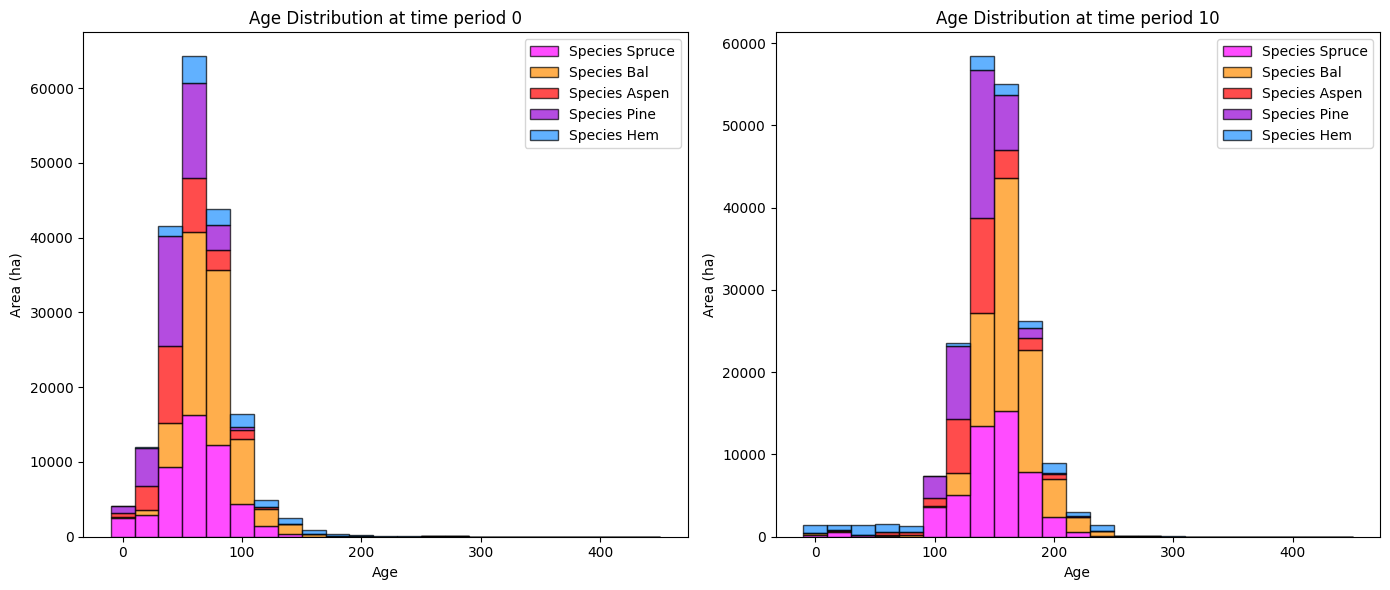

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7631.878145   7629.169611
Bal     278.565372  15437.808084  15159.242712
Aspen   273.490478  12500.156018  12226.665540
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   2337.796602   1918.097272

Overall diversity has **increased** by 44565.06 hectares from time period 0 to time period 10.


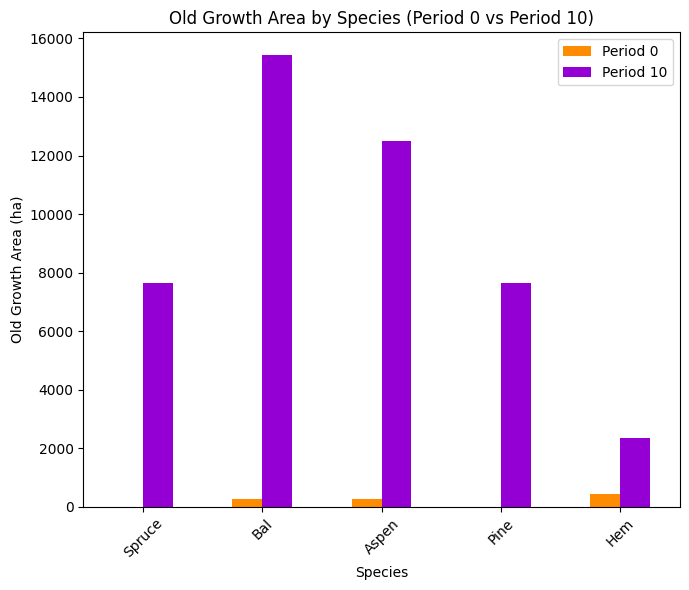

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_20%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2647
Bal: 0.3789
Aspen: 0.1279
Pine: 0.1729
Hem: 0.0555

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8988

Diversity has **decreased** by 4.68% from time 0 to time 10.


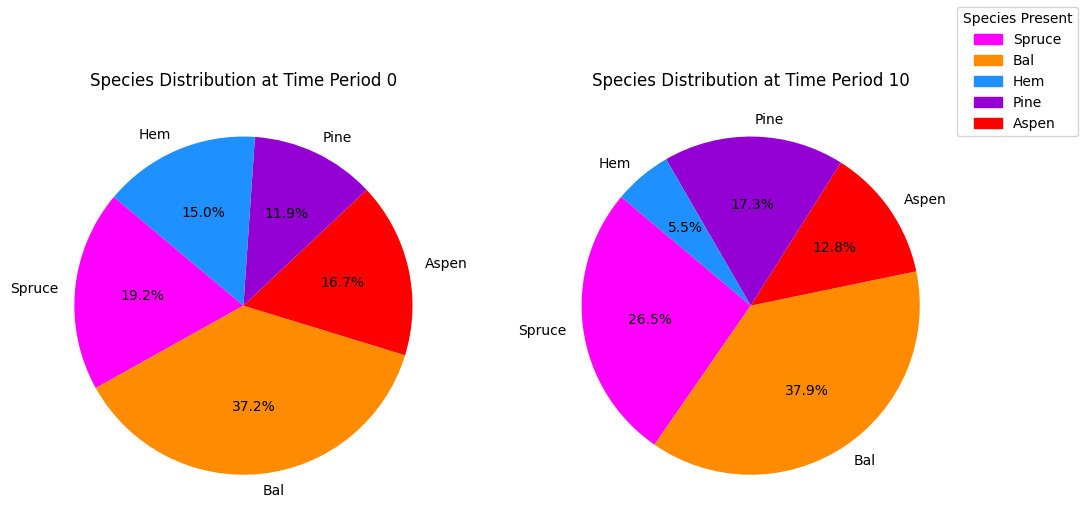

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_20%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.17s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

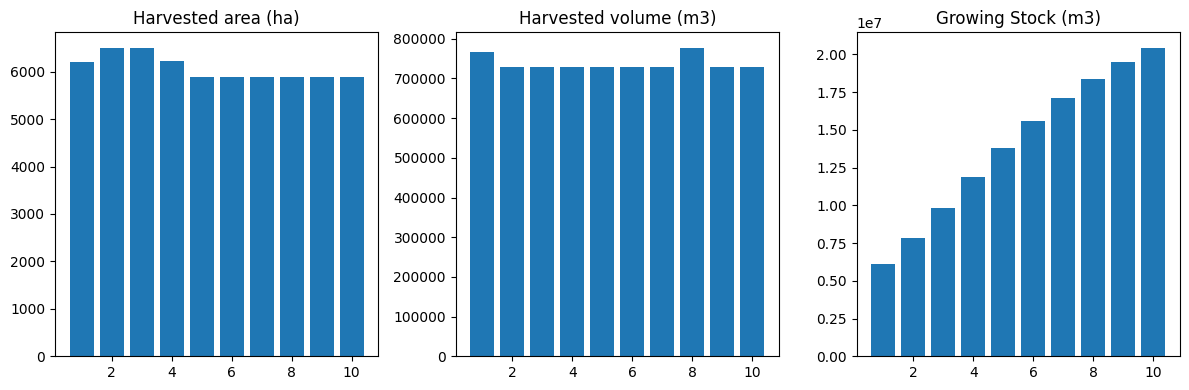

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


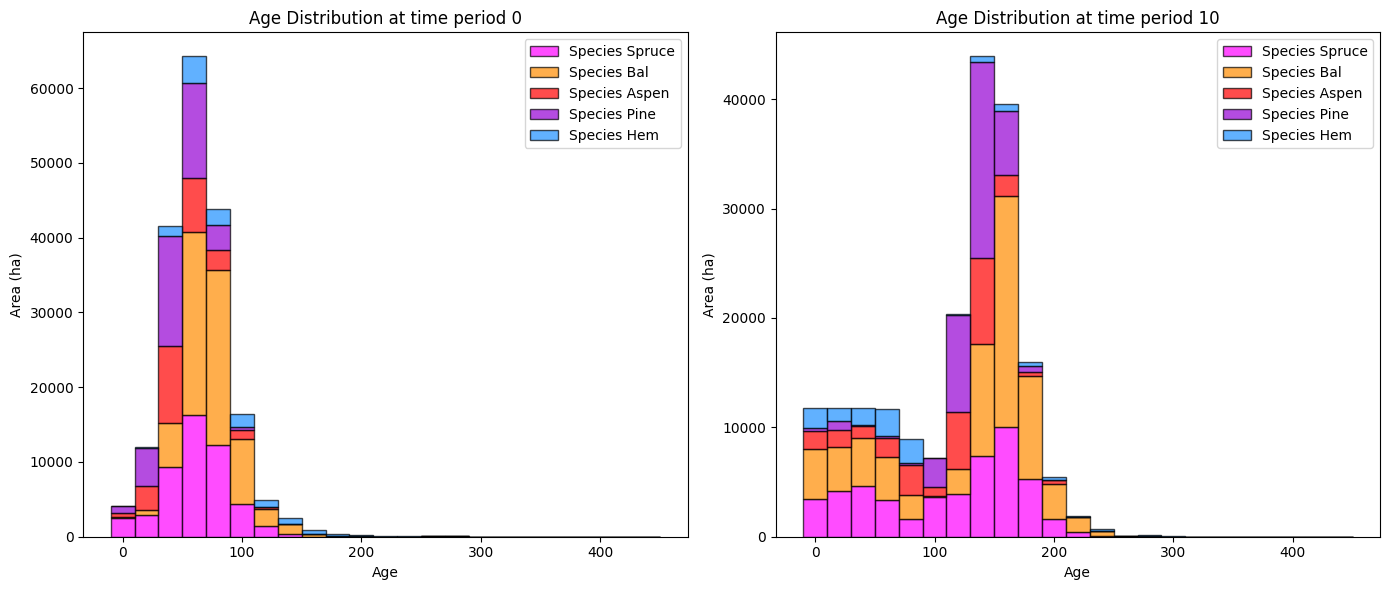

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


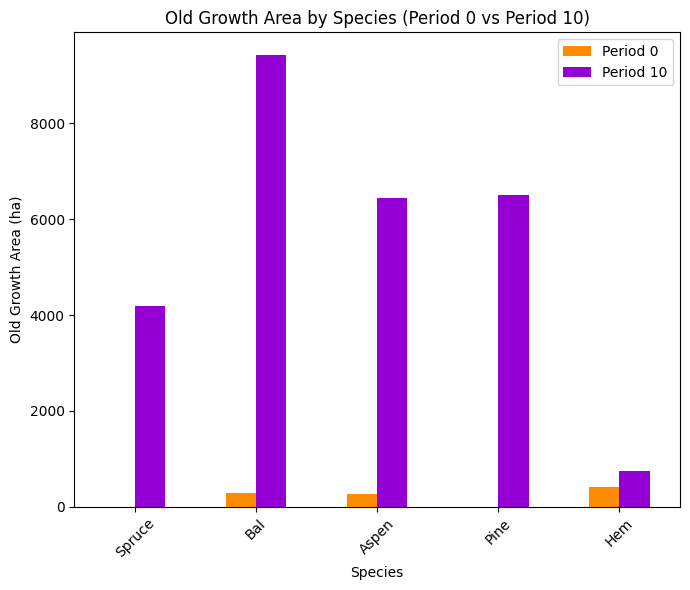

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


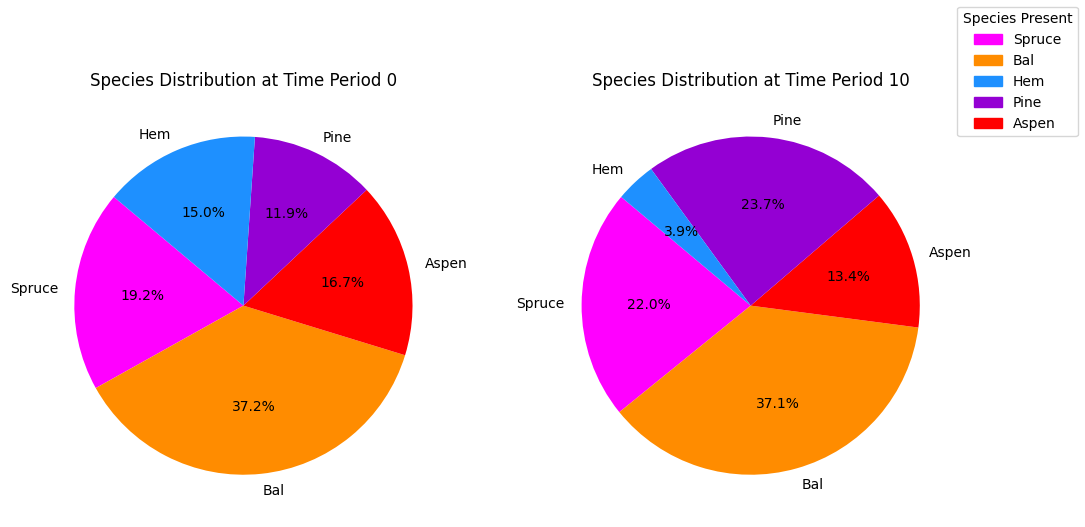

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


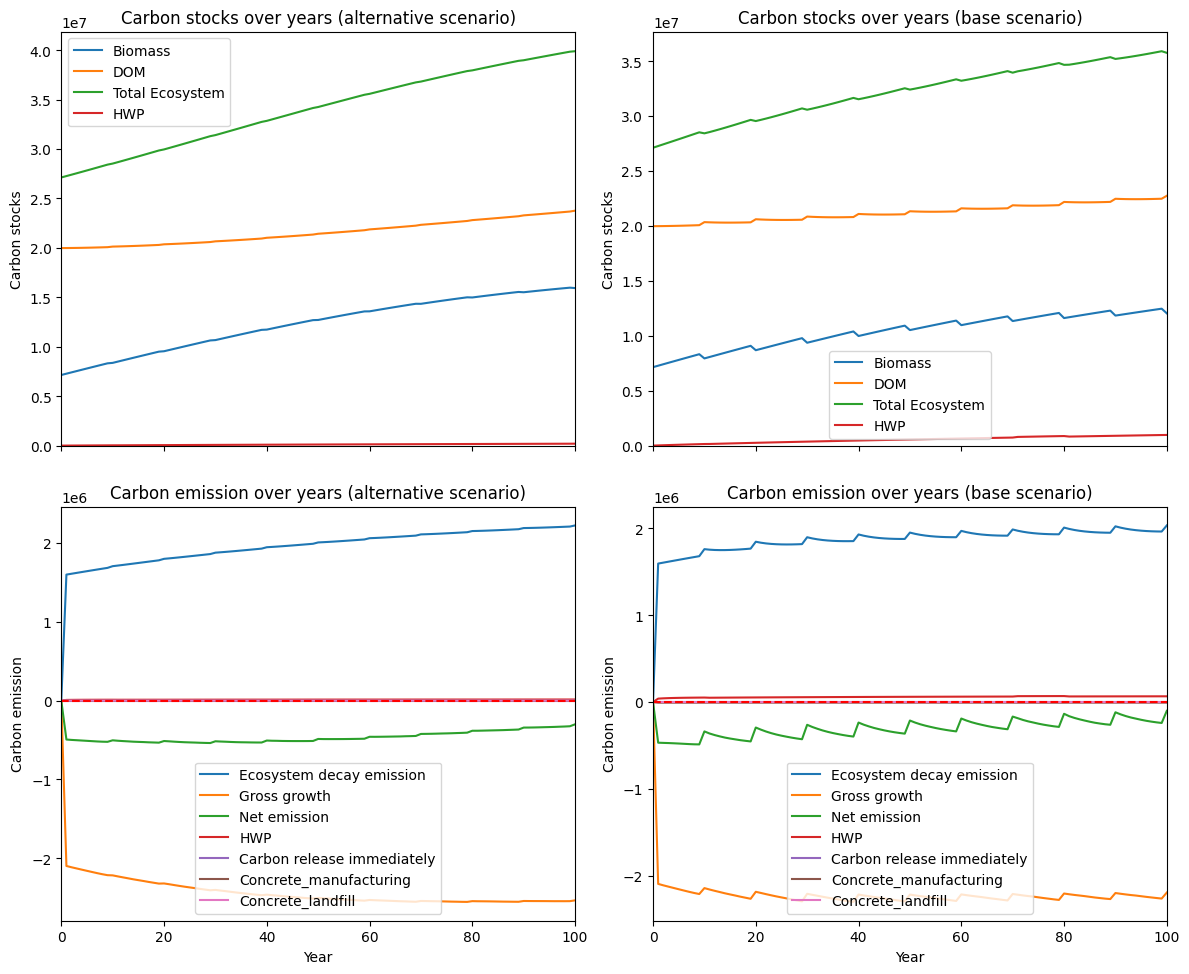

---------------------------------------------------------------------------------------
Net emission difference -2331222.7405211027
Net emission base scenario -12402808.140386615
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  4.289594394469866
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3447.931988  3447.931988
Bal     0.0  6010.669423  6010.669423
Aspen   0.0  6050.632622  6050.632622
Pine    0.0  1120.061136  1120.061136
Hem     0.0  1586.265408  1586.265408

Overall, the old growth area has **increased** by 18215.56 hectares in the alternative scenario compared to the base scenario.


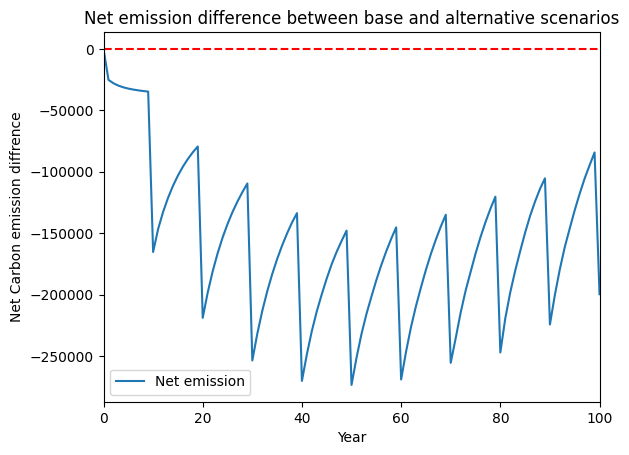

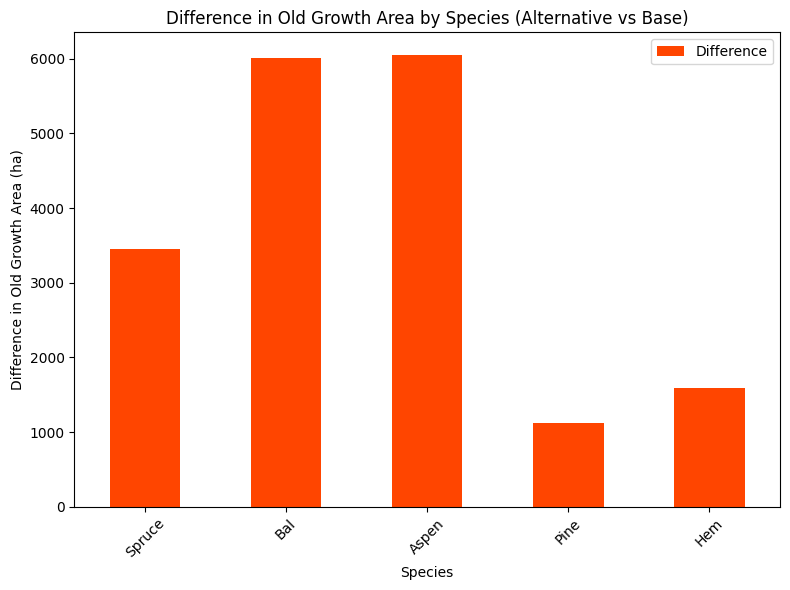

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


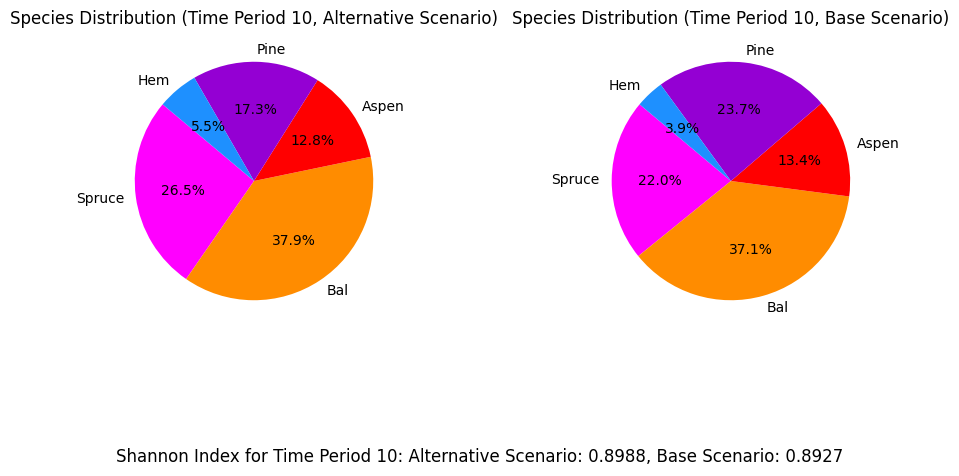

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for goldenbear_min_ha_gldbr_AAC_10%...
running the scenario for the Golden Bear mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0xb2ed4560
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.17s
Presolved: 1911 rows, 32226 

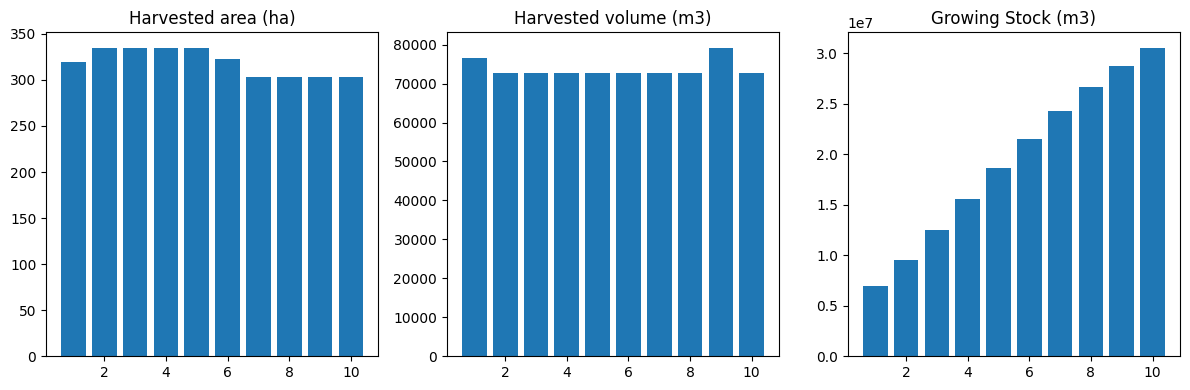

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_10%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  780
The economic indicator (the provincial government revenues) is:  26607
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


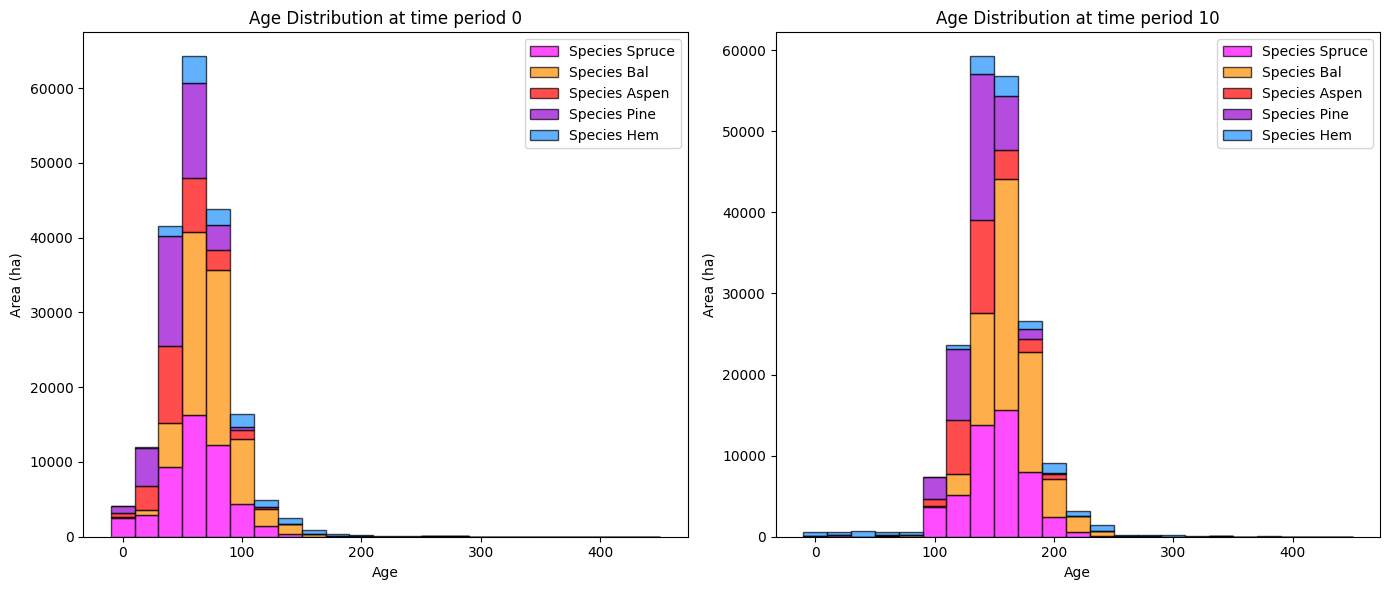

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   7877.183617   7874.475083
Bal     278.565372  15757.258242  15478.692870
Aspen   273.490478  12989.123297  12715.632819
Pine      0.000000   7631.887200   7631.887200
Hem     419.699331   2901.038689   2481.339359

Overall diversity has **increased** by 46182.03 hectares from time period 0 to time period 10.


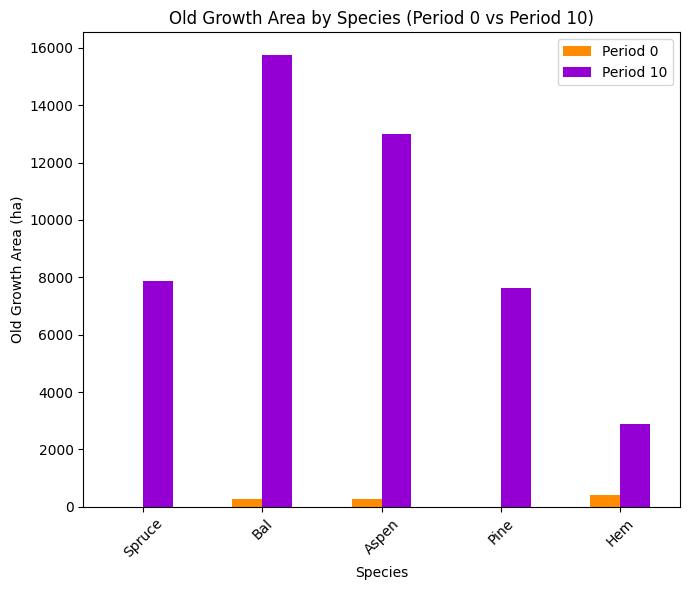

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_10%_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2631
Bal: 0.3706
Aspen: 0.1255
Pine: 0.1674
Hem: 0.0734

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.9137

Diversity has **decreased** by 3.18% from time 0 to time 10.


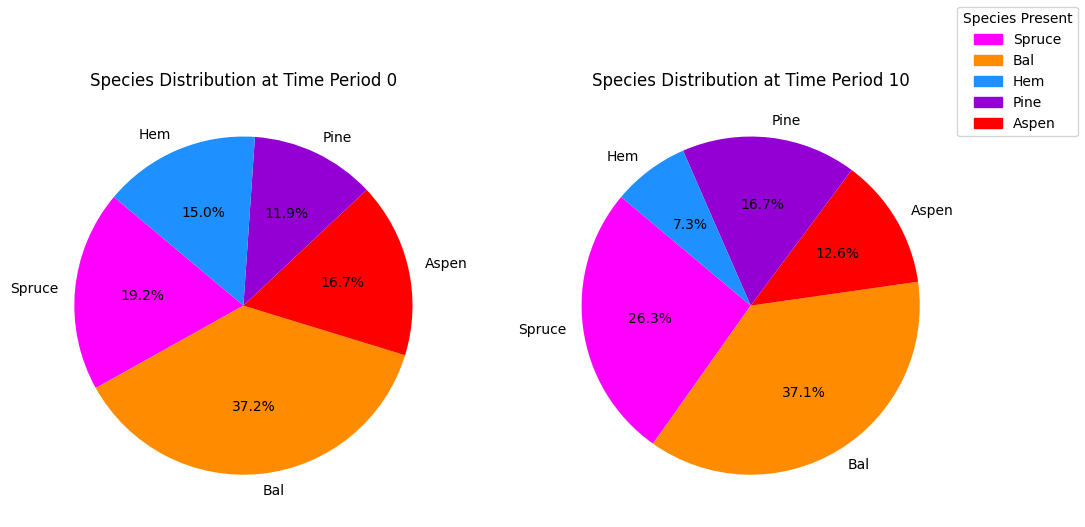

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_10%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x13177ed3
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+07]
Presolve removed 2037 rows and 2031 columns
Presolve time: 0.16s
Presolved: 1912 rows, 34099 columns, 421112 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.876e+04
 Factor NZ  : 9.245e+04 (roughly 15 MB of memory)
 Fact

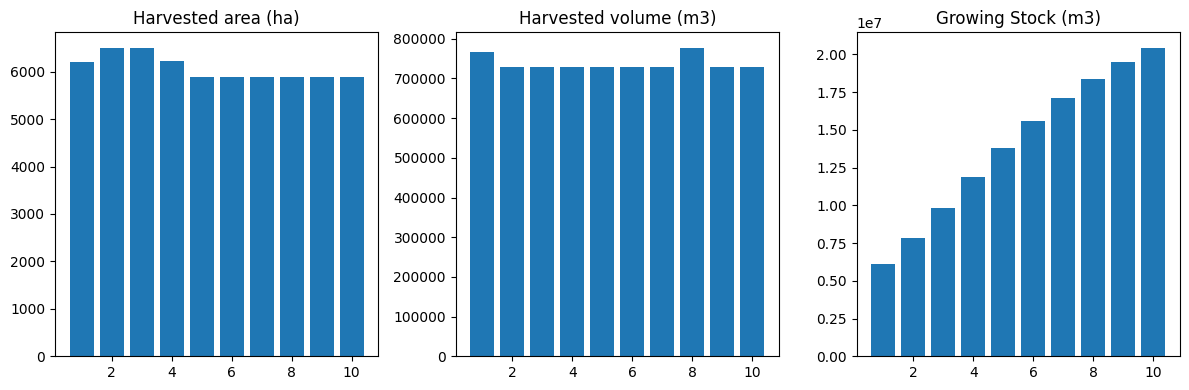

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7787
The economic indicator (the provincial government revenues) is:  265554
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


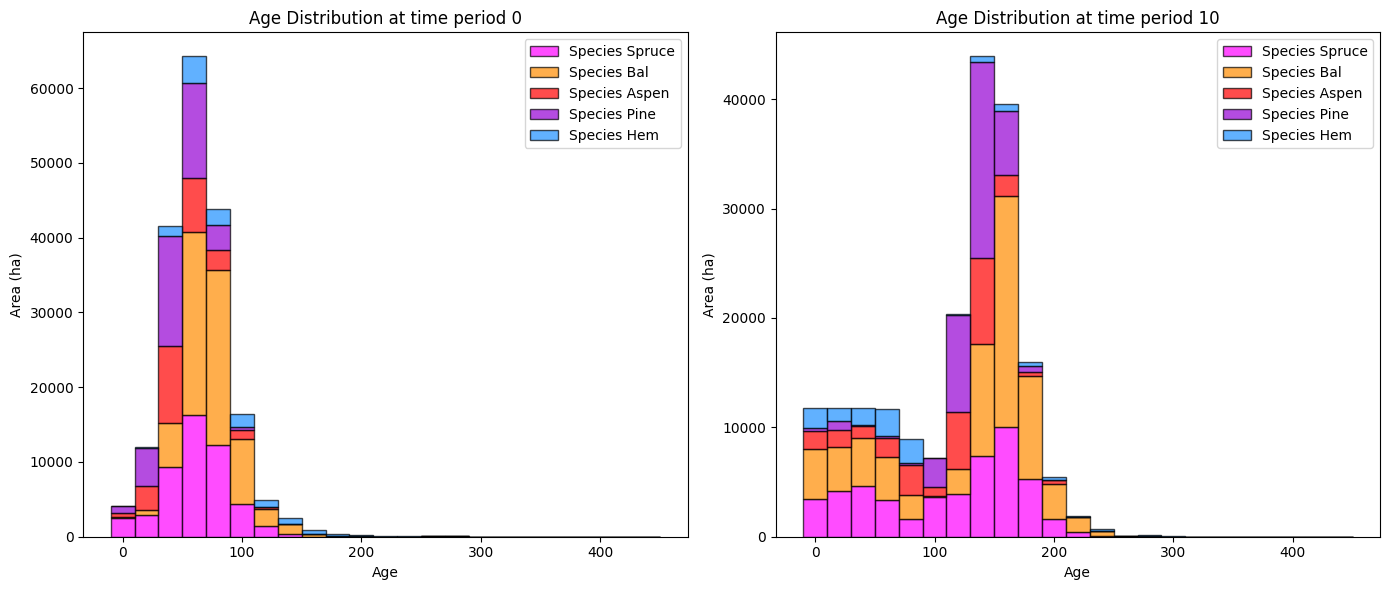

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4183.946156  4181.237623
Bal     278.565372  9427.138661  9148.573289
Aspen   273.490478  6449.523396  6176.032918
Pine      0.000000  6511.826064  6511.826064
Hem     419.699331   751.531195   331.831864

Overall diversity has **increased** by 26349.50 hectares from time period 0 to time period 10.


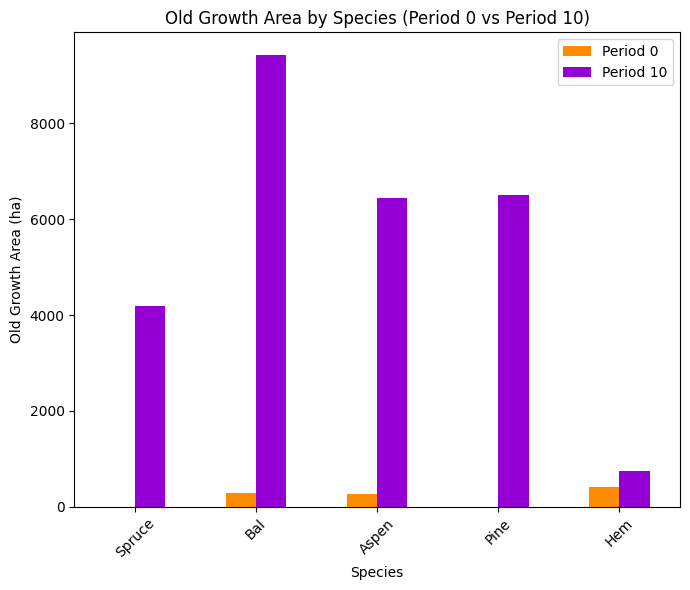

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Portion for time period 0:
Spruce: 0.1922
Bal: 0.3716
Aspen: 0.1674
Pine: 0.1191
Hem: 0.1497

Portion for time period 10:
Spruce: 0.2195
Bal: 0.3709
Aspen: 0.1335
Pine: 0.2374
Hem: 0.0386

Shannon Evennes Index for time period 0: 0.9455
Shannon Evennes Index for time period 10: 0.8927

Diversity has **decreased** by 5.29% from time 0 to time 10.


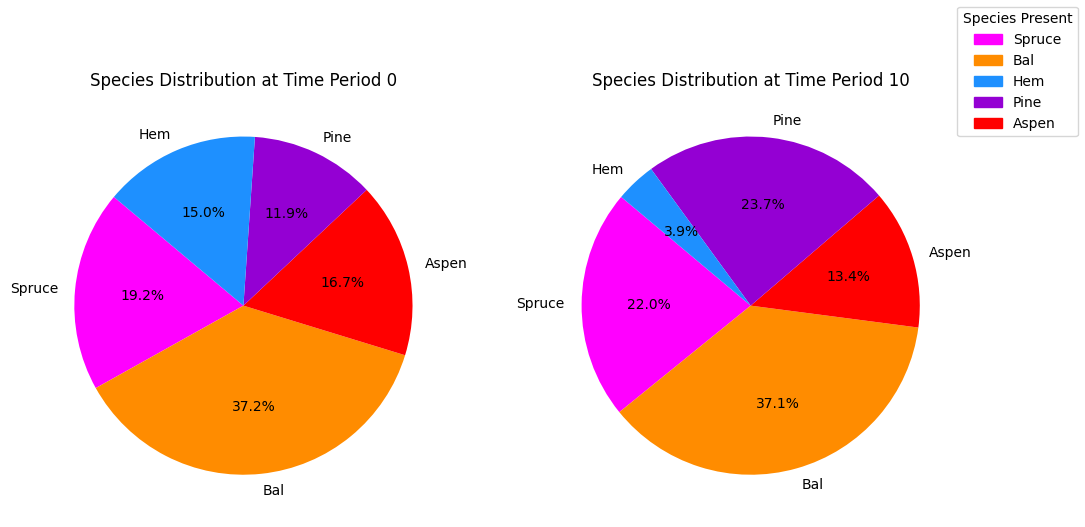

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


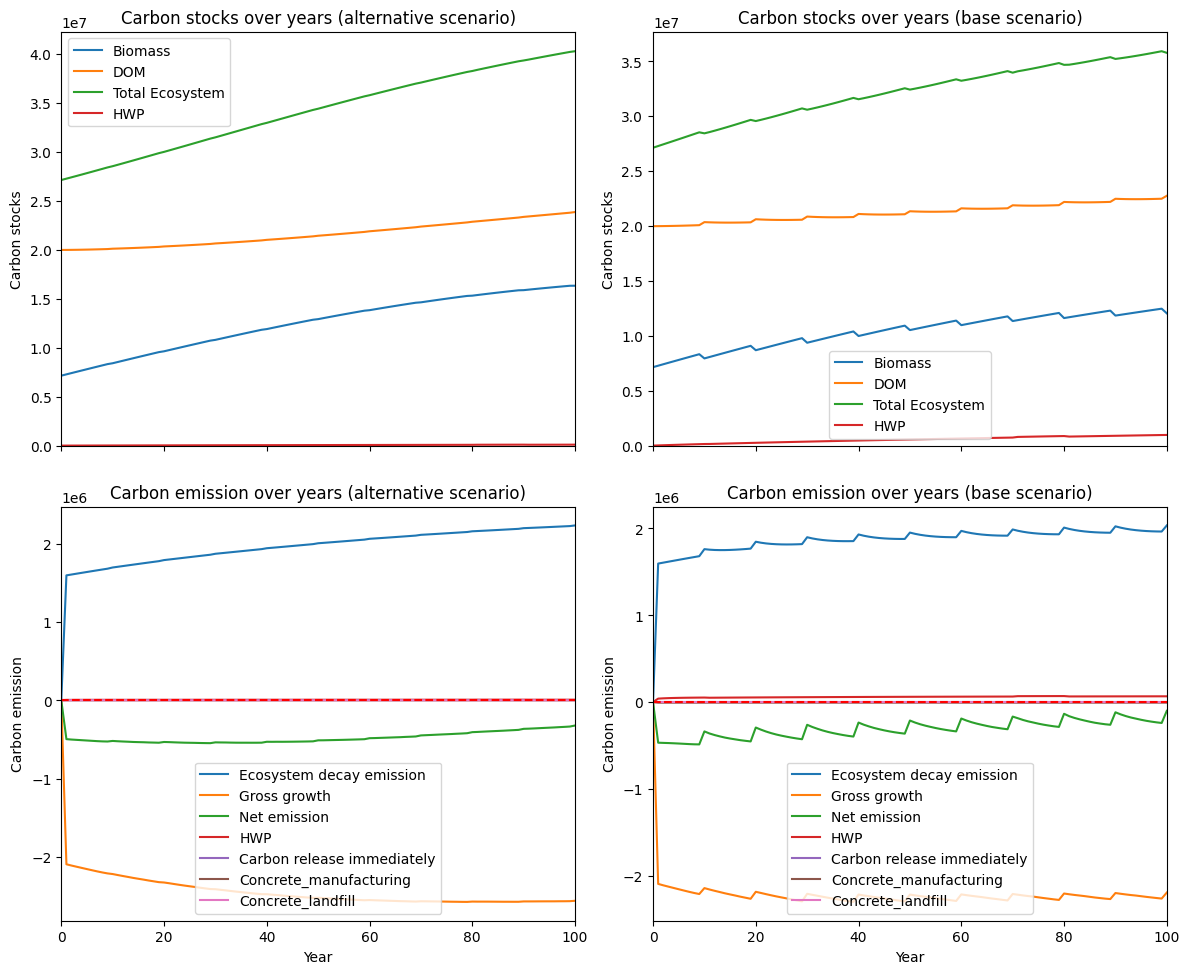

---------------------------------------------------------------------------------------
Net emission difference -2571617.9275926077
Net emission base scenario -12643203.327458117
Net emission alternative scenario -10071585.399865512
dollar_per_ton is:  3.888602537998867
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  3693.237460  3693.237460
Bal     0.0  6330.119581  6330.119581
Aspen   0.0  6539.599901  6539.599901
Pine    0.0  1120.061136  1120.061136
Hem     0.0  2149.507495  2149.507495

Overall, the old growth area has **increased** by 19832.53 hectares in the alternative scenario compared to the base scenario.


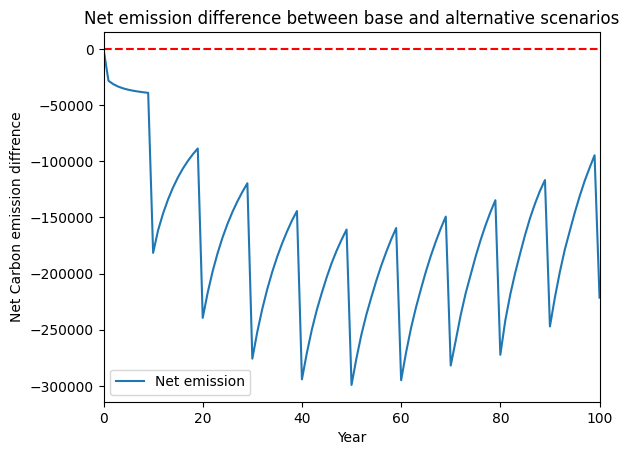

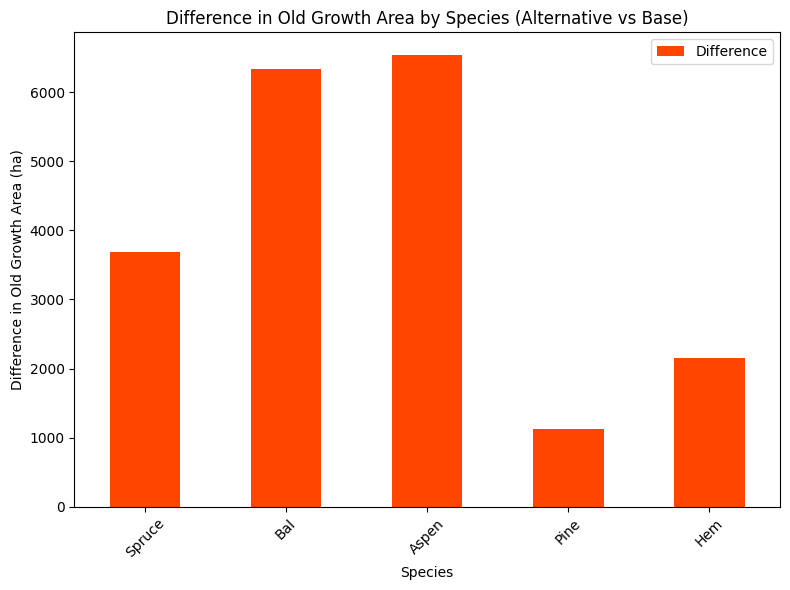

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


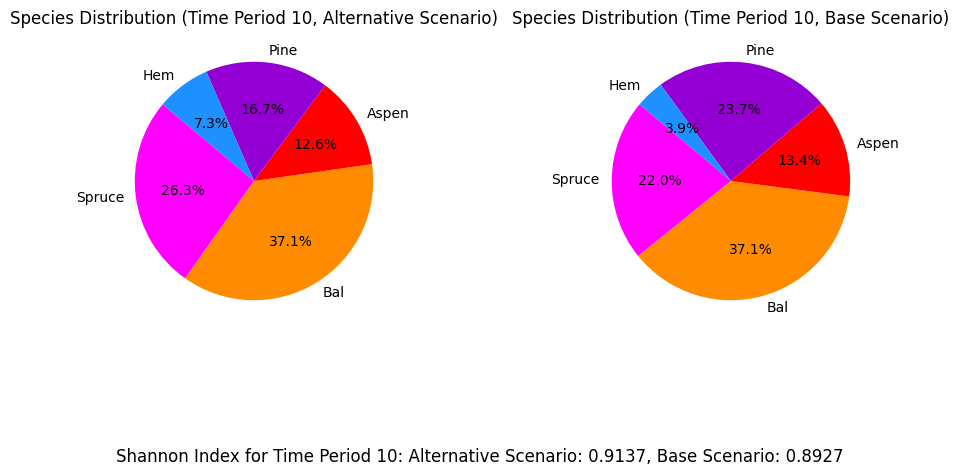

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 97.5 minutes to run all scenarios.


In [12]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=True, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for goldenbear_min_ha_gldbr_AAC_40%...
running the scenario for the Golden Bear mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x184ee945
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.17s
Presolved: 1911 rows, 32226 columns, 407292 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.685e+04
 Factor NZ  : 9.050e

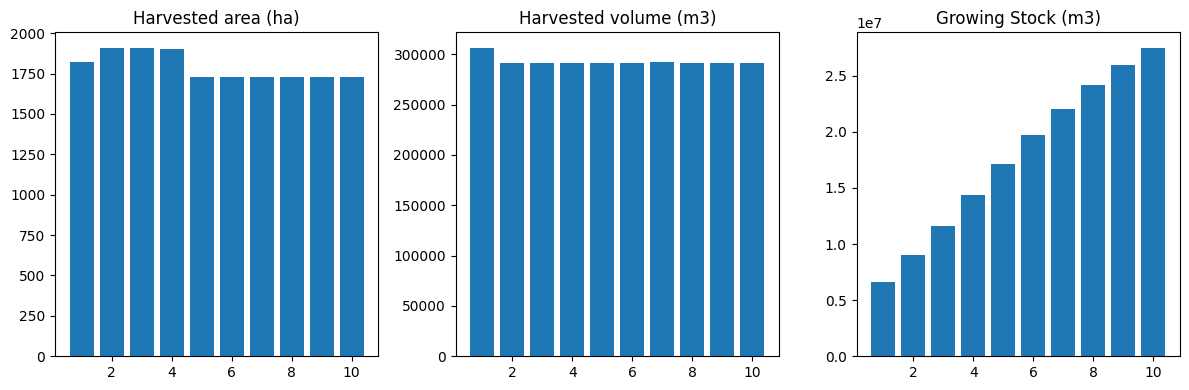

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  3094
The economic indicator (the provincial government revenues) is:  105539
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


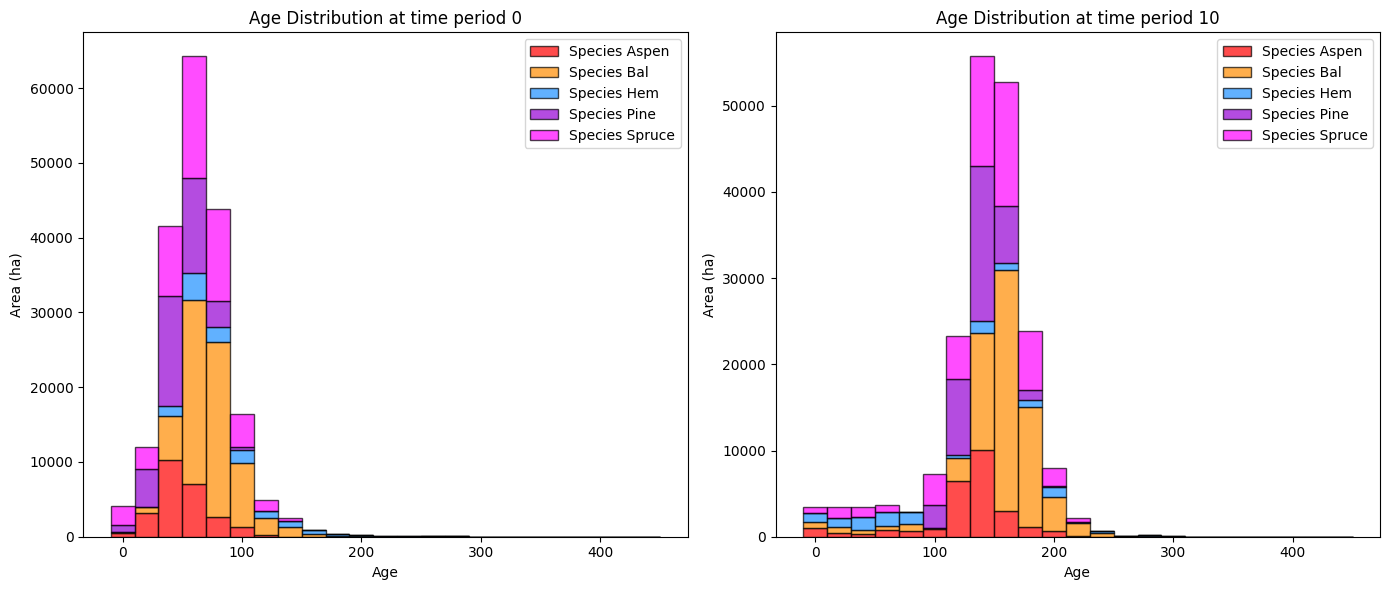

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0            10    Difference
Spruce    2.708533   6457.218580   6454.510047
Bal     278.565372  13811.648105  13533.082733
Aspen   273.490478  10611.398243  10337.907765
Pine      0.000000   7624.792624   7624.792624
Hem     419.699331   1499.652633   1079.953303

Old growth has **increased** by 39030.25 hectares from time period 0 to time period 10.


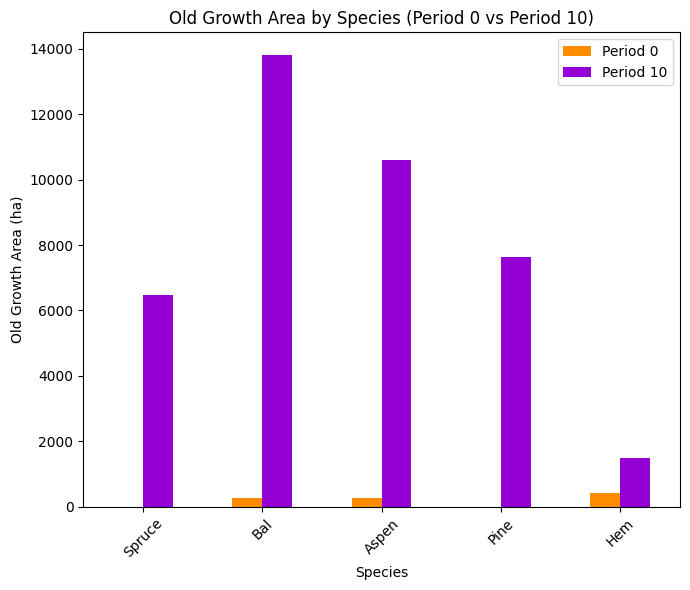

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.8875

Diversity has **decreased** by 5.80% from time 0 to time 10.


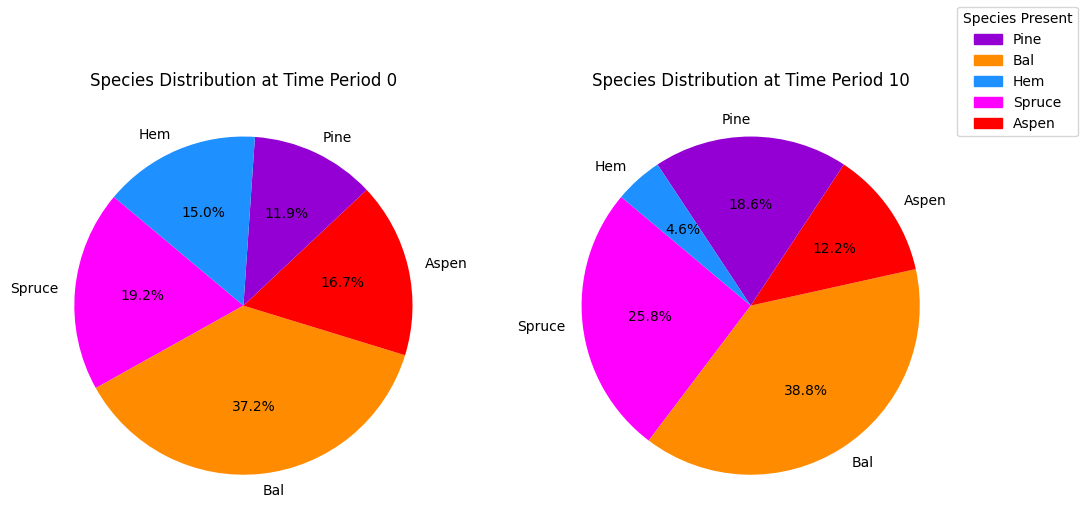

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_gldbr_AAC_40%_species_pie.pdf
running business as usual scenario for the Golden Bear mine site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3949 rows, 36130 columns and 470612 nonzeros
Model fingerprint: 0x17162bc7
Coefficient statistics:
  Matrix range     [1e-02, 1e+05]
  Objective range  [2e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2038 rows and 3905 columns
Presolve time: 0.16s
Presolved: 1911 rows, 32225 columns, 407291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time

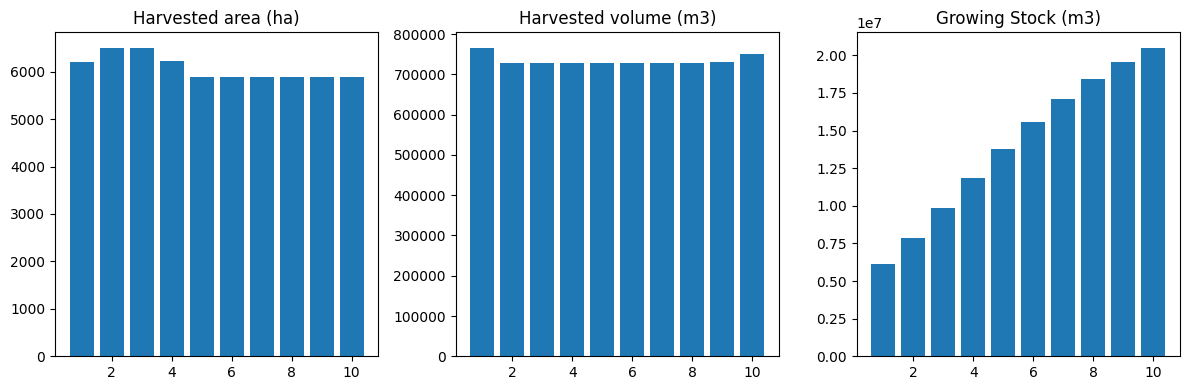

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_scheduling.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  7759
The economic indicator (the provincial government revenues) is:  264628
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


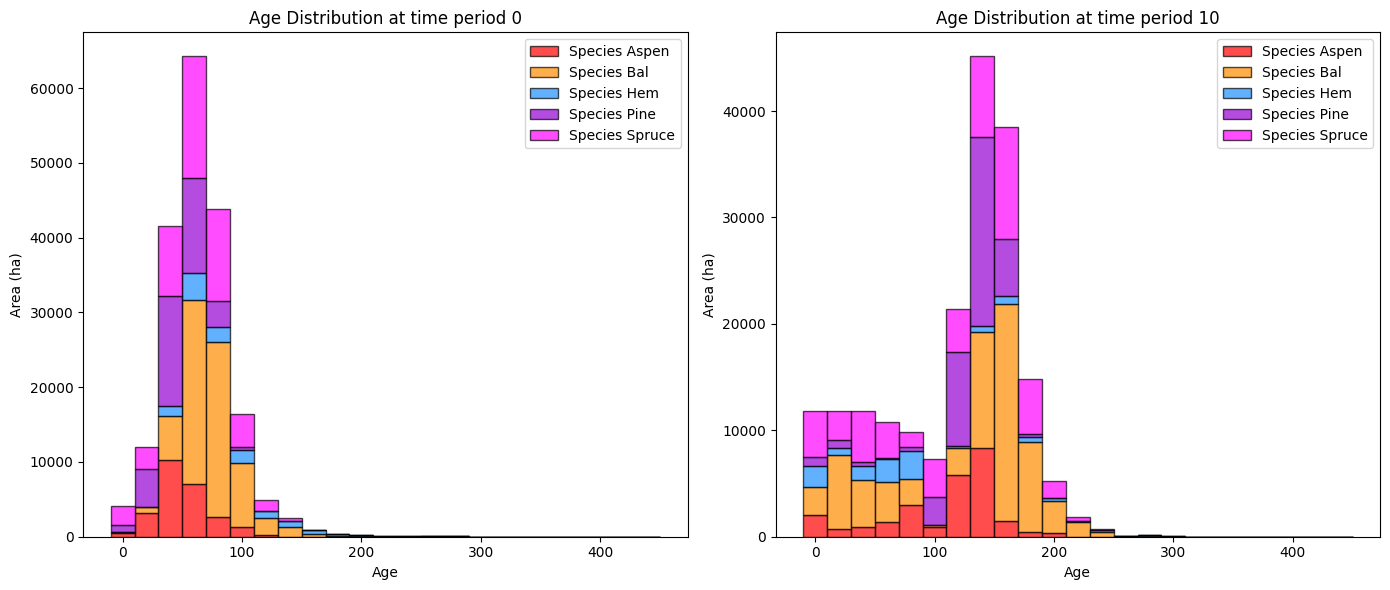

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                 0           10   Difference
Spruce    2.708533  4259.936249  4257.227716
Bal     278.565372  9020.773269  8742.207898
Aspen   273.490478  6525.108441  6251.617963
Pine      0.000000  5968.010518  5968.010518
Hem     419.699331   801.166864   381.467533

Old growth has **increased** by 25600.53 hectares from time period 0 to time period 10.


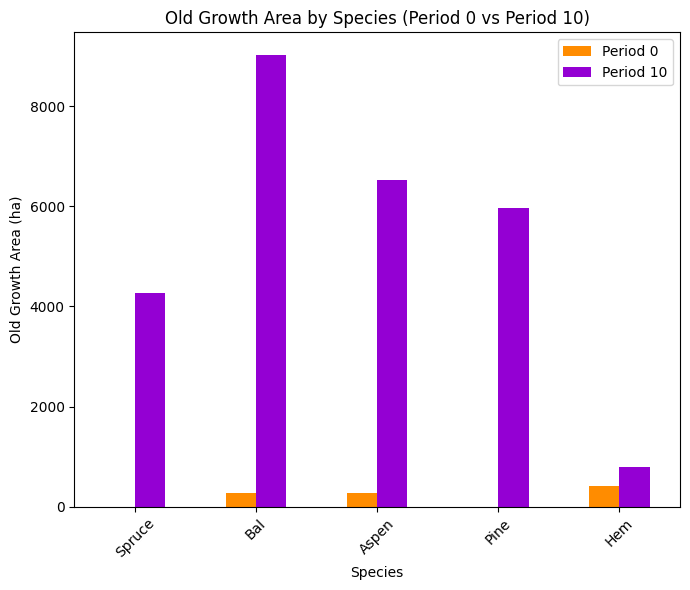

Clustered column plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.9455
Shannon Evenness Index for time period 10: 0.9003

Diversity has **decreased** by 4.53% from time 0 to time 10.


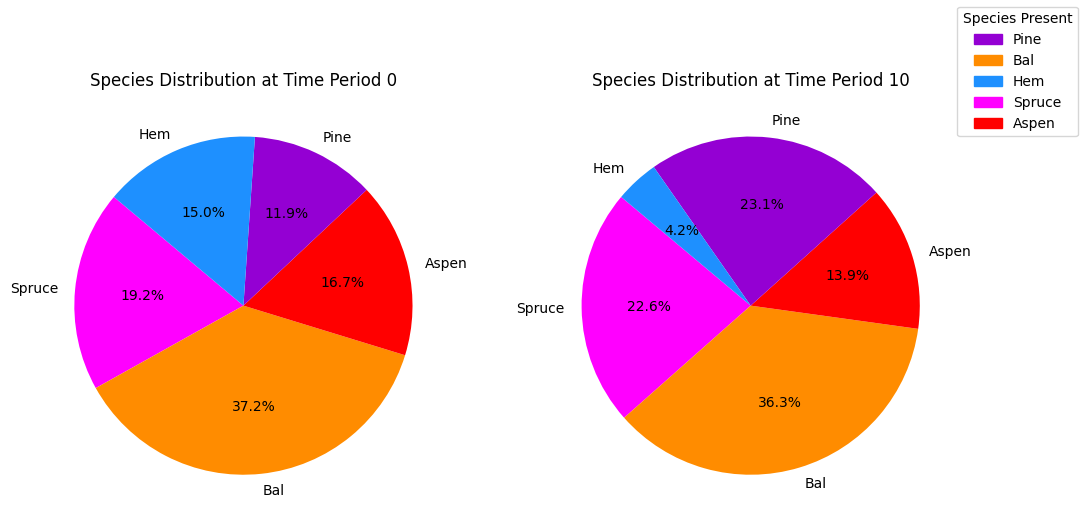

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_bau_gldbr_species_pie.pdf


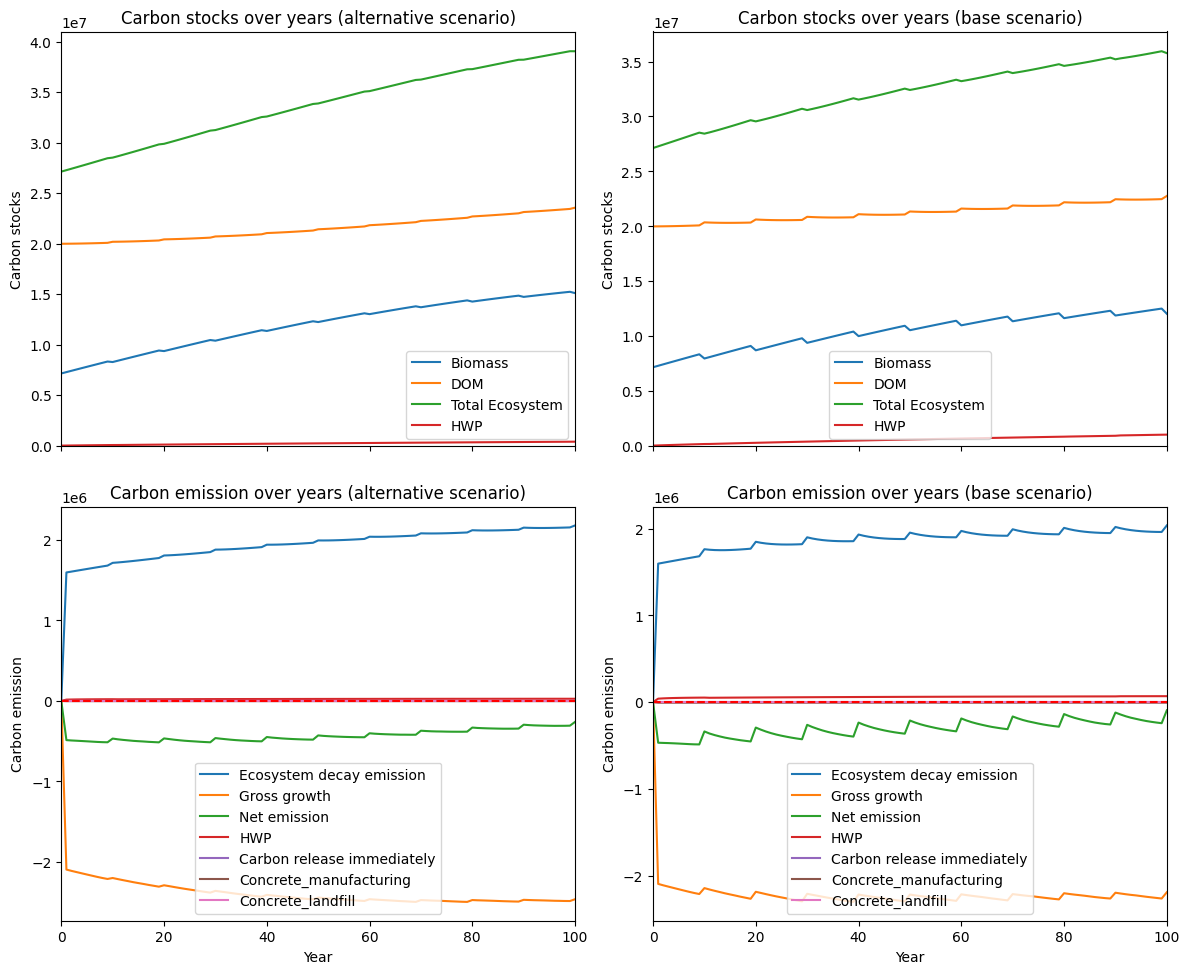

---------------------------------------------------------------------------------------
Net emission difference -12482962.684609208
Net emission base scenario -30629745.410480794
Net emission alternative scenario -43112708.095089994
dollar_per_ton is:  0.8010918763964133
Comparison of Old Growth Areas (Alternative - Base)
          0           10   Difference
Spruce  0.0  2197.282331  2197.282331
Bal     0.0  4790.874836  4790.874836
Aspen   0.0  4086.289802  4086.289802
Pine    0.0  1656.782105  1656.782105
Hem     0.0   698.485770   698.485770

Overall, the old growth area has **increased** by 13429.71 hectares in the alternative scenario compared to the base scenario.


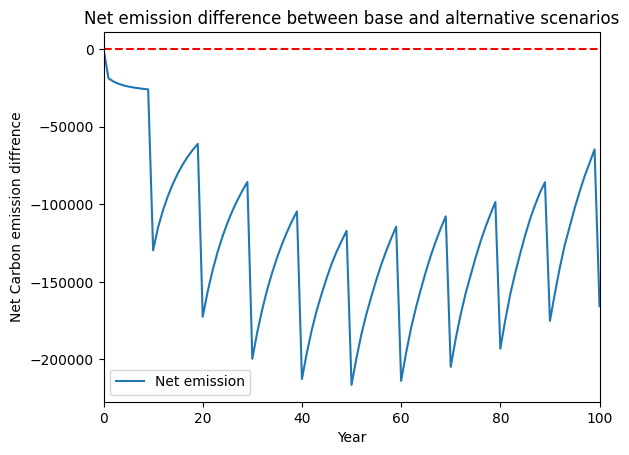

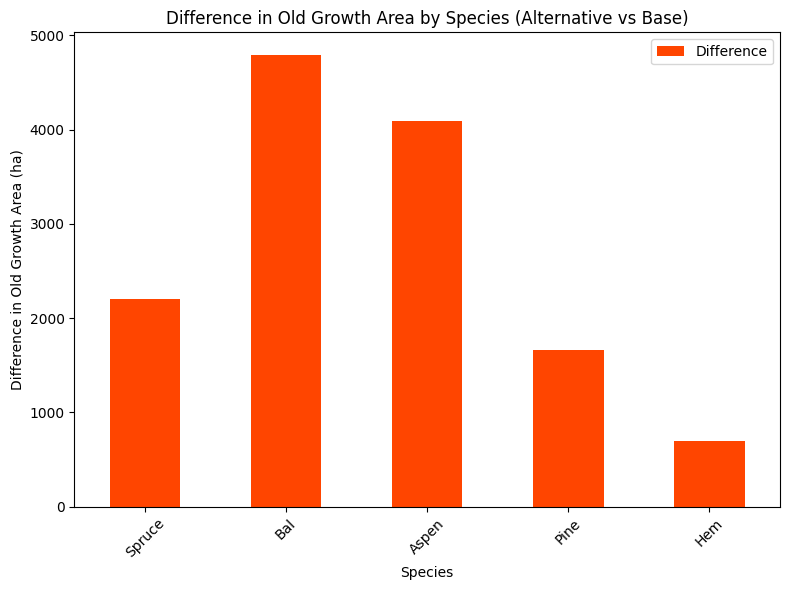

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_age_difference.pdf


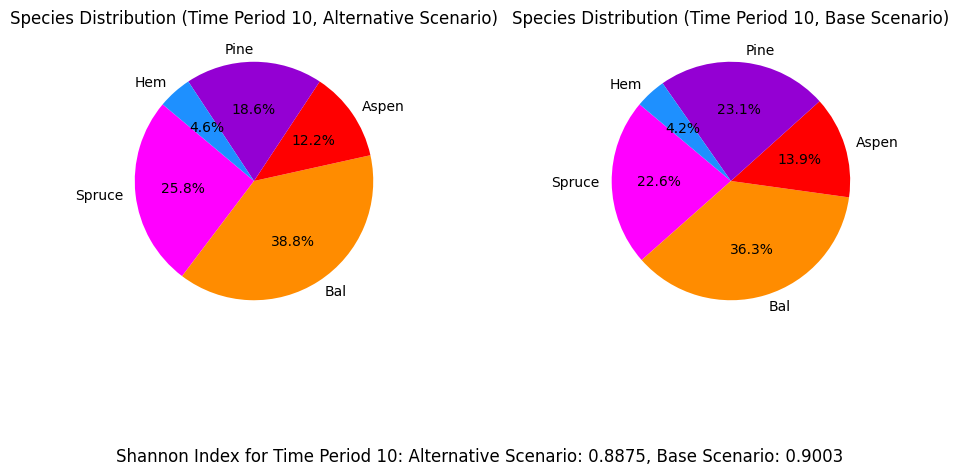

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/goldenbear/goldenbear_min_ha_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 16.2 minutes to run all scenarios.


In [16]:
scenario_names = ['gldbr_AAC_40%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [13]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 97.5 minutes to run this script.
